# Impact of Gender on Age Classification of Voice Recordings
### Final Exam for Machine Learning and Deep Learning [CDSCO2004U]
#### Daniel Henke, Jakob Hren, Heinrich Hegenbarth

**Disclaimer:** This notebook is very long and computationally expensive. To be able to run core parts quickly, many outputs are hidden behind **global boolean variables** that one can set to True or False. Please set them according to needs and wishes

In [47]:
FULL_RUN = False

DATA_CONVERSION=False

EDA_AND_VISUALIZATION=False

GRID_SEARCH=True

MULTI_CLASSIFICATION=False

## Imports & Installations

We begin with possibly required installs.

In [2]:
#!pip install librosa
# !pip install playsound
# !pip install tqdm
# !pip install scikit-learn

Here are all the imports needed for this notebook:

In [41]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

if DATA_CONVERSION:
    import concurrent.futures
    import librosa
    from playsound import playsound
    import tarfile

import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, RocCurveDisplay
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.multioutput import MultiOutputClassifier

## Data Conversion

**DISCLAIMER: This section is skippable, the exported data is available below.**

To begin, we need to transform our data. We downloaded raw mp3 files in a tar.gz format from [Mozilla Common Voice](https://commonvoice.mozilla.org/en/datasets). Our data includes the entire March 19 corpus of languages English, Spanish, French, German, Danish & Swedish. To start, we need to unpack all the .gz files. Ideally, one fully unpacks also the .tar file, however we have implemented a .tar extraction function as we only need very few audio files from the entire archive.

### Overview & Filtering of Voice Files

In [4]:
def prepare_overview(list_of_files, folder_path=None):
    """
    This function takes a list of files and creates a joint dataframe for audio file conversion
    
    list_of_files: list of files to be converted
    folder_path: path to the folder where the files are located
    """
    overview = None
    for file in list_of_files:
        file_path = f"{folder_path}/{file}" if folder_path else file
        with open(file_path, "r") as file:
            if overview is None:
                overview = pd.read_csv(file, sep="\t", dtype={'sentence_domain': str}, low_memory=False)
            else:
                overview = pd.concat([overview, pd.read_csv(file, sep="\t", dtype={'sentence_domain': str}, low_memory=False)], ignore_index=True)
    return overview

In [5]:
if DATA_CONVERSION:
    list_of_files = ["validated.tsv","other.tsv"]
    folder_path_danish="./data/cv-corpus-21.0-2025-03-14/da"
    folder_path_swedish="./data/cv-corpus-21.0-2025-03-14/sv-SE"
    folder_path_german="./data/cv-corpus-21.0-2025-03-14/de"
    folder_path_french="./data/cv-corpus-21.0-2025-03-14/fr"
    folder_path_spanish="./data/cv-corpus-21.0-2025-03-14/es"
    folder_path_english="./data/cv-corpus-21.0-2025-03-14/en"
    folder_path=folder_path_english
    overview = prepare_overview(list_of_files,folder_path)
    overview.info()
    overview.describe(include="all")

In [6]:
if DATA_CONVERSION:
    overview.groupby("gender").size()

In [7]:
def fix_gender(gender):
    if gender == "male":
        return "male_masculine"
    elif gender == "female":
        return "female_feminine"
    else:
        return gender


def preprocess_overview(overview, f_path):
    """
    This function takes a dataframe and preprocesses it for audio file conversion
    """
    overview = overview.dropna(subset=["gender"])
    # irrelevant columns for our analysis
    overview = overview.drop(columns=["variant", "segment", "sentence_id", "up_votes", "down_votes"])
    # fixing gender labels
    overview["gender"] = overview["gender"].apply(fix_gender)
    # dropping all files that are not simply male or female
    # this is not a political statement, simply we do not have enough data for other gender classifications
    overview = overview[(overview["gender"] == "female_feminine") | (overview["gender"] == "male_masculine")]
    # limiting to a maximum of 5 random clips per client_id
    overview = overview.groupby("client_id").apply(lambda group: group.sample(n=min(len(group), 5), random_state=42)).reset_index(drop=True)
    # changing the path to reflect the location of the audio files
    overview["path"] = overview["path"].apply(lambda x: f"{f_path}/{x}")
    return overview.reset_index(drop=True)

In [8]:
# On my device, all audio files are in the same "clips" folder. Please change the path if your files are in a different location.
if DATA_CONVERSION:
    overview=preprocess_overview(overview, "clips")
    overview.head()

In [9]:
if DATA_CONVERSION:
    overview.describe(include="all")

In [10]:
if DATA_CONVERSION:
    overview.groupby("gender").size()

In [11]:
if DATA_CONVERSION:
    overview.groupby("age").size()

### Extraction of TAR

It is recommend to unpack a smaller language corpus like Danish and Swedish directly. However, for English and Spanish we recommend using these functions. Extraction of .gz is always necessary prior to utilizing this notebook.

In [12]:
def extract_selected_files_flat(tar_path, file_paths, output_dir):
    """
    Extract specific files from a tar archive into a flat output_dir.
    Flattens the directory structure, extracting only the file name.
    """
    os.makedirs(output_dir, exist_ok=True)
    successful = []
    failed = []

    with tarfile.open(tar_path, "r") as tar:
        for raw_path in tqdm(file_paths, desc="Extracting"):
            # Normalize path to forward slashes
            path_in_tar = raw_path.replace("\\", "/")
            try:
                member = tar.getmember(path_in_tar)
                extracted_file = tar.extractfile(member)

                if extracted_file is None:
                    failed.append(path_in_tar)
                    continue

                # Get only the file name from the path (robust)
                file_name = path_in_tar.split("/")[-1]
                out_path = os.path.join(output_dir, "clips", file_name)

                with open(out_path, "wb") as f:
                    f.write(extracted_file.read())

                if os.path.isfile(out_path):
                    successful.append(path_in_tar)
                else:
                    failed.append(path_in_tar)

            except KeyError:
                failed.append(path_in_tar)

    print(f"Extracted {len(successful)} files.")
    if failed:
        print(f"Failed to extract {len(failed)} files.")
    return successful, failed

def ensure_files_unpacked(tar_path, tar_internal_path, file_names, unpacked_dir):
    """
    Ensure that selected files are unpacked in the given directory. 
    If any are missing, extract them from the tar archive.

    Parameters:
    - tar_path (str): Path to the .tar archive.
    - tar_internal_path (str): Folder path inside the tar archive (e.g., "data/").
    - file_names (list[str]): List of file names (not full paths) to check/extract.
    - unpacked_dir (str): Directory where files should be unpacked.
    """

    missing_files = []
    for file_name in tqdm(file_names, desc="Checking existing files", unit="file"):
        target_path = os.path.join(unpacked_dir, file_name)
        if not os.path.isfile(target_path):
            missing_files.append(tar_internal_path+"/"+file_name)

    if missing_files:
        print(f"{len(missing_files)} files missing. Extracting...")
        return extract_selected_files_flat(tar_path, missing_files, unpacked_dir)
    else:
        print("All files are already present.")


In [13]:
if DATA_CONVERSION:
    # Remember to change the path to the tar file and the internal path depending on the language you are extracting
    tar_path="./data/cv-corpus-21.0-2025-03-14-en.tar"
    tar_internal_path="cv-corpus-21.0-2025-03-14/en"
    successful, failed=ensure_files_unpacked(tar_path,tar_internal_path, overview["path"],folder_path)

### Conversion of Audio Files


In [14]:
def extract_features(file_path):
    try:
        # Use alternate_path if file_path is empty or invalid
        if not file_path or not os.path.isfile(file_path):
            raise FileNotFoundError(f"Neither file_path '{file_path}' nor alternate_path '{alternate_path}' is valid.")

        y, sr = librosa.load(file_path, sr=None, mono=True)

        # Feature extraction
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rmse = librosa.feature.rms(y=y)

        # Combine features into a single feature vector
        features = np.hstack([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(chroma, axis=1), np.std(chroma, axis=1),
            np.mean(spec_centroid), np.std(spec_centroid),
            np.mean(spec_bw), np.std(spec_bw),
            np.mean(spec_contrast, axis=1), np.std(spec_contrast, axis=1),
            np.mean(spec_rolloff), np.std(spec_rolloff),
            np.mean(zcr), np.std(zcr),
            np.mean(rmse), np.std(rmse)
        ])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [15]:
def extract_features_from_dataframe(output_csv_path,df, folder_path, parallel=True):
    features_list = []
    valid_indices = []

    paths = [os.path.join(folder_path, name) for name in df["path"]]

    # Use ThreadPoolExecutor for parallel processing
    # This helps to speed up the feature extraction process
    if parallel:
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            futures = {executor.submit(extract_features, path): idx for idx, path in enumerate(paths)}
            for future in tqdm(concurrent.futures.as_completed(futures), total=len(paths), desc="Extracting features"):
                result = future.result()
                if result is not None:
                    features_list.append(result)
                    valid_indices.append(futures[future])
    else:
        for idx, path in tqdm(enumerate(paths), total=len(paths), desc="Extracting features"):
            result = extract_features(path)
            if result is not None:
                features_list.append(result)
                valid_indices.append(idx)

    # Build features DataFrame
    columns = []
    columns += [f"mfcc_{i+1:02d}_mean" for i in range(20)]
    columns += [f"mfcc_{i+1:02d}_std" for i in range(20)]
    columns += [f"chroma_{i+1:02d}_mean" for i in range(12)]
    columns += [f"chroma_{i+1:02d}_std" for i in range(12)]
    columns += ["spec_centroid_mean", "spec_centroid_std"]
    columns += ["spec_bandwidth_mean", "spec_bandwidth_std"]
    columns += [f"spec_contrast_band_{i+1}_mean" for i in range(7)]
    columns += [f"spec_contrast_band_{i+1}_std" for i in range(7)]
    columns += ["spec_rolloff_mean", "spec_rolloff_std"]
    columns += ["zcr_mean", "zcr_std"]
    columns += ["rmse_mean", "rmse_std"]
    features_df = pd.DataFrame(features_list, columns=columns)
    
    # Match features to original DataFrame
    merged_df = df.iloc[valid_indices].reset_index(drop=True)
    final_df = pd.concat([merged_df, features_df], axis=1)

    # Save to CSV
    final_df.to_csv(output_csv_path, index=False)
    print(f"Saved extracted features to {output_csv_path}")

    return final_df

In [16]:
if DATA_CONVERSION:
    df=extract_features_from_dataframe("./data/data_en_5.csv", overview, folder_path, parallel=True)
    df.describe()

## Data Loading

**Here is our converted data in numerical, csv format: [Converted Data](https://www.youtube.com/watch?v=dQw4w9WgXcQ&pp=0gcJCdgAo7VqN5tD)**

In [17]:
#Change the file names or path as needed
list_of_files = ["data_en_5.csv", "data_de_5.csv", "data_es_5.csv", "data_fr_5.csv", "data_da_5.csv", "data_se_5.csv"]
folder_path = "./data/"
data_frames = []

for file_name in list_of_files:
    file_path = os.path.join(folder_path, file_name)
    if os.path.exists(file_path):
        with open(file_path, "r") as file:
            data_frames.append(pd.read_csv(file, dtype={3: str}))

data_raw = pd.concat(data_frames, ignore_index=True)

data_raw.head()

,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
0,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070055.mp3,Hey,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-346.518280,105.766724,...,3.426842,4.632593,4.544755,3.958164,8989.213423,3783.708743,0.090629,0.042087,0.060498,0.114381
1,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070053.mp3,no,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-322.999481,126.325928,...,4.280022,3.408587,2.381304,4.629252,7763.446514,3417.324623,0.066695,0.032427,0.049127,0.084837
2,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070105.mp3,five,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-331.817749,117.011810,...,4.219483,3.785361,2.149989,4.760492,9540.267231,3227.213457,0.106078,0.038869,0.029110,0.057353
3,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070052.mp3,nine,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-332.498993,135.062897,...,4.019066,3.495409,1.738416,3.265927,8103.400735,2729.275878,0.065502,0.027279,0.026913,0.042086
4,00015e9c3555dafee96d32f38408877b6c33cc7668c5c7...,clips/common_voice_en_22070093.mp3,Firefox,NaN,twenties,male_masculine,"India and South Asia (India, Pakistan, Sri Lanka)",en,-338.940430,107.349236,...,4.237970,3.737033,4.581891,4.229101,9500.395185,3109.524254,0.115977,0.054341,0.029288,0.053868


In [18]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183670 entries, 0 to 183669
Data columns (total 96 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   client_id                  183670 non-null  object 
 1   path                       183670 non-null  object 
 2   sentence                   183595 non-null  object 
 3   sentence_domain            24 non-null      object 
 4   age                        182568 non-null  object 
 5   gender                     183670 non-null  object 
 6   accents                    131636 non-null  object 
 7   locale                     183670 non-null  object 
 8   mfcc_01_mean               183670 non-null  float64
 9   mfcc_02_mean               183670 non-null  float64
 10  mfcc_03_mean               183670 non-null  float64
 11  mfcc_04_mean               183670 non-null  float64
 12  mfcc_05_mean               183670 non-null  float64
 13  mfcc_06_mean               18

In [19]:
data_raw.describe(include="all")

,client_id,path,sentence,sentence_domain,age,gender,accents,locale,mfcc_01_mean,mfcc_02_mean,...,spec_contrast_band_4_std,spec_contrast_band_5_std,spec_contrast_band_6_std,spec_contrast_band_7_std,spec_rolloff_mean,spec_rolloff_std,zcr_mean,zcr_std,rmse_mean,rmse_std
count,183670,183670,183595,24,182568,183670,131636,183670,183670.000000,183670.000000,...,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000,183670.000000
unique,36738,183670,140372,10,9,2,658,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,372293e65cdab88771e028a4351651ab2eff64438ddafc...,clips/common_voice_en_22070055.mp3,Firefox,general,twenties,male_masculine,United States English,en,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20,1,869,10,74945,143330,35715,106233,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-433.083453,106.725027,...,4.619814,4.847164,6.921225,6.550476,4920.925742,2871.320474,0.084152,0.071973,0.047341,0.053646
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.895697,27.527274,...,0.773090,0.951920,2.099385,2.942824,1824.650639,989.775650,0.039789,0.028838,0.035350,0.033410
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1131.370972,-8.795303,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-479.824127,89.726835,...,4.084150,4.195326,5.468441,4.796036,3611.233885,2097.006988,0.055889,0.051305,0.022227,0.028345
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-417.808914,107.633327,...,4.525914,4.711573,6.732120,5.815831,4602.441790,2794.098861,0.077148,0.068592,0.041500,0.050502
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-372.730217,124.976196,...,5.061872,5.361510,8.165126,7.197205,5952.463468,3543.561115,0.104689,0.089774,0.064625,0.073442


In [20]:
# Dropping and transforming the age column
def transform_age(age):
    if age=="teens":
        return 10
    elif age=="twenties":
        return 20
    elif age=="thirties":
        return 30
    elif age=="fourties":
        return 40
    elif age=="fifties":
        return 50
    elif age=="sixties":
        return 60
    elif age=="seventies":
        return 70
    elif age=="eighties":
        return 80
    elif age=="nineties":
        return 90
    elif isinstance(age, (int, float)):
        return age
    else:
        return None

data_raw["age"] = data_raw["age"].apply(transform_age)
print(f'dropped {data_raw["age"].isnull().sum()} rows')
data_raw = data_raw.dropna(subset=["age"])

# print counts
def generate_age_count_table(df):
    """
    Function to generate a PrettyTable with age counts
    :param df: DataFrame containing an 'age' column
    :return: PrettyTable object
    """
    table = PrettyTable()
    table.field_names = ["Age", "F", "M", "Count"]
    for age in sorted(df["age"].unique()):
        female_count = df[(df["age"] == age) & (df["gender"] == "female_feminine")].shape[0]
        male_count = df[(df["age"] == age) & (df["gender"] =="male_masculine")].shape[0]
        count = df[df["age"] == age].shape[0]
        table.add_row([age,female_count, male_count, count])
    return table

# Generate and print the table
table = generate_age_count_table(data_raw)
print(table)

dropped 1102 rows
+------+-------+-------+-------+
| Age  |   F   |   M   | Count |
+------+-------+-------+-------+
| 10.0 |  4652 | 16107 | 20759 |
| 20.0 | 15995 | 58950 | 74945 |
| 30.0 |  7393 | 32188 | 39581 |
| 40.0 |  4698 | 18513 | 23211 |
| 50.0 |  4434 |  9781 | 14215 |
| 60.0 |  2206 |  4969 |  7175 |
| 70.0 |  591  |  1779 |  2370 |
| 80.0 |   52  |  231  |  283  |
| 90.0 |   0   |   29  |   29  |
+------+-------+-------+-------+


Due to the strong class and gender imbalances, we will do undersampling to get balanced classes. Furthermore, we will use broader age classifications, as the age bins in our data are less reliable.

In [21]:
def bin_age_young_old(age):
    if age < 40:
        return 'young'
    else:
        return 'old'   

def identity(x):
    return x

# Function to apply binning to different data types
def apply_binning(data, func):
    if isinstance(data, pd.Series):
        return data.apply(func)
    elif isinstance(data, (list, np.ndarray)):
        return [func(x) for x in data]
    else:
        raise TypeError(f"Input must be a list, NumPy array, or Pandas Series. Got {type(data)} instead.")


# Create age_young_old column
data_raw['age_young_old'] = apply_binning(data_raw['age'], bin_age_young_old)

#Create binary young/old column
data_raw['age_young_old_encoded'] =data_raw['age'].apply(lambda x: 0 if x < 40 else 1)

#Encode Gender
data_raw['gender_encoded']=data_raw['gender'].apply(lambda x: 0 if x == 'female_feminine' else 1)

# Display the first few rows to verify
data_raw[['age', 'age_young_old', 'age_young_old_encoded']].head()

,age,age_young_old,age_young_old_encoded
0,20.0,young,0
1,20.0,young,0
2,20.0,young,0
3,20.0,young,0
4,20.0,young,0


In [22]:
# drop sentence_domain & exclude duplicate speakers
try:
    data_sampled = (
        data_raw.groupby("client_id", group_keys=False).apply(lambda g: pd.concat([
            g.drop_duplicates("locale").head(5),
            g[~g.index.isin(g.drop_duplicates("locale").index)].head(5 - len(g.drop_duplicates("locale")))
        ])))
    print(f"Samples dropped: {data_raw.shape[0]-data_sampled.shape[0]}")
    print(f"Samples left: {data_sampled.shape[0]}")
    # Drop sentence_domain after grouping
    data_sampled = data_sampled.drop(columns=["sentence_domain"])
except KeyError:
    print("Column sentence_domain already dropped")

Samples dropped: 11103
Samples left: 171465


/var/folders/sj/jnzp3shj55z40hh5qrf6c9yw0000gn/T/ipykernel_41648/2535678238.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_raw.groupby("client_id", group_keys=False).apply(lambda g: pd.concat([


In [23]:
# Dropping audio files with no sound
bool_mask_no_sound = data_sampled["rmse_mean"]<0.00001
data_clean = data_sampled[~bool_mask_no_sound]
print(f"Samples dropped: {data_sampled.shape[0]-data_clean.shape[0]}")
print(f"Samples left: {data_clean.shape[0]}")

Samples dropped: 38
Samples left: 171427


In [24]:
# Function to sample up to n_total rows with as balanced gender as possible
def balanced_sample(group, total_n=20000):
    female = group[group['gender'] == 'female_feminine']
    male = group[group['gender'] == 'male_masculine']
    
    n_female = len(female)
    n_male = len(male)

    if n_female >= total_n // 2 and n_male >= total_n // 2:
        female_sampled = resample(female, replace=False, n_samples=total_n // 2, random_state=27)
        male_sampled = resample(male, replace=False, n_samples=total_n // 2, random_state=27)
    else:
        if n_female < n_male:
            female_sampled = female
            male_sampled = resample(male, replace=False, n_samples=total_n - len(female_sampled), random_state=27)
        else:
            male_sampled = male
            female_sampled = resample(female, replace=False, n_samples=total_n - len(male_sampled), random_state=27)

    return pd.concat([female_sampled, male_sampled])

bin_10_29 = data_clean[data_clean['age'] < 30]
sampled_10_29 = balanced_sample(bin_10_29)
bin_30 = data_clean[data_clean['age'] == 30]
sampled_30 = balanced_sample(bin_30, total_n=10000)
bin_40 = data_clean[data_clean['age'] == 40]
sampled_40 = balanced_sample(bin_40, total_n=10000)
bin_50_plus = data_clean[data_clean['age'] >= 50]
sampled_50_plus = balanced_sample(bin_50_plus)

# Combine all bins
data_reduced = pd.concat([sampled_10_29, sampled_30, sampled_40, sampled_50_plus], ignore_index=True)

# Verification
print("Age young/old distribution:")
print(data_reduced['age_young_old'].value_counts())
print("\nGender distribution:")
print(data_reduced['gender'].value_counts())


Age young/old distribution:
age_young_old
young    30000
old      30000
Name: count, dtype: int64

Gender distribution:
gender
male_masculine     33518
female_feminine    26482
Name: count, dtype: int64


In [25]:
# Data frames 
y= data_reduced[["gender", "age", "locale", "age_young_old","age_young_old_encoded", "gender_encoded"]]
X= data_reduced.drop(columns=["gender", "age", "locale", "age_young_old","age_young_old_encoded", "gender_encoded", "accents"])


# Perform the train test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=27)
for train_full_index, test_index in sss.split(X,  y['age'].astype(str) + "-" + y['gender']):
    X_train_full = X.iloc[train_full_index]
    y_train_full = y.iloc[train_full_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

# Further split the full training data set into training and validation
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=27)
for train_index, val_index in sss_train_val.split(X_train_full, y_train_full['age'].astype(str) + "-" + y_train_full['gender']):
    X_train = X_train_full.iloc[train_index]
    y_train = y_train_full.iloc[train_index]
    X_val = X_train_full.iloc[val_index]
    y_val = y_train_full.iloc[val_index]

# Drop columns that are not needed
X_train = X_train.drop(columns=["path", "sentence", "client_id"])
X_test = X_test.drop(columns=["path", "sentence", "client_id"])
X_val = X_val.drop(columns=["path", "sentence", "client_id"])


# Df only for EDA
df_eda = X_train.copy()
df_eda['age'] = y_train["age"]
df_eda['gender'] = y_train['gender']
df_eda['age-gender'] = y_train["age"].astype(int).astype(str) + "-" + y_train["gender"].str[0]
df_eda['locale']=y_train['locale']
df_eda_cat = df_eda.select_dtypes(include=['object'])
df_eda_num = df_eda.select_dtypes(include=['number'])




print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (40800, 88)
X_val shape:  (10200, 88)
X_test shape:  (9000, 88)


In [26]:
print(generate_age_count_table(y_train))
print(generate_age_count_table(y_val))
print(generate_age_count_table(y_test))

+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 1570 | 1460 |  3030 |
| 20.0 | 5230 | 5340 | 10570 |
| 30.0 | 3400 | 3400 |  6800 |
| 40.0 | 3006 | 3794 |  6800 |
| 50.0 | 2910 | 5078 |  7988 |
| 60.0 | 1454 | 2606 |  4060 |
| 70.0 | 402  | 970  |  1372 |
| 80.0 |  35  | 129  |  164  |
| 90.0 |  0   |  16  |   16  |
+------+------+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 392  | 365  |  757  |
| 20.0 | 1308 | 1335 |  2643 |
| 30.0 | 850  | 850  |  1700 |
| 40.0 | 752  | 948  |  1700 |
| 50.0 | 727  | 1270 |  1997 |
| 60.0 | 364  | 651  |  1015 |
| 70.0 | 100  | 243  |  343  |
| 80.0 |  9   |  32  |   41  |
| 90.0 |  0   |  4   |   4   |
+------+------+------+-------+
+------+------+------+-------+
| Age  |  F   |  M   | Count |
+------+------+------+-------+
| 10.0 | 346  | 322  |  668  |
| 20.0 | 1154 | 1178 |  2332 |
| 30.0 | 750  | 750  |  1500 |
| 40.0 |

## Outlier Management

In [27]:
def remove_outliers_iqr(df, factor=1.5):
    """
    - df (pd.DataFrame): DataFrame of numerical features.
    - factor (float): Multiplier for IQR (default: 1.5).
    """
    initial_count = df.shape[0]

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df < (Q1 - factor * IQR)) | (df > (Q3 + factor * IQR))).any(axis=1)
    df_cleaned = df[mask]

    removed = initial_count - df_cleaned.shape[0]
    print(f"IQR removed {removed} rows ({removed / initial_count:.2%})")
    print(f"Remaining rows: {df_cleaned.shape[0]}")

    return df_cleaned

In [28]:
def remove_outliers_isoforest(df, contamination=0.01, random_state=27):
    """
    - df (pd.DataFrame): DataFrame of numerical features.
    - contamination (float): Proportion of outliers (default: 0.01).
    - random_state (int): Seed for reproducibility.
    """
    initial_count = df.shape[0]

    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(df)

    mask = preds == 1  # 1 = inlier, -1 = outlier
    df_cleaned = df[mask]

    removed = initial_count - df_cleaned.shape[0]
    print(f"Isolation Forest removed {removed} rows ({removed / initial_count:.2%})")
    print(f"Remaining rows: {df_cleaned.shape[0]}")

    return df_cleaned


In [29]:
def find_elbow_contamination(df, contamination=0.01, random_state=27, plot=True):
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(df)
    scores=-iso.decision_function(df)
    scores_sorted = np.sort(scores)
    diffs = np.diff(scores_sorted)
    elbow_idx = np.argmax(diffs)  # where the biggest jump happens
    elbow_threshold = scores_sorted[elbow_idx]
    contamination_est = (scores > elbow_threshold).mean()

    if plot:
        plt.plot(scores_sorted)
        plt.axvline(elbow_idx, color='red', linestyle='--')
        plt.title("Anomaly score elbow")
        plt.show()

    print(f"Estimated contamination: {contamination_est:.2%}")
    return contamination_est

IQR removed 4871 rows (11.94%)
Remaining rows: 35929


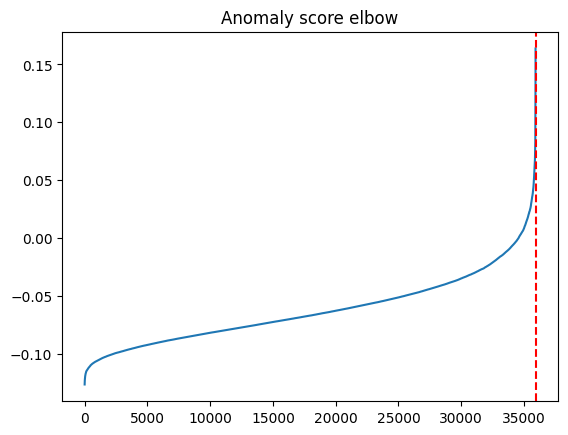

Estimated contamination: 0.01%
Isolation Forest removed 180 rows (0.50%)
Remaining rows: 35749


In [30]:
X_train_iqr = remove_outliers_iqr(X_train, 2.5)
find_elbow_contamination(X_train_iqr, "auto")
X_train_clean = remove_outliers_isoforest(X_train_iqr, contamination=0.005)


In [31]:
def align_y_with_filtered_X(X_original, X_filtered, y_original):
    """
    Aligns y to match filtered X rows (assuming pandas DataFrame and Series).
    Preserves index alignment.
    """
    if isinstance(X_original, pd.DataFrame) and isinstance(y_original, (pd.Series, pd.DataFrame)):
        return y_original.loc[X_filtered.index]
    else:
        raise ValueError("X must be a pandas DataFrame, and y must be a pandas Series or DataFrame with aligned indices.")

In [32]:
y_train_clean = align_y_with_filtered_X(X_train, X_train_clean, y_train)

## Exploratory Data Analysis

In [33]:
def histograms(data):
    """
    Function to plot histograms of the dataframe
    :param data: DataFrame
    :return: None
    """
    data.hist(figsize=(20, 20), bins=50, color='black')
    plt.suptitle('Histograms (50 bins) of all features', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()
    
if EDA_AND_VISUALIZATION:   
    histograms(data_raw)

In [34]:
if EDA_AND_VISUALIZATION:
    df_eda.describe(include="all")

In [35]:
if EDA_AND_VISUALIZATION:
    df_eda.info()
    print(df_eda['gender'].value_counts())
    print(df_eda['age_young_old'].value_counts())

In [36]:
# comparing the means of the features using groupbys

def table_grouped_by(df, group_by_col):
    grouped_by_y = df.groupby(group_by_col).mean().T
    table = PrettyTable()
    table.field_names = ["Feature"]+list(grouped_by_y.columns)
    for feature, values in zip(grouped_by_y.index, grouped_by_y.values):
        table.add_row([feature] + values.tolist())
    table.align = "r"
    table.align["Feature"] = "l"
    table.title = "Grouped by " + group_by_col.name
    print(table)

if EDA_AND_VISUALIZATION:    
    table_grouped_by(df_eda_num, df_eda['gender'])
    table_grouped_by(df_eda_num, df_eda['age'])
    table_grouped_by(df_eda_num, df_eda['age-gender'])
    table_grouped_by(df_eda_num, df_eda['age_young_old'])

In [37]:
# Correlation Matrix (save to zoom in)

def generate_correlation_matrix(df):
    plt.figure(figsize=(50, 50))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

if EDA_AND_VISUALIZATION:    
    generate_correlation_matrix(df_eda_num)
    # Save the figure
    plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.close()

In [38]:
# scatter plots
def scatter_plot(df, x_col, y_col):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue=df[['age', 'gender']].apply(tuple, axis=1), alpha=0.8)
    plt.title(f'Scatter plot of {x_col} vs {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

if EDA_AND_VISUALIZATION:
    # mfcc 
    # ....mfcc not multimodal
    scatter_plot(df_eda, 'mfcc_01_mean', 'mfcc_07_mean')
    scatter_plot(df_eda, 'mfcc_01_mean', 'spec_centroid_mean')
    # ....mfcc bimodal
    scatter_plot(df_eda, 'mfcc_02_mean', 'mfcc_04_mean')
    scatter_plot(df_eda, 'mfcc_02_mean', 'zcr_mean')


    # chroma differences in distances
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_02_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_05_mean')
    scatter_plot(df_eda, 'chroma_01_mean', 'chroma_11_mean')

    # spectral
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_bandwidth_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_1_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_4_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'spec_contrast_band_7_mean')
    scatter_plot(df_eda, 'spec_centroid_mean', 'zcr_mean')

    # temporal
    scatter_plot(df_eda, 'zcr_mean', 'rmse_mean')

## Preprocessing Pipeline

In [42]:
# Log transformation
def use_log(data, scale_by_min=False):
    assert np.min(data) >= 0, 'data contains negative or zero values at log transform'
    transformed = np.log(data)
    return transformed

col_to_log_transform = ['spec_contrast_band_7_mean', 'spec_contrast_band_7_std', 'rmse_mean', 'rmse_std']

# Defining Transformers
scl = StandardScaler()
log = FunctionTransformer(func=use_log, validate=False, kw_args={'scale_by_min': True}, feature_names_out='one-to-one')

# Defining Models
pca = PCA(n_components=0.95)
lda = LinearDiscriminantAnalysis()

# Pipelines
pipeline_log = Pipeline(steps=[
    ('log', log),
    ('scaler', scl)
])

pipeline_num = Pipeline(steps=[
    ('scaler', scl)
])

# Column selection
preprocessing = ColumnTransformer([
('log', pipeline_log, col_to_log_transform),
], remainder=pipeline_num)

preprocessing_pca = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('pca', pca)
    ]
)
preprocessing_lda = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('lda', lda)
    ]
)


In [43]:
if EDA_AND_VISUALIZATION:
    x_train_pca = preprocessing_pca.fit_transform(X_train)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_train_pca[:, 0], y=x_train_pca[:, 1], hue=y_train["age"], palette="hls", alpha=0.6)
    plt.title('Scatterplot of PC1 vs PC2')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Age')
    plt.show()

In [44]:
if EDA_AND_VISUALIZATION:
    lda = preprocessing_lda.named_steps['lda']

    coefficients = lda.coef_[0]
    imp_lda = pd.DataFrame(coefficients, index=X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

    table = PrettyTable()
    table.field_names = ["Feature", "Coefficient"]
    for row in zip(imp_lda.index, imp_lda['Coefficient']):
        feature = str(row[0])
        coef = float(row[1])
        table.add_row([feature, coef])
    print(table)


In [48]:
if FULL_RUN:
    preprocessed = preprocessing.fit_transform(X_train)
    features = preprocessing.get_feature_names_out()
    df = pd.DataFrame(preprocessed, columns=features)
    df.head()
    histograms(df)

## Initial Age Model Selection

In [49]:
def evaluate_models(y_true, y_pred_dict, figsize=(12, 8), expanded=True, label=None,binning=None):
    """
    Function to evaluate multiple models and compare their performance
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_dict : dict
        Dictionary of model predictions where keys are model names and values are predicted labels
        Example: {'Model1': y_pred1, 'Model2': y_pred2}
    figsize : tuple, optional
        Figure size for the visualizations, default is (12, 8)
    Returns:
    --------
    metrics_df : pandas DataFrame
        DataFrame containing performance metrics for all models
    """
    if binning:
        y_true_transformed = apply_binning(y_true,binning)
    else:
        y_true_transformed = y_true
    
    # Initialize a dictionary to store metrics
    metrics = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-score': []
    }
    
    if expanded:
        # Set up the plot for confusion matrices
        n_models = len(y_pred_dict)
        fig, axes = plt.subplots(1, n_models, figsize=figsize)
        if n_models == 1:
            axes = [axes]  # Convert to list for consistent indexing
    
    # Evaluate each model
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if binning:
            y_pred_transformed = apply_binning(y_pred,binning)
        else:
            y_pred_transformed = y_pred
        # Print classification report
        print(f"\n===== {model_name}: {label} =====")
        print("Classification Report:")
        print(classification_report(y_true_transformed, y_pred_transformed))
        
        # Store metrics
        metrics['Model'].append(model_name)
        metrics['Accuracy'].append(accuracy_score(y_true_transformed, y_pred_transformed))
        
        unique_labels = np.unique(y_true_transformed)
        # Handle binary and multi-class cases for precision, recall, and f1
        if len(np.unique(y_true_transformed)) == 2:
            # Binary classification
            metrics['Precision'].append(precision_score(y_true_transformed, y_pred_transformed, average='binary', pos_label=unique_labels[1]))
            metrics['Recall'].append(recall_score(y_true_transformed, y_pred_transformed, average='binary', pos_label=unique_labels[1]))
            metrics['F1-score'].append(f1_score(y_true_transformed, y_pred_transformed, average='binary', pos_label=unique_labels[1]))
        else:
            # Multi-class classification
            metrics['Precision'].append(precision_score(y_true_transformed, y_pred_transformed, average='weighted', labels=unique_labels))
            metrics['Recall'].append(recall_score(y_true_transformed, y_pred_transformed, average='weighted', labels=unique_labels))
            metrics['F1-score'].append(f1_score(y_true_transformed, y_pred_transformed, average='weighted', labels=unique_labels))
            
        if expanded:
            # Plot confusion matrix
            cm = confusion_matrix(y_true_transformed, y_pred_transformed)
            labels = sorted(set(y_true_transformed).union(set(y_pred_transformed)))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[i])
            axes[i].set_title(f'Confusion Matrix - {model_name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('True')
    
    if expanded:
        plt.tight_layout()
        plt.show()
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    
    if expanded:
        # Plot metrics comparison
        plt.figure(figsize=figsize)
        metrics_df_plot = metrics_df.set_index('Model')
        ax = metrics_df_plot.plot(kind='bar', figsize=figsize)
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

        plt.show()
    
    return metrics_df

In [50]:
def fit_pipeline_predict_evaluate(model_class, model_name, X_train=X_train_clean, y_train=y_train_clean['age_young_old'], X_comp=X_val, y_comp=y_val['age_young_old'], PCA=False, LDA=False, binning=None, multiclass=False):
    """
    Function to fit a pipeline, make predictions, and evaluate the model with optional weights.
    """
    assert not (PCA and LDA and multiclass), "PCA and LDA cannot be used together with multiclass."
    assert not (PCA and multiclass), "PCA cannot be used with multiclass."
    assert not (LDA and multiclass), "LDA cannot be used with multiclass."
    # Build pipelines
    pipeline = make_pipeline(clone(preprocessing), clone(model_class))
        
    # Fit the model
    print(f"Fitting {model_name}...")
    pipeline.fit(X_train, y_train)
    
    if multiclass:
        # Predict on training set
        print(f"Predicting on training set...")
        prd_train = pipeline.predict(X_train)[:, 1]
        # Predict on validation set
        print(f"Predicting on validation set...")
        prd_val = pipeline.predict(X_comp)[:, 1]
    else:
        # Predict on training set
        print(f"Predicting on training set...")
        prd_train = pipeline.predict(X_train)
        # Predict on validation set
        print(f"Predicting on comparison set...")
        prd_val = pipeline.predict(X_comp)

    # Same Pipeline for PCA and LDA if selected
    if PCA:
        model_pca = clone(model_class)
        pipeline_pca = make_pipeline(preprocessing_pca, model_pca)
        pipeline_pca.fit(X_train, y_train)
        prd_train_pca = pipeline_pca.predict(X_train)
        prd_val_pca = pipeline_pca.predict(X_comp)

    if LDA:
        model_lda = clone(model_class)
        pipeline_lda = make_pipeline(preprocessing_lda, model_lda)
        pipeline_lda.fit(X_train, y_train)
        prd_train_lda = pipeline_lda.predict(X_train)
        prd_val_lda = pipeline_lda.predict(X_comp)

    if PCA and LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
            f'{model_name}_lda': prd_val_lda,
        }
    elif PCA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_pca': prd_train_pca,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_pca': prd_val_pca,
        }
    elif LDA:
        evaluate_train = {
            f'{model_name}': prd_train,
            f'{model_name}_lda': prd_train_lda,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
            f'{model_name}_lda': prd_val_lda,
        }
    else:
        evaluate_train = {
            f'{model_name}': prd_train,
        }
        evaluate_val = {
            f'{model_name}': prd_val,
        }
    
    if multiclass:
        y_train= y_train[:, 1]
        y_comp= y_comp[:, 1]

    # Evaluate on training predictions
    print(f"Evaluating {model_name} on training set...")
    evaluate_models(y_train, evaluate_train, (12, 8), False, "Training Set", binning=binning)

    # Evaluate on comparison predictions
    print(f"Evaluating {model_name} on comparison set...")
    return evaluate_models(y_comp, evaluate_val, (12, 8), True, "Comparison Set", binning=binning)

Fitting Logistic Regression...
Predicting on training set...
Predicting on comparison set...
Evaluating Logistic Regression on training set...

===== Logistic Regression: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.66      0.64     17860
       young       0.64      0.61      0.63     17889

    accuracy                           0.63     35749
   macro avg       0.64      0.63      0.63     35749
weighted avg       0.64      0.63      0.63     35749


===== Logistic Regression_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.62      0.65      0.63     17860
       young       0.63      0.60      0.62     17889

    accuracy                           0.63     35749
   macro avg       0.63      0.63      0.62     35749
weighted avg       0.63      0.63      0.62     35749


===== Logistic Regression_lda: Training Set =====
Classifi

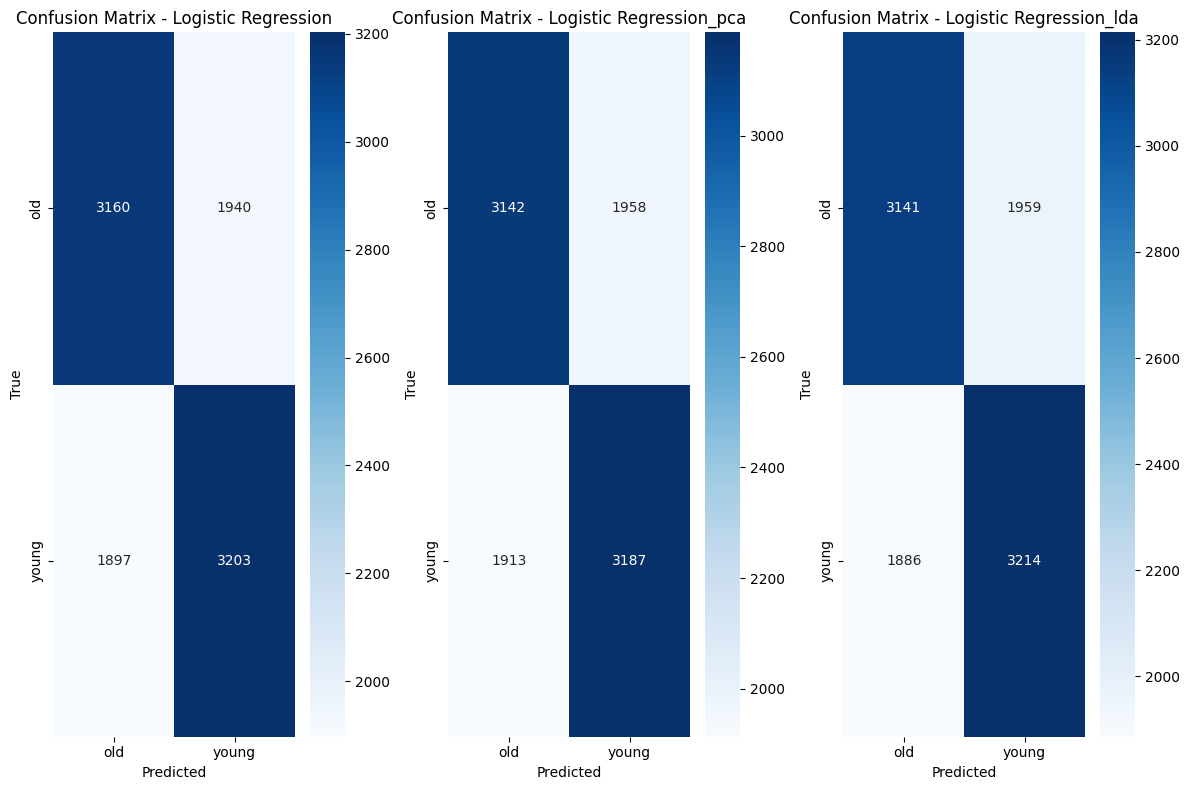

<Figure size 1200x800 with 0 Axes>

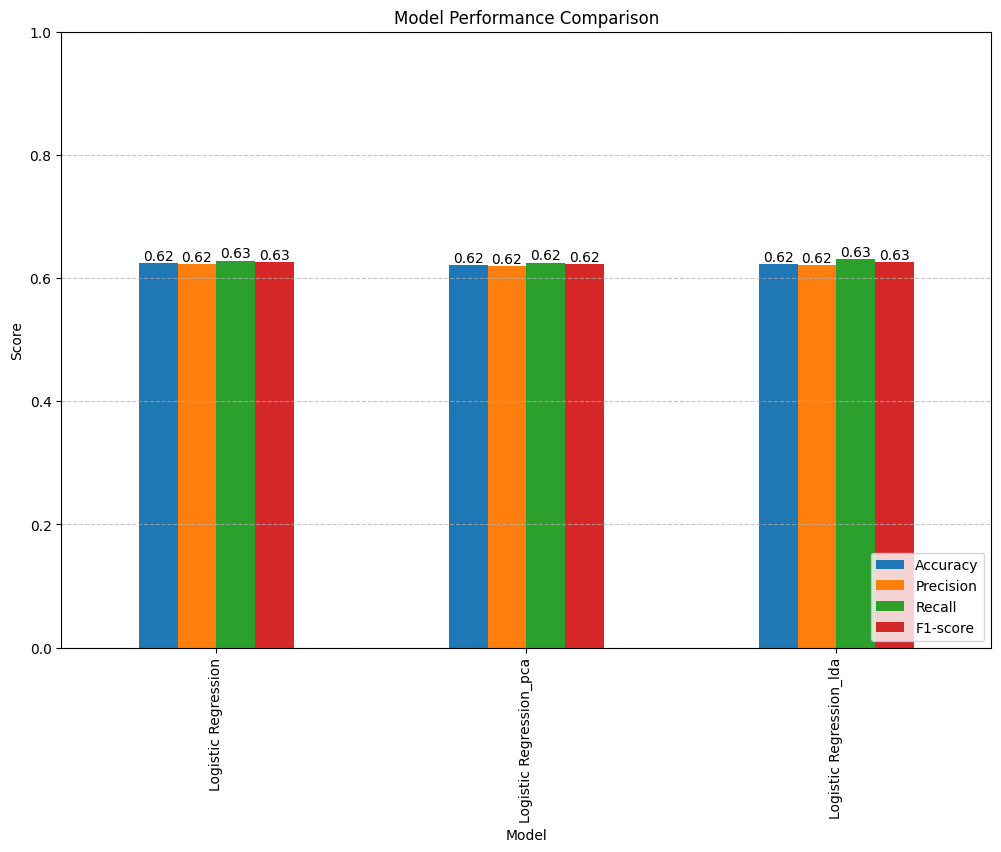

In [51]:
logistic_metrics=fit_pipeline_predict_evaluate(LogisticRegression(solver='lbfgs', max_iter=5000, C=0.01, random_state=27),
        "Logistic Regression", PCA=True, LDA=True)

Fitting SVC...
Predicting on training set...
Predicting on comparison set...
Evaluating SVC on training set...

===== SVC: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.66      0.64     20400
       young       0.64      0.61      0.62     20400

    accuracy                           0.63     40800
   macro avg       0.63      0.63      0.63     40800
weighted avg       0.63      0.63      0.63     40800


===== SVC_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.62      0.65      0.63     20400
       young       0.63      0.60      0.61     20400

    accuracy                           0.62     40800
   macro avg       0.62      0.62      0.62     40800
weighted avg       0.62      0.62      0.62     40800


===== SVC_lda: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         o

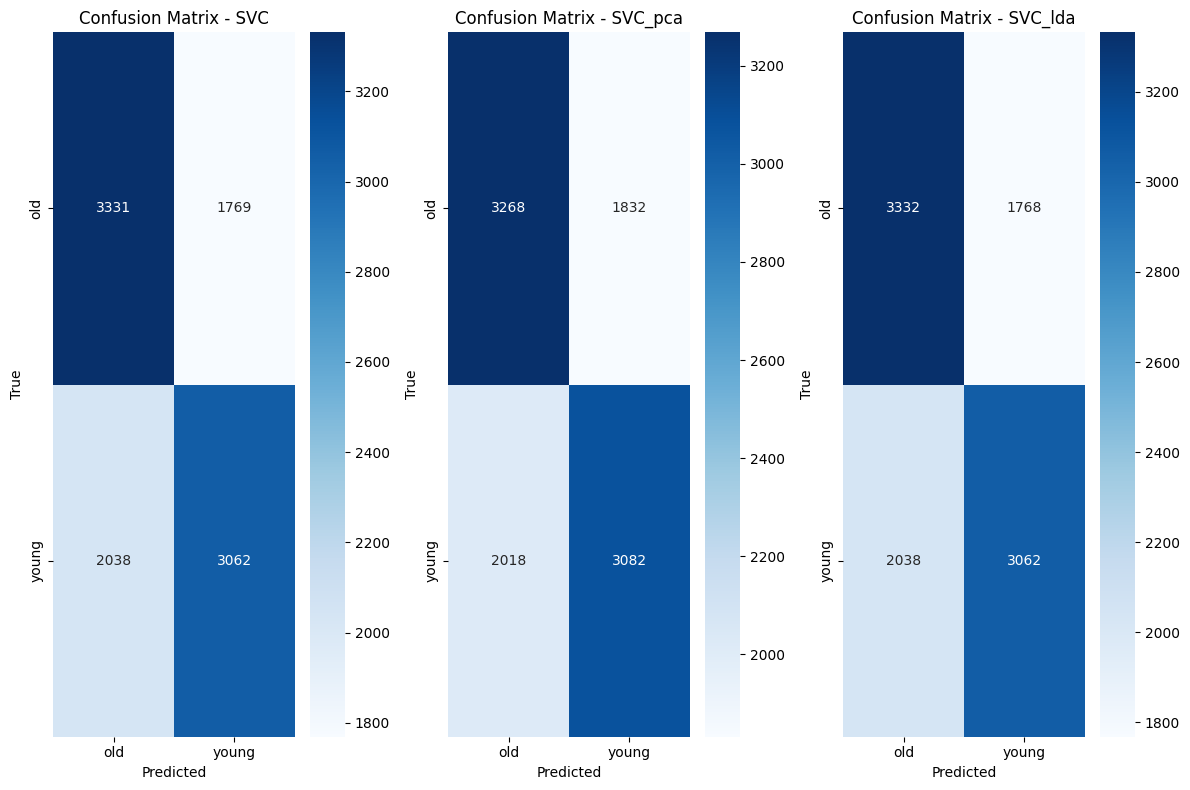

<Figure size 1000x600 with 0 Axes>

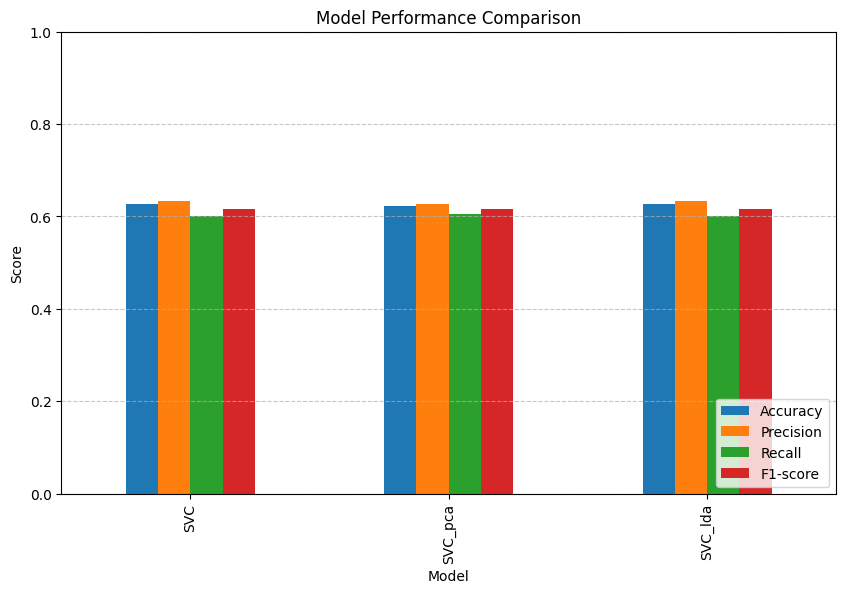

In [70]:
svc_metrics=fit_pipeline_predict_evaluate(LinearSVC(random_state=27, max_iter=1000), "SVC", PCA=True, LDA=True)

Fitting KNeighbors Classifier...
Predicting on training set...
Predicting on comparison set...
Evaluating KNeighbors Classifier on training set...

===== KNeighbors Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.71      0.83      0.77     17860
       young       0.80      0.67      0.73     17889

    accuracy                           0.75     35749
   macro avg       0.76      0.75      0.75     35749
weighted avg       0.76      0.75      0.75     35749


===== KNeighbors Classifier_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.71      0.82      0.76     17860
       young       0.79      0.67      0.72     17889

    accuracy                           0.75     35749
   macro avg       0.75      0.75      0.74     35749
weighted avg       0.75      0.75      0.74     35749


===== KNeighbors Classifier_lda: Training Set ====

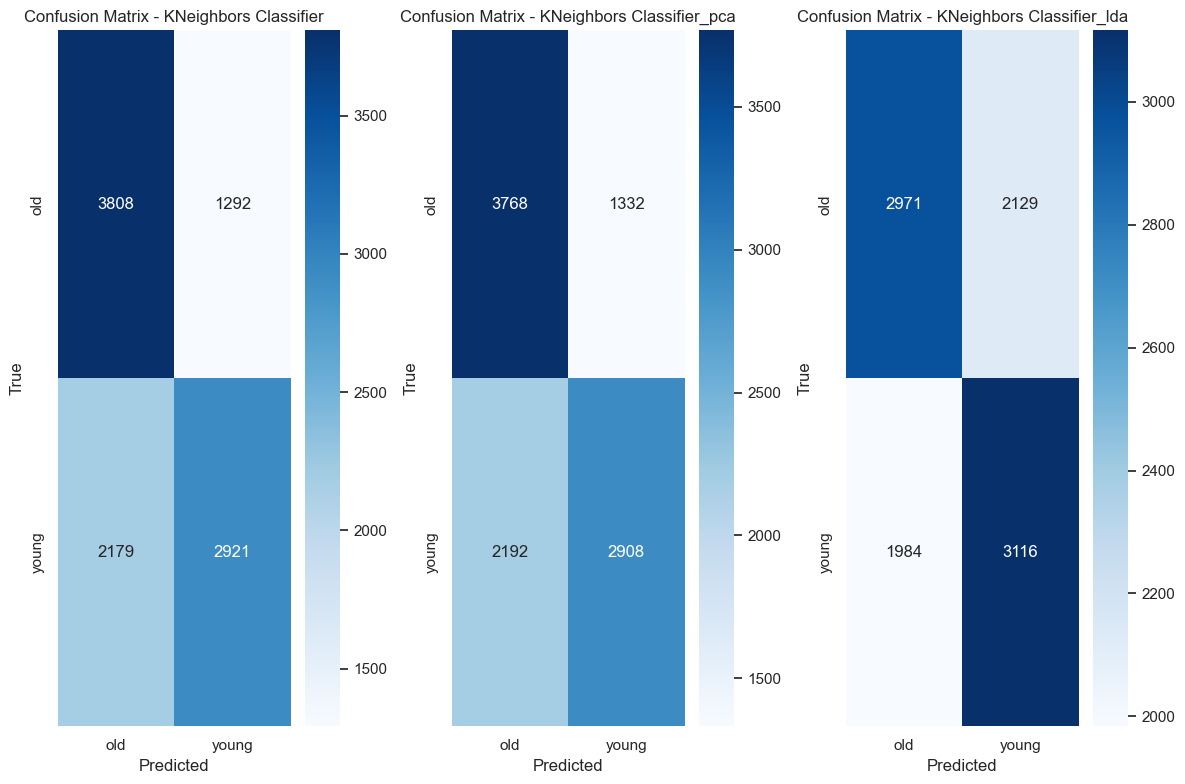

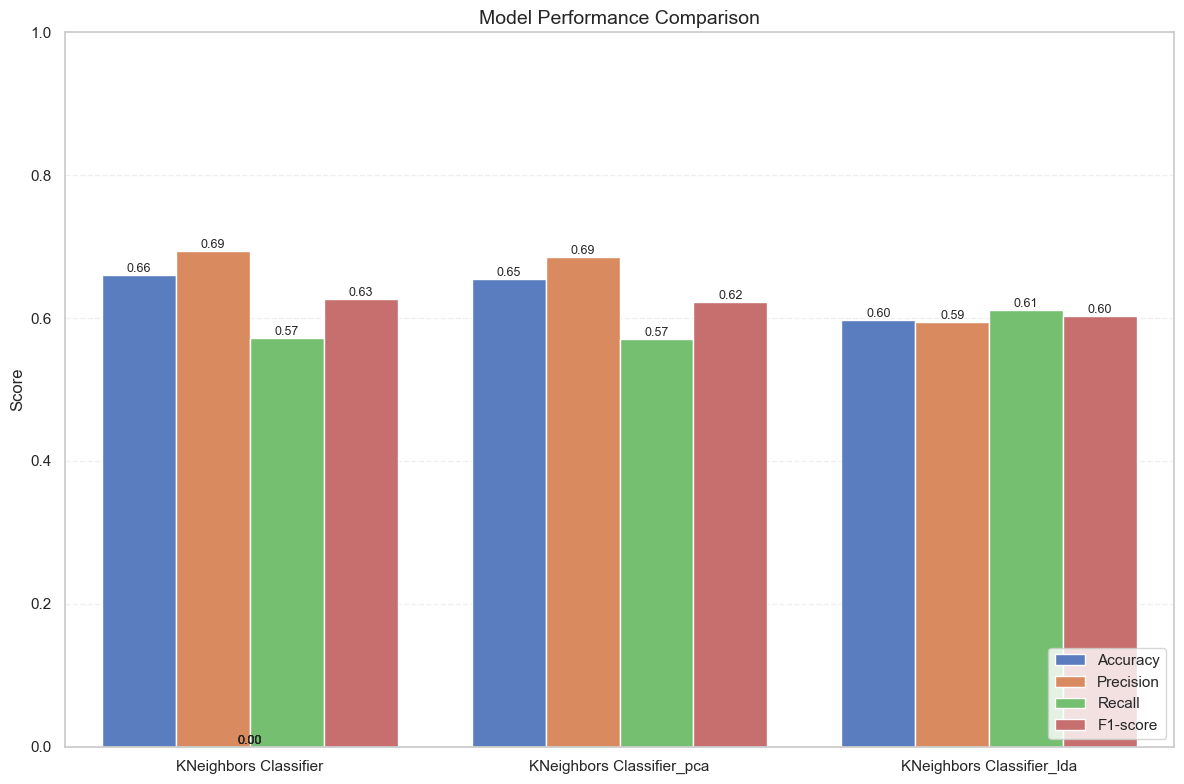

In [173]:
kneighbors_metrics=fit_pipeline_predict_evaluate(KNeighborsClassifier(n_neighbors=11), "KNeighbors Classifier", LDA=True, PCA=True)

Fitting Random Forest Classifier...
Predicting on training set...
Predicting on comparison set...
Evaluating Random Forest Classifier on training set...

===== Random Forest Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       1.00      1.00      1.00     17860
       young       1.00      1.00      1.00     17889

    accuracy                           1.00     35749
   macro avg       1.00      1.00      1.00     35749
weighted avg       1.00      1.00      1.00     35749


===== Random Forest Classifier_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       1.00      1.00      1.00     17860
       young       1.00      1.00      1.00     17889

    accuracy                           1.00     35749
   macro avg       1.00      1.00      1.00     35749
weighted avg       1.00      1.00      1.00     35749


===== Random Forest Classifier_lda: Tr

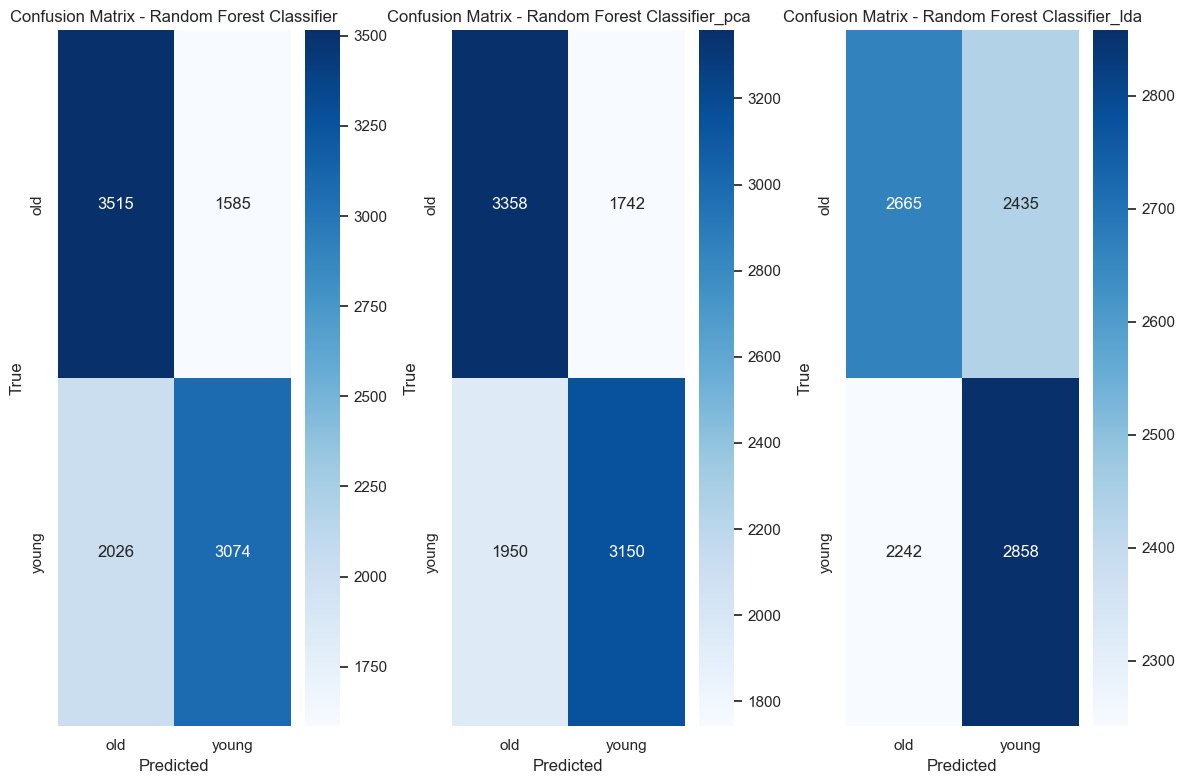

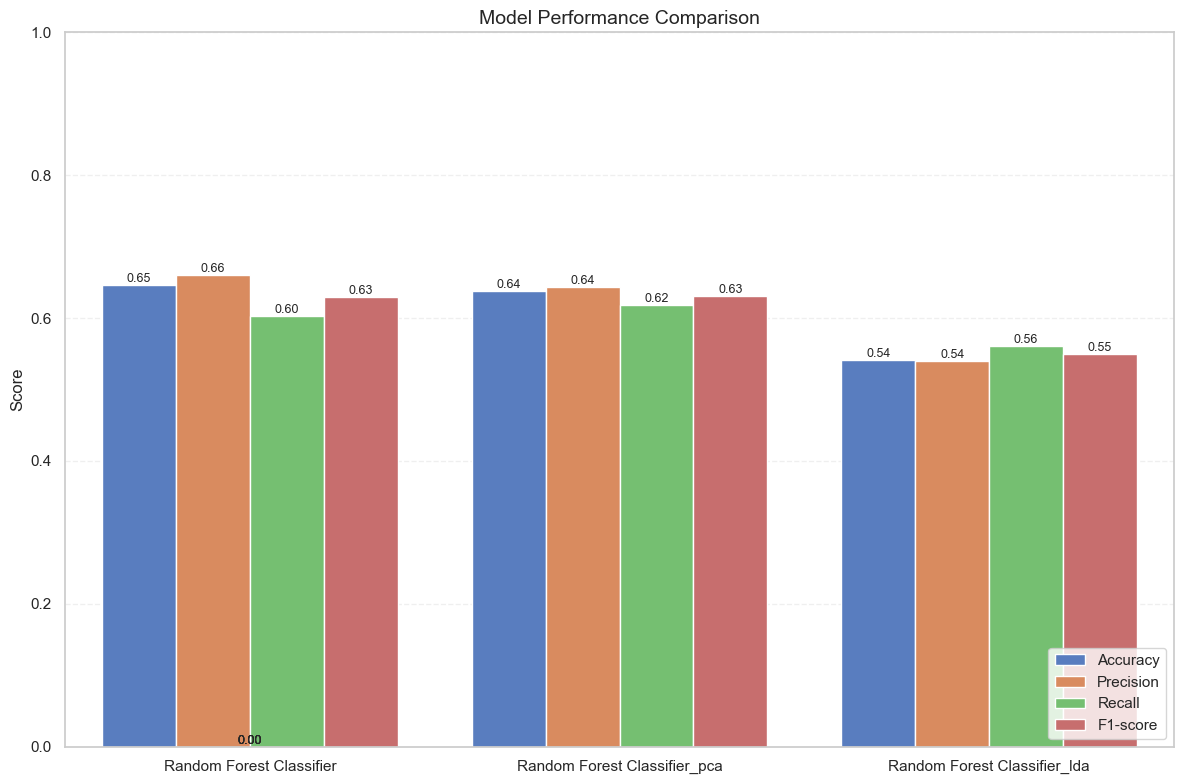

In [172]:
rand_forest_metrics=fit_pipeline_predict_evaluate(RandomForestClassifier(n_estimators=100,
                                                                         max_features="sqrt", random_state=27)
, "Random Forest Classifier",  PCA=True, LDA=True)

Fitting Gradient Boosting Classifier...
Predicting on training set...
Predicting on comparison set...
Evaluating Gradient Boosting Classifier on training set...

===== Gradient Boosting Classifier: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.83      0.88      0.85     17860
       young       0.87      0.83      0.85     17889

    accuracy                           0.85     35749
   macro avg       0.85      0.85      0.85     35749
weighted avg       0.85      0.85      0.85     35749

Evaluating Gradient Boosting Classifier on comparison set...

===== Gradient Boosting Classifier: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.64      0.66      0.65      5100
       young       0.65      0.63      0.64      5100

    accuracy                           0.65     10200
   macro avg       0.65      0.65      0.65     10200
weighted avg       

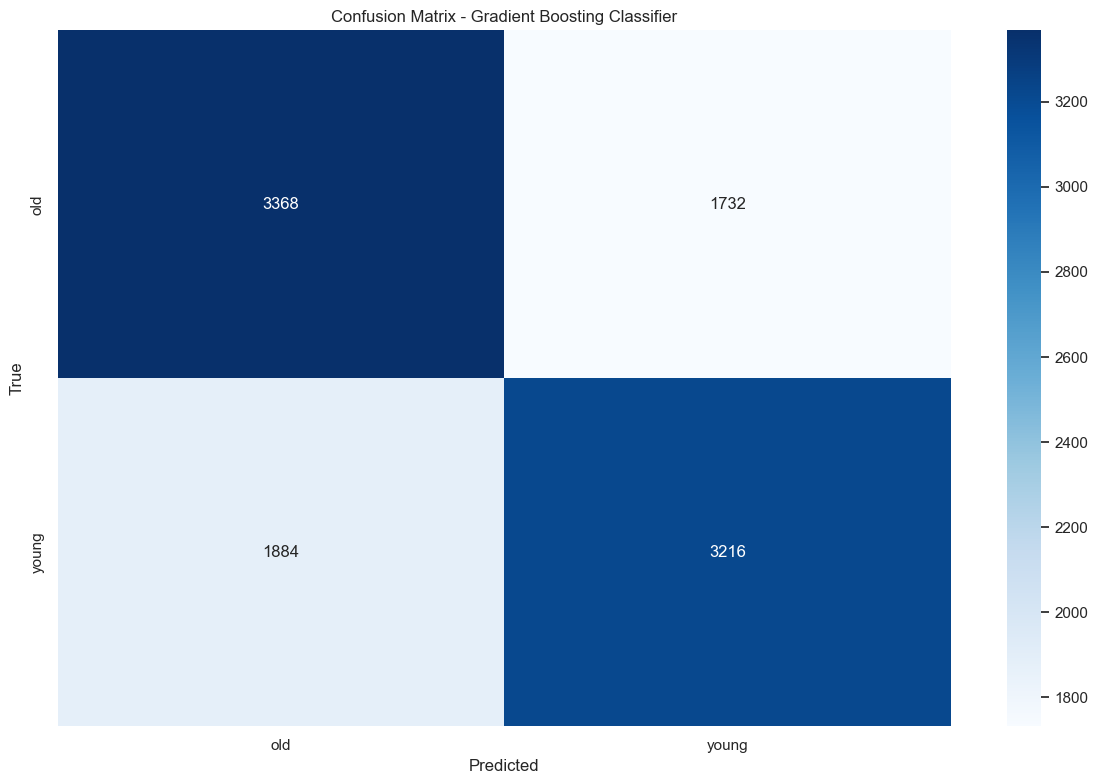

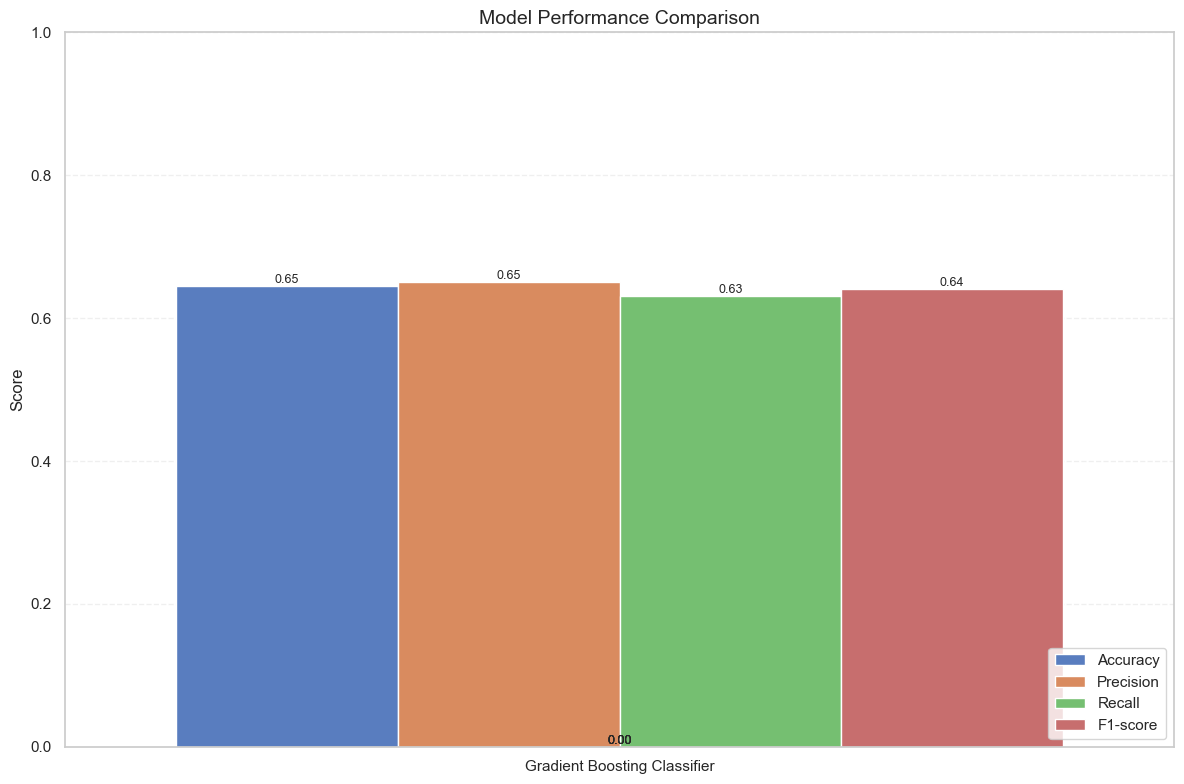

In [170]:
gradient_boosting_metrics=fit_pipeline_predict_evaluate(HistGradientBoostingClassifier(
 max_iter=600,      
    random_state=27), "Gradient Boosting Classifier")

Fitting MLP...
Predicting on training set...
Predicting on comparison set...
Evaluating MLP on training set...

===== MLP: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72     17889
           1       0.72      0.73      0.72     17860

    accuracy                           0.72     35749
   macro avg       0.72      0.72      0.72     35749
weighted avg       0.72      0.72      0.72     35749


===== MLP_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     17889
           1       0.73      0.77      0.75     17860

    accuracy                           0.75     35749
   macro avg       0.75      0.75      0.75     35749
weighted avg       0.75      0.75      0.75     35749


===== MLP_lda: Training Set =====
Classification Report:
              precision    recall  f1-score   support

          

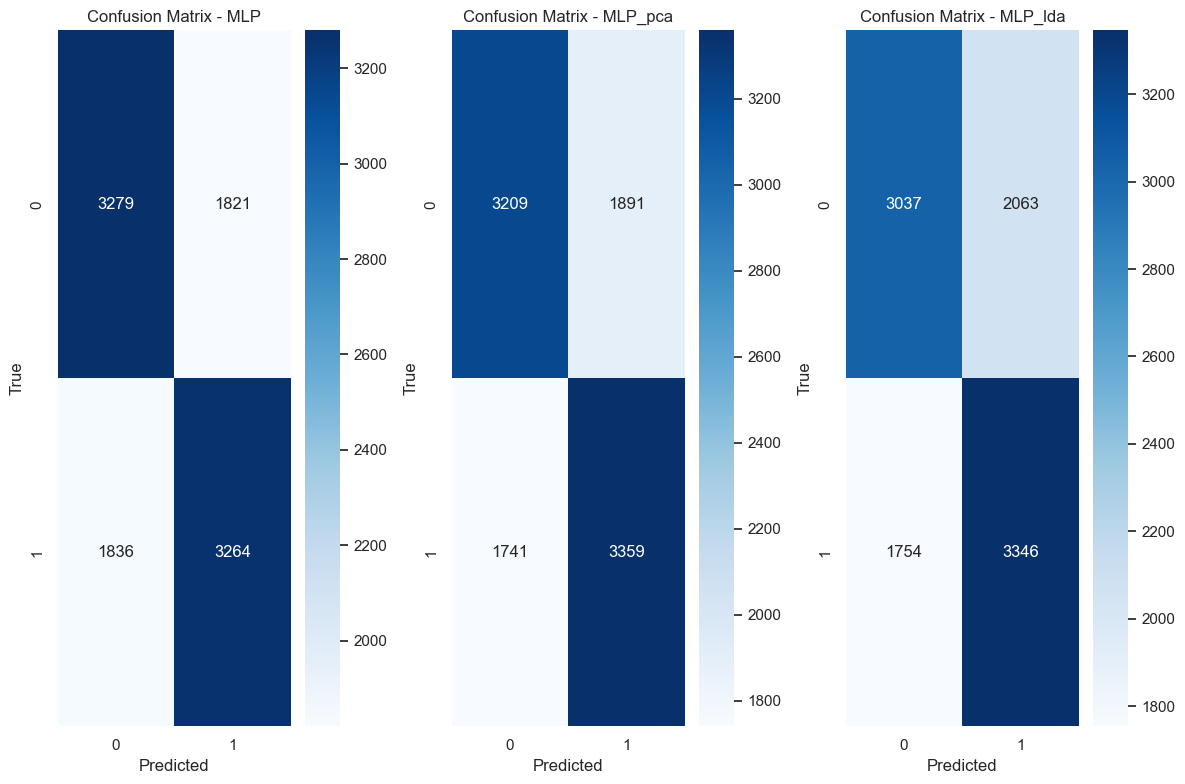

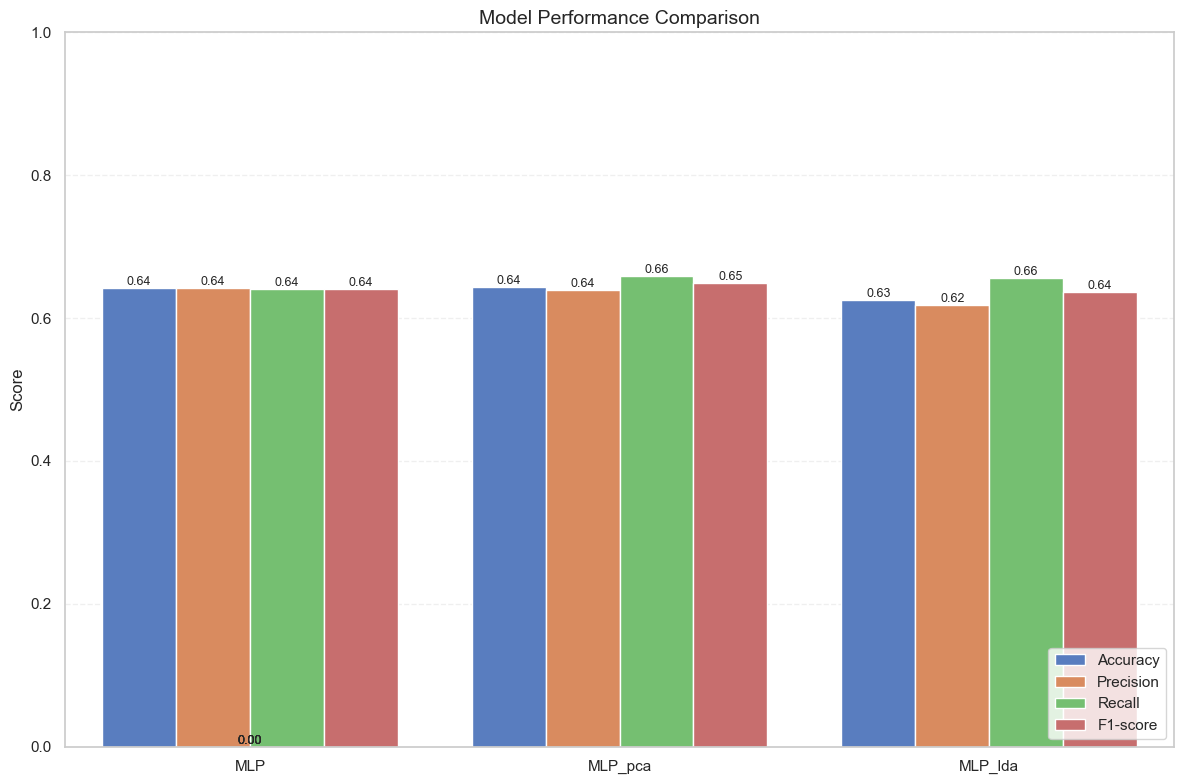

In [176]:
mlp_metrics=fit_pipeline_predict_evaluate(MLPClassifier(hidden_layer_sizes= (64, 32), learning_rate_init=0.001,  max_iter=1000,
        random_state=27,learning_rate='adaptive', early_stopping=True,
        validation_fraction=0.1), "MLP", PCA=True, LDA=True, y_train=y_train_clean['age_young_old_encoded'], y_comp=y_val['age_young_old_encoded'])

Fitting Multi Output...
Predicting on training set...
Predicting on validation set...
Evaluating Multi Output on training set...

===== Multi Output: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17889
         1.0       1.00      1.00      1.00     17860

    accuracy                           1.00     35749
   macro avg       1.00      1.00      1.00     35749
weighted avg       1.00      1.00      1.00     35749

Evaluating Multi Output on comparison set...

===== Multi Output: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63      5100
         1.0       0.64      0.70      0.67      5100

    accuracy                           0.65     10200
   macro avg       0.65      0.65      0.65     10200
weighted avg       0.65      0.65      0.65     10200



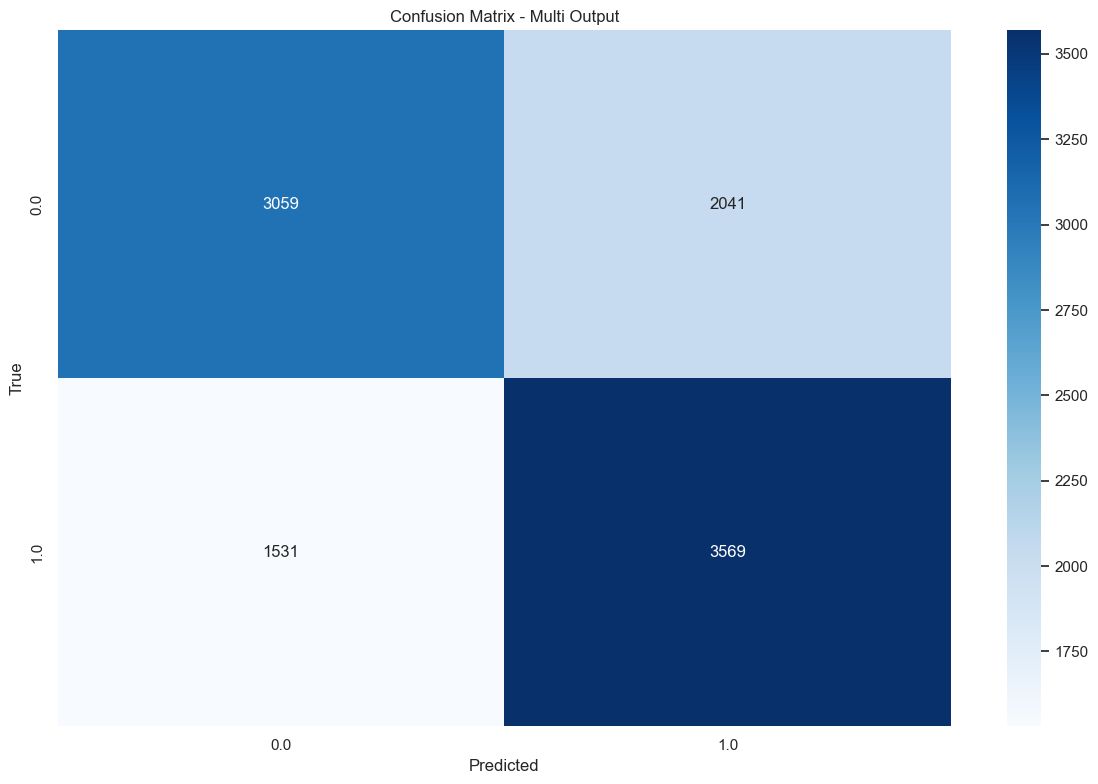

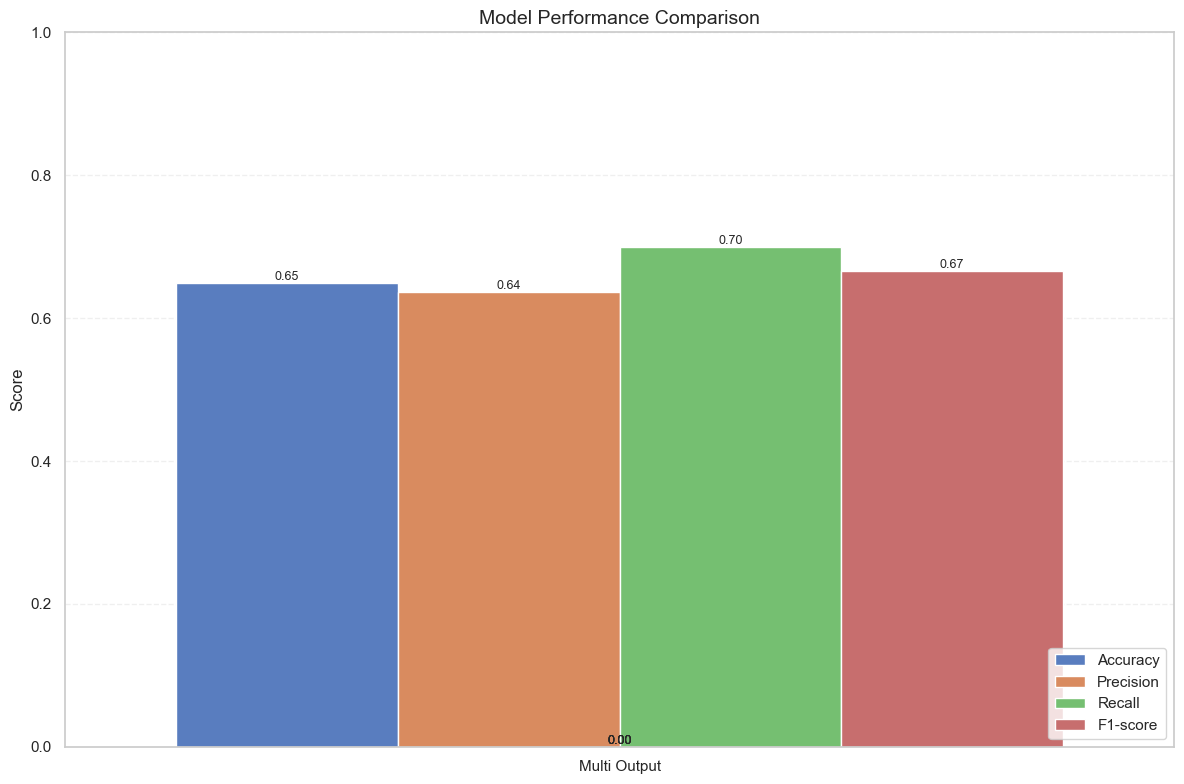

In [177]:
y_train_multi = np.column_stack((y_train_clean["age"], y_train_clean["age_young_old_encoded"]))
y_val_multi = np.column_stack((y_val["age"], y_val["age_young_old_encoded"]))

base_clf = RandomForestClassifier(
    n_estimators=300,          
    max_depth=20, min_samples_split=2,       
    min_samples_leaf=1, max_features='sqrt',       
    n_jobs=-1, random_state=27)

multi_clf = MultiOutputClassifier(base_clf)

multi_output_metrics=fit_pipeline_predict_evaluate( multi_clf, "Multi Output", y_train=y_train_multi, y_comp=y_val_multi, multiclass=True)

In [ ]:
def compare_selected_metrics(*metrics_dfs, selected_columns=None, exclude_suffixes=('pca', 'lda'), fig_size=(12, 8)):
    """
    Compare selected metrics from multiple model evaluation DataFrames.

    Parameters:
        *metrics_dfs: Variable number of pandas DataFrames containing model metrics with a 'Model' column.
        selected_columns (list of str): Metrics to include in the comparison. Defaults to common classification metrics.
        exclude_suffixes (tuple of str): Model name suffixes to exclude (e.g., 'pca', 'lda').
    """
    
    # Default metrics to display if not provided
    if selected_columns is None:
        selected_columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Combine all DataFrames into one
    combined_metrics = pd.concat(
        [df.set_index('Model') for df in metrics_dfs],
        axis=0
    )

    # Optionally filter out models by suffix
    if exclude_suffixes:
        combined_metrics = combined_metrics[~combined_metrics.index.str.endswith(exclude_suffixes)]

    # Select only relevant columns
    selected_metrics = combined_metrics[selected_columns]

    # Plot
    plt.figure(figsize=fig_size)
    ax = selected_metrics.plot(kind='bar', figsize=fig_size)
    plt.title('Comparison of Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

    plt.show()


<Figure size 2000x1600 with 0 Axes>

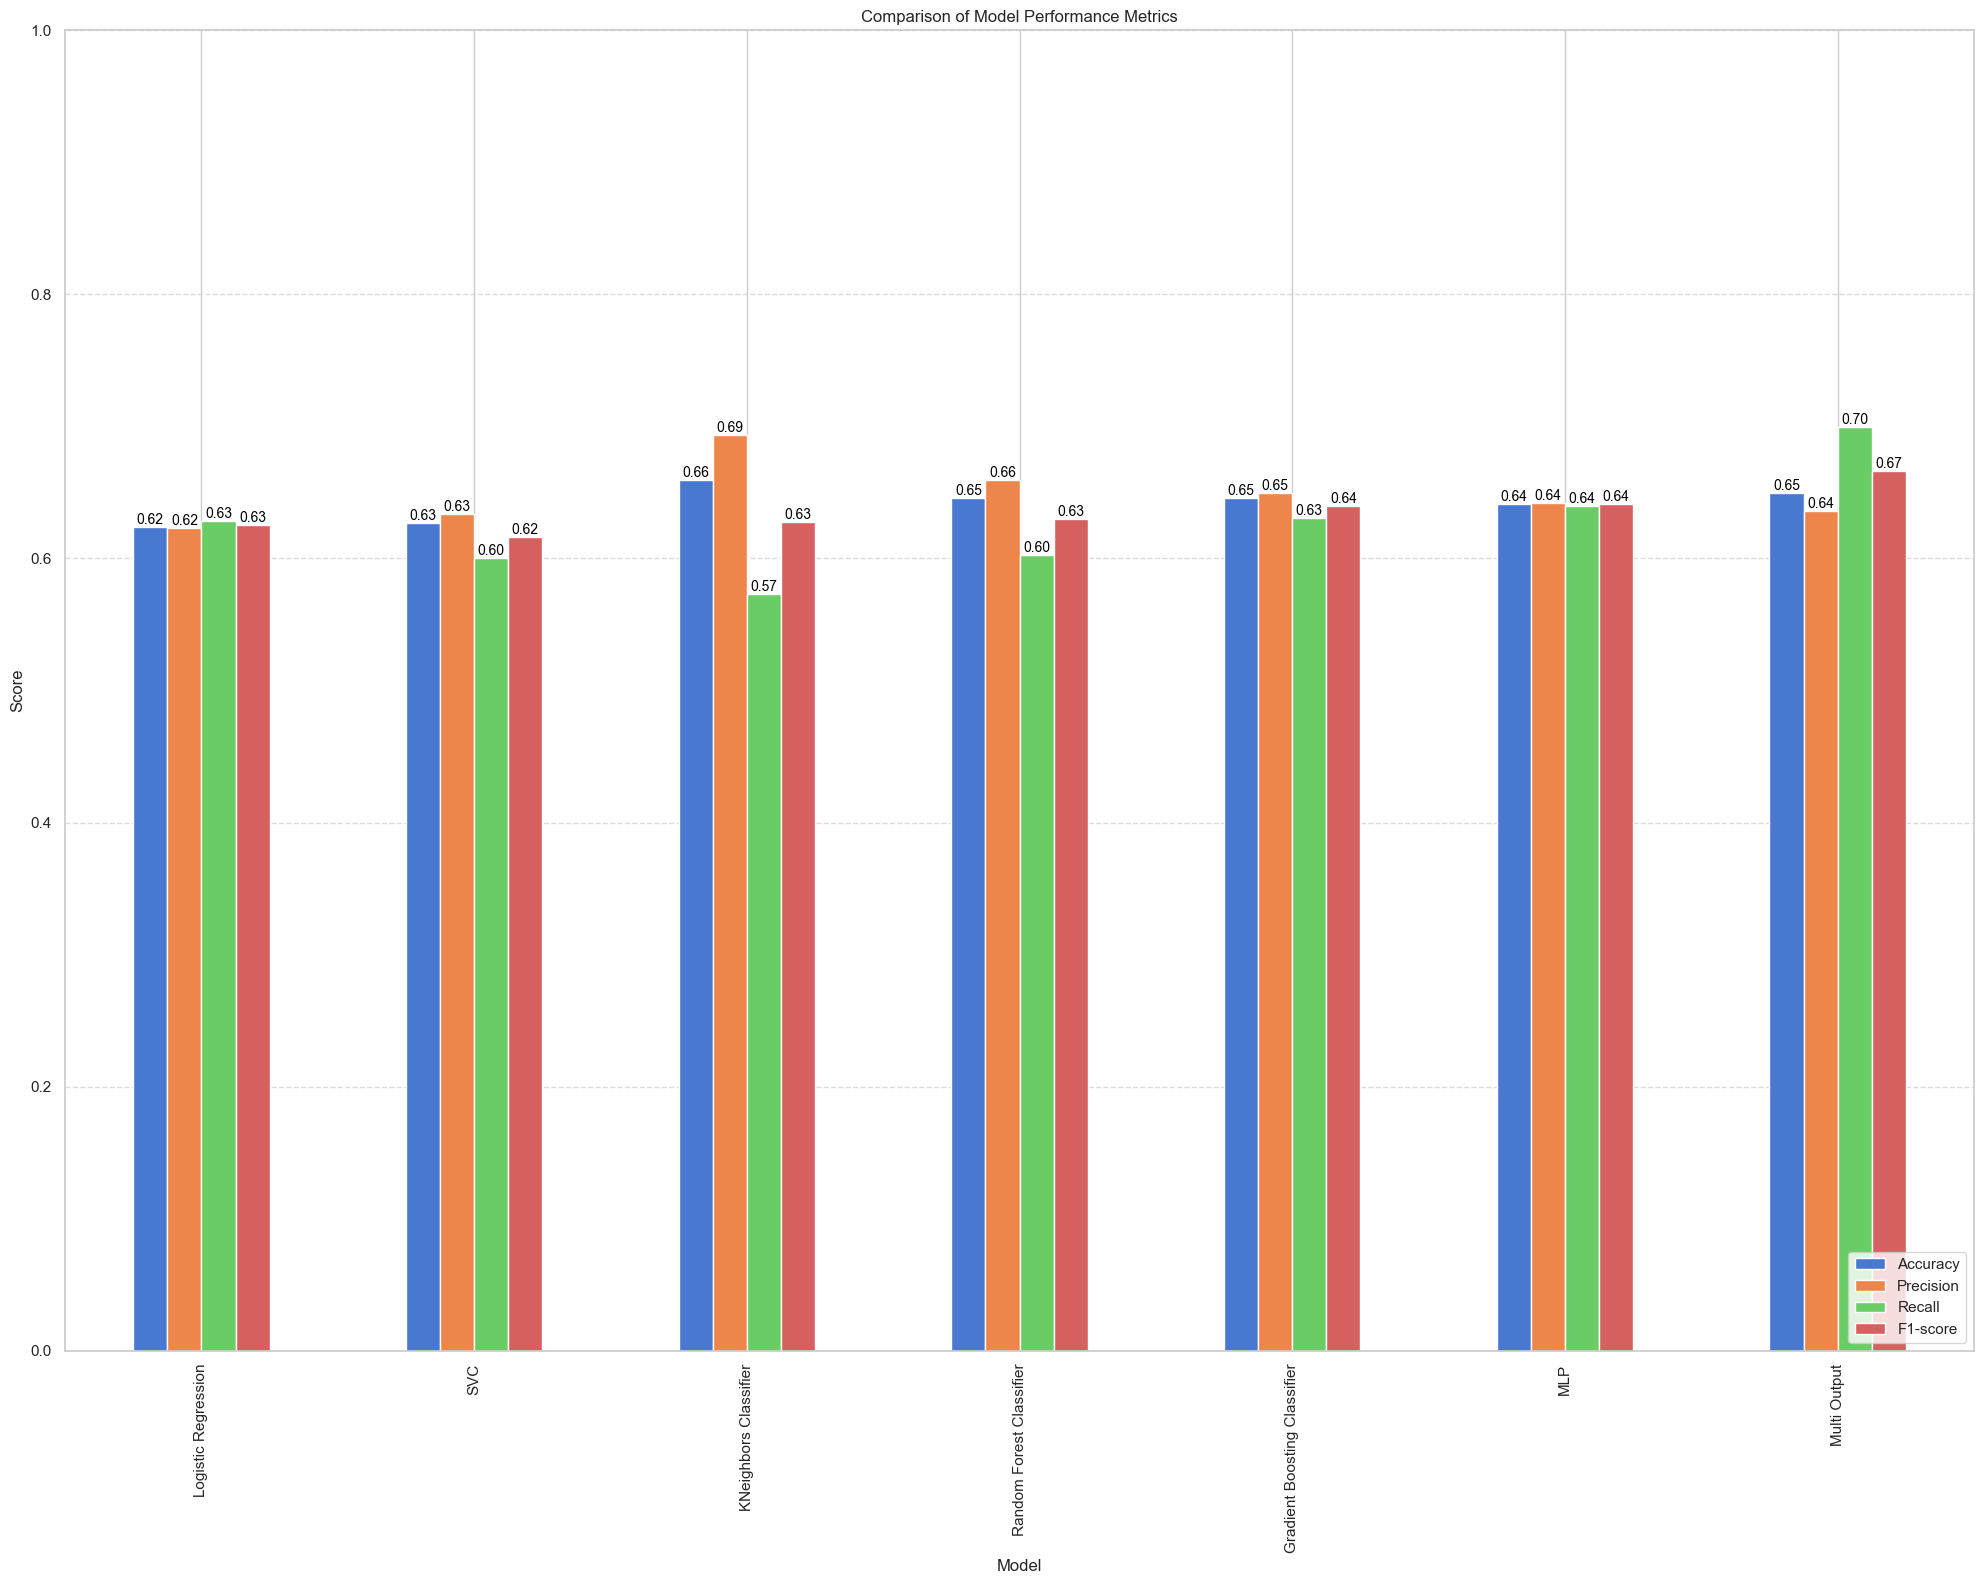

In [180]:
compare_selected_metrics(
    logistic_metrics,
    svc_metrics,
    kneighbors_metrics,
    rand_forest_metrics,
    gradient_boosting_metrics,
    mlp_metrics,
    multi_output_metrics,
    selected_columns=['Accuracy', 'Precision', 'Recall', 'F1-score'],
    fig_size=(20, 16)
)

## Gender Prediction

In [79]:
# Gender separated data
X_train_male = X_train_clean[y_train_clean['gender'] == 'male_masculine']
y_train_male = y_train_clean[y_train_clean['gender'] == 'male_masculine']
X_train_female = X_train_clean[y_train_clean['gender'] == 'female_feminine']
y_train_female = y_train_clean[y_train_clean['gender'] == 'female_feminine']
X_val_male = X_val[y_val['gender'] == 'male_masculine']
y_val_male = y_val[y_val['gender'] == 'male_masculine']
X_val_female = X_val[y_val['gender'] == 'female_feminine']
y_val_female = y_val[y_val['gender'] == 'female_feminine']

**ADD SOME MODELS FROM ANALYSIS GENDER**

Fitting RandomForest_Gender...
Predicting on training set...
Predicting on comparison set...
Evaluating RandomForest_Gender on training set...

===== RandomForest_Gender: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15465
           1       1.00      1.00      1.00     20284

    accuracy                           1.00     35749
   macro avg       1.00      1.00      1.00     35749
weighted avg       1.00      1.00      1.00     35749

Evaluating RandomForest_Gender on comparison set...

===== RandomForest_Gender: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4502
           1       0.88      0.89      0.88      5698

    accuracy                           0.87     10200
   macro avg       0.87      0.87      0.87     10200
weighted avg       0.87      0.87      0.87     10200



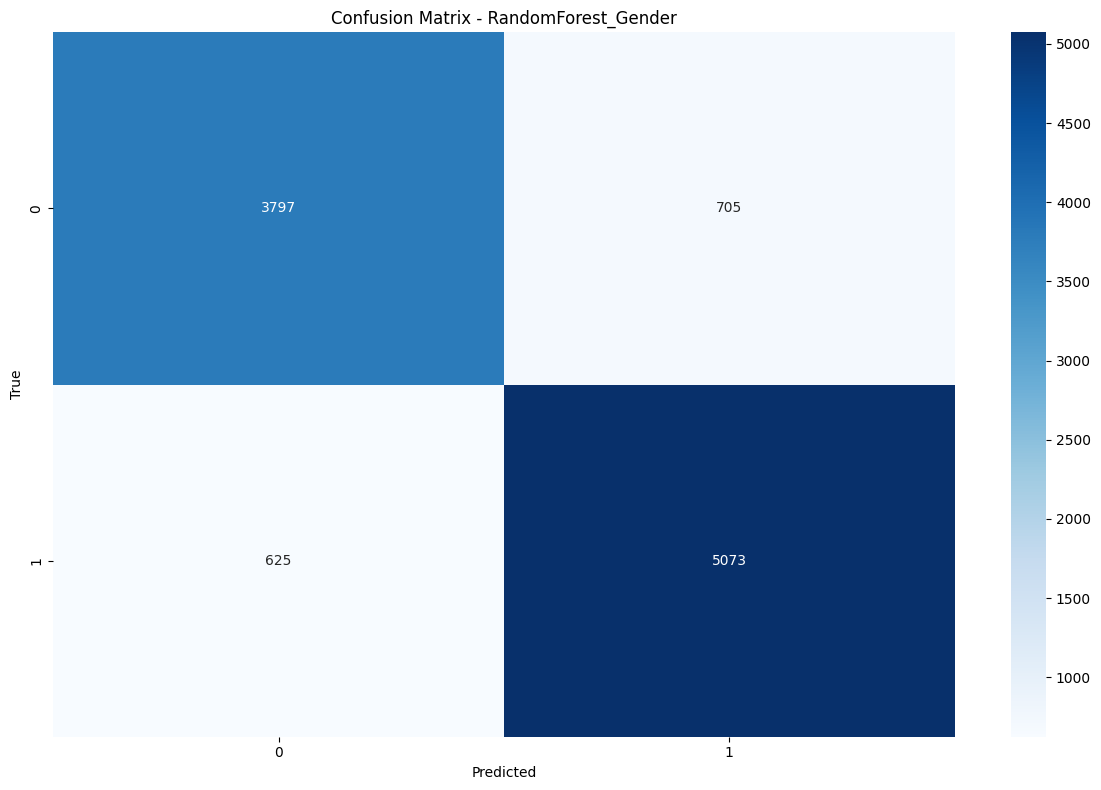

<Figure size 1200x800 with 0 Axes>

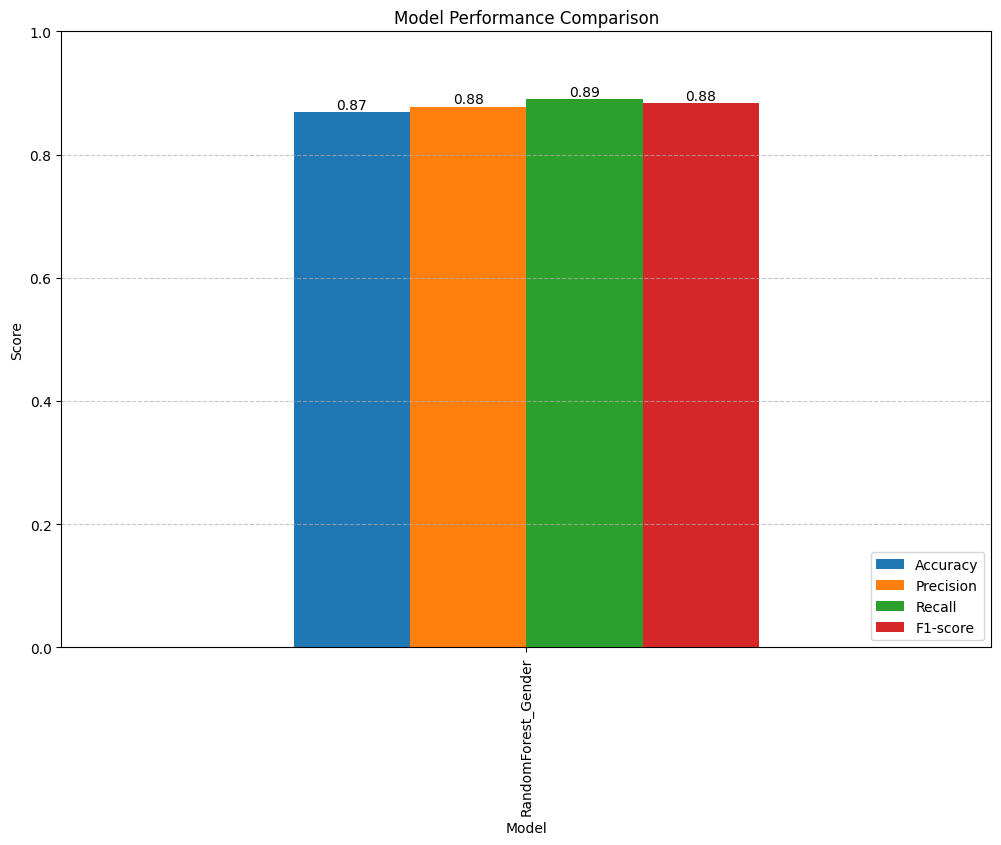

In [58]:
from sklearn.ensemble import RandomForestClassifier

rf_gender_metrics = fit_pipeline_predict_evaluate(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=27,
        n_jobs=-1
    ),
    model_name="RandomForest_Gender",
    y_train=y_train_clean['gender_encoded'],
    y_comp=y_val['gender_encoded']
)

Fitting MLP_Gender...
Predicting on training set...
Predicting on comparison set...
Evaluating MLP_Gender on training set...

===== MLP_Gender: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     15465
           1       0.95      0.95      0.95     20284

    accuracy                           0.95     35749
   macro avg       0.94      0.94      0.94     35749
weighted avg       0.95      0.95      0.95     35749


===== MLP_Gender_pca: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     15465
           1       0.94      0.95      0.95     20284

    accuracy                           0.94     35749
   macro avg       0.94      0.94      0.94     35749
weighted avg       0.94      0.94      0.94     35749


===== MLP_Gender_lda: Training Set =====
Classification Report:
              precision    rec

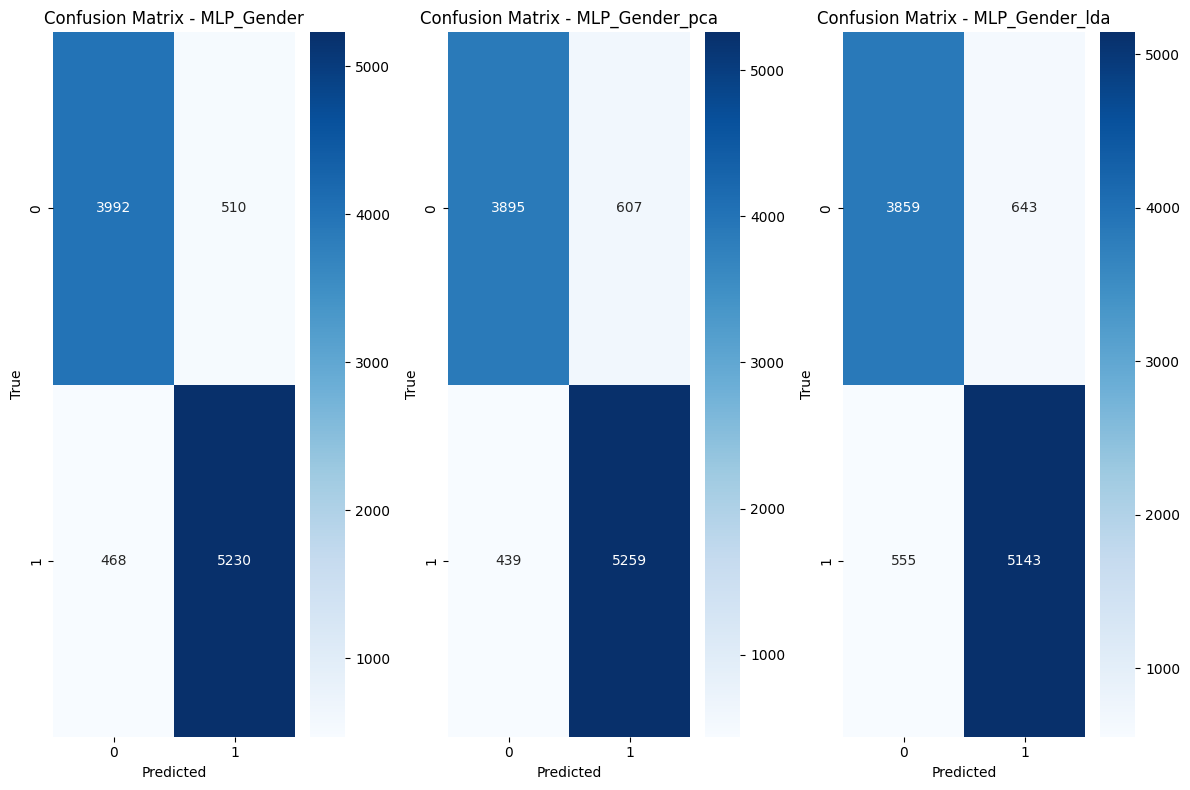

<Figure size 1200x800 with 0 Axes>

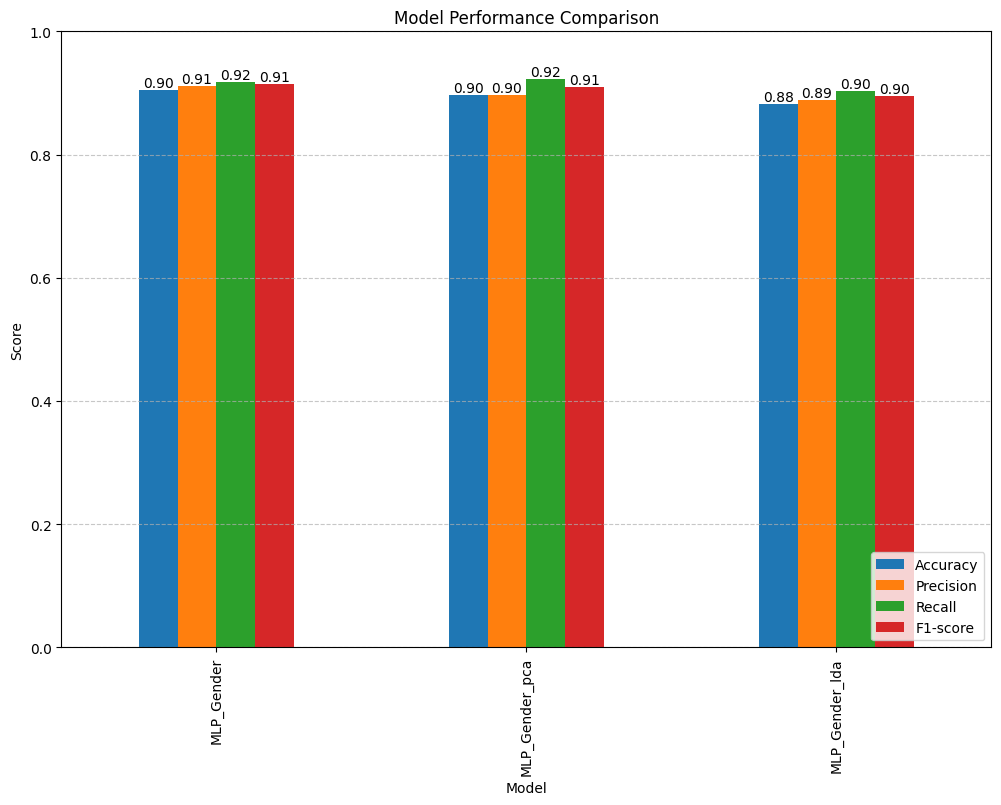

In [59]:
mlp_gender_metrics = fit_pipeline_predict_evaluate(
    MLPClassifier(
        hidden_layer_sizes=(64, 32),
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=27,
        learning_rate='adaptive',
        early_stopping=True,
        validation_fraction=0.1
    ),
    model_name="MLP_Gender",
    PCA=True,
    LDA=True,
    y_train=y_train_clean['gender_encoded'],
    y_comp=y_val['gender_encoded']
)

## Grid Search

In [62]:
def optimize_via_grid_search(
    model_class,model_name, param_grid,
    X_train=X_train_clean, y_train=y_train_clean, X_val=X_val, y_val=y_val, y_parameter="age_young_old_encoded"
):
    """
    Grid search optimization

    Parameters
    ----------
    model_class: sklearn estimator
        Class of the model to be optimized
    model_name : str
        Name of the model
    param_grid : dict
        Grid search parameters for the model
    X_train, X_val : pd.DataFrame
        Feature data for training and validation
    y_train, y_val : pd.DataFrame
        Must include the y_parameter column
    y_parameter : str
        The column name of the target variable in y_train and y_val

    Returns
    -------
    best_model : sklearn estimator
    evaluate_train : dict
    evaluate_val : dict
    results_df_sorted : pd.DataFrame
    """

    model=clone(model_class)
    
    pipeline = Pipeline([
        ('preprocessing', preprocessing),
        (model_name, model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=3,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1,
    )

    print(f"Starting grid search for {model_name} (predicting {y_parameter})...")
    grid_search.fit(X_train, y_train[y_parameter])

    print(f"\nBest Parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_

    # Detailed results
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
    display_cols = [col for col in results_df.columns if col.startswith("param_")]
    display_cols += ['mean_test_score', 'std_test_score']
    print("\nTop 5 configurations:")
    print(results_df_sorted[display_cols].head())

    # Predictions
    prd_train = best_model.predict(X_train)
    prd_val = best_model.predict(X_val)

    evaluate_train = {model_name: prd_train}
    evaluate_val = {model_name: prd_val}
    
    print("\nEvaluating MLP on training set...")
    train_result=evaluate_models(y_train[y_parameter], evaluate_train, (12, 8), False, "Training Set")

    print("\nEvaluating MLP on validation set...")
    val_results=evaluate_models(y_val[y_parameter], evaluate_val, (12, 8), True, "Validation Set")

    return best_model, train_result, val_results, results_df_sorted

#### Optimize Standalone Single Stage Models

Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time= 2.0min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time= 2.0min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time= 2.2min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time= 2.2min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer

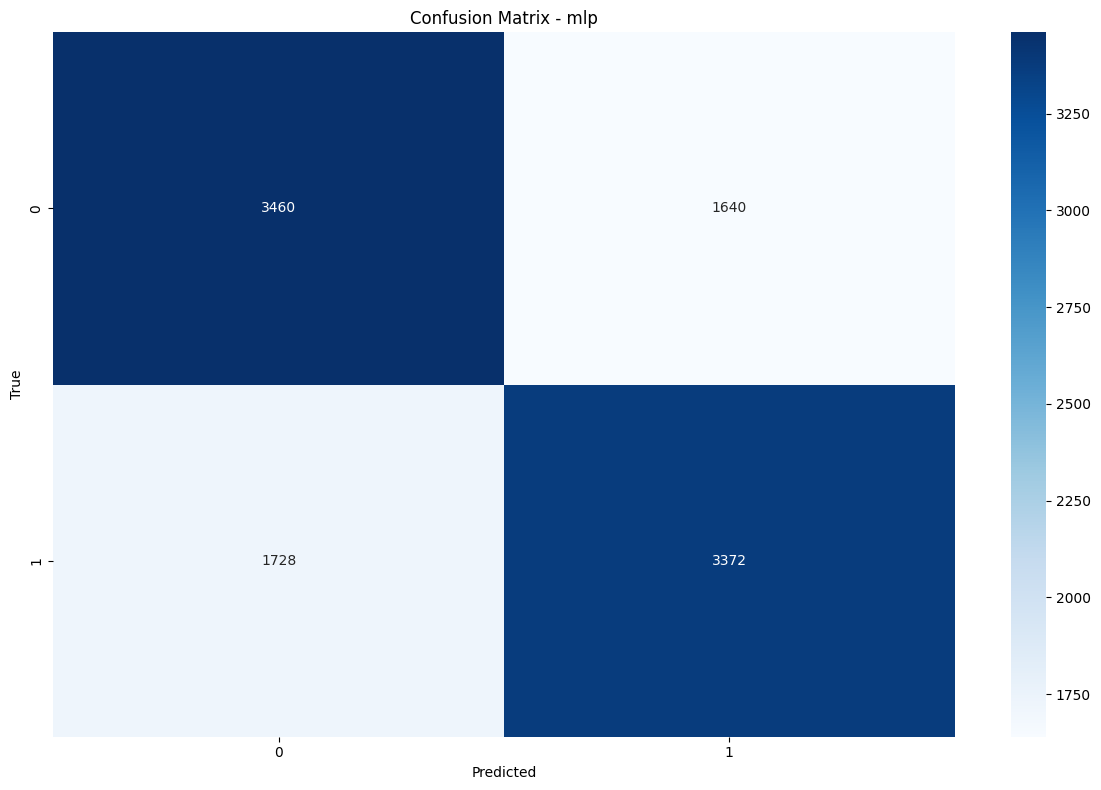

<Figure size 1200x800 with 0 Axes>

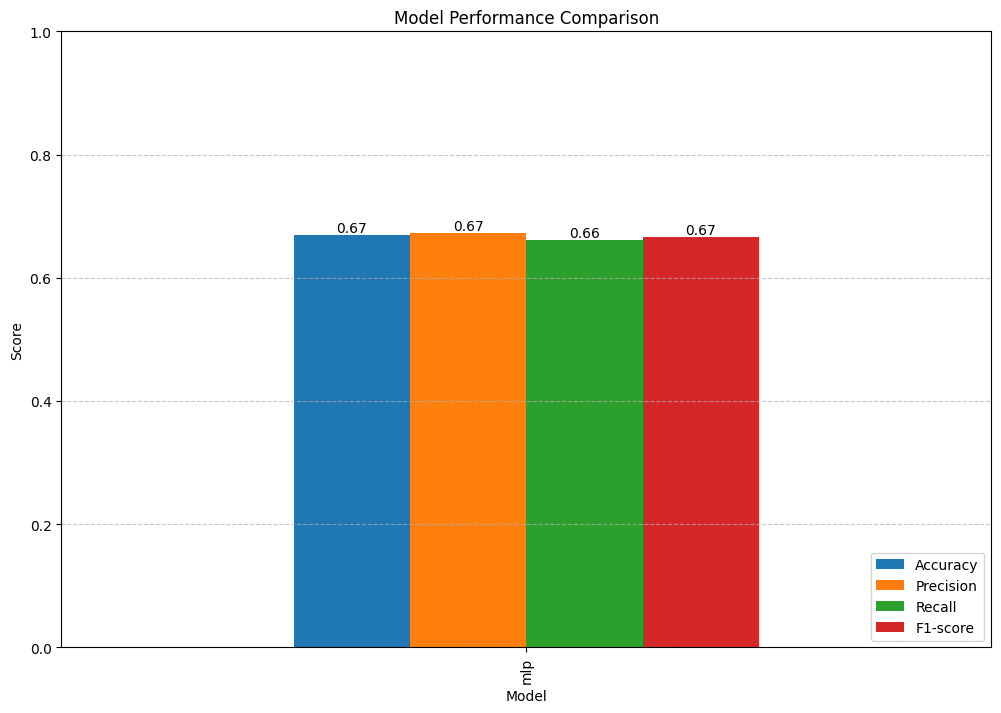

In [63]:
if GRID_SEARCH:
    param_grid = {
    'mlp__hidden_layer_sizes': [(256, 128, 64),(512, 256),],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate_init': [0.001],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200],
    'mlp__solver': ['adam']}
    
    mlp = MLPClassifier(random_state=27, max_iter=300)
    
    optimize_via_grid_search(mlp,"mlp",param_grid,
    y_parameter="age_young_old_encoded")

Starting grid search for rf (predicting age_young_old_encoded)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END rf__criterion=gini, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.5min
[CV] END rf__criterion=gini, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time= 1.5min
[CV] END rf__criterion=gini, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.5min
[CV] END rf__criterion=gini, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time= 1.5min
[CV] END rf__criterion=gini, rf__max_depth=20, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=200; total time= 1.5min
[CV] END rf__criterion=gini, rf__max_depth=20, rf__max_features=sqrt, rf_

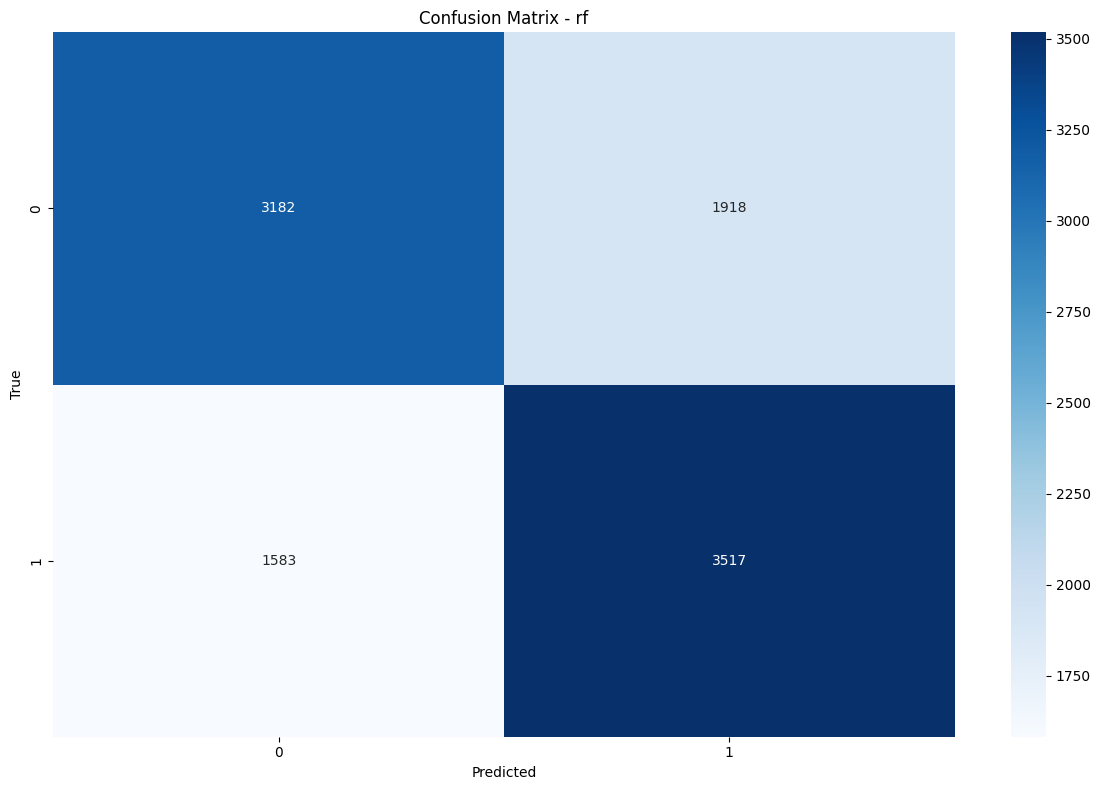

<Figure size 1200x800 with 0 Axes>

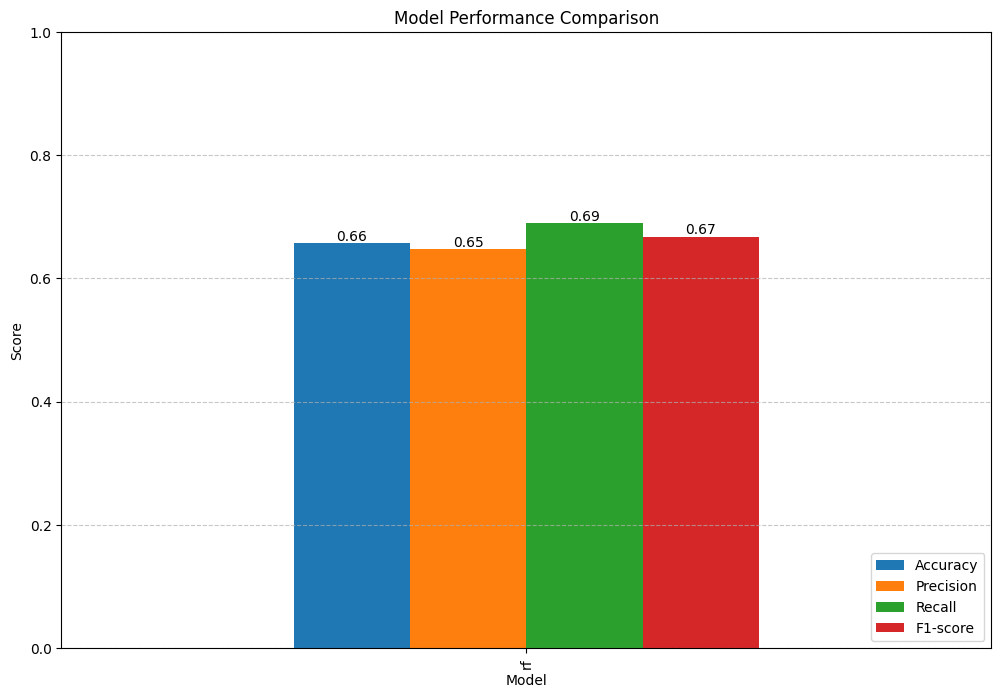

In [64]:
if GRID_SEARCH:
    param_grid = param_grid = {
            'rf__n_estimators': [200, 300],
            'rf__max_depth': [20, 30,],
            'rf__min_samples_split': [2, 5],
            'rf__min_samples_leaf': [1, 2],
            'rf__max_features': ['sqrt'],
            'rf__criterion': ['gini', 'entropy'],
        }

    rf = RandomForestClassifier(random_state=27)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for hgb (predicting age_young_old_encoded)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.1, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=30; total time=   4.2s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.1, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=10; total time=   5.2s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.1, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=10; total time=   5.3s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.1, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=10; total time=   5.4s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.1, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samples_leaf=30; total time=   5.1s
[CV] END hgb__early_stopping=True, hgb__l2_regularization=0.0, hgb__learning_rate=0.1, hgb__max_depth=None, hgb__max_iter=100, hgb__min_samp

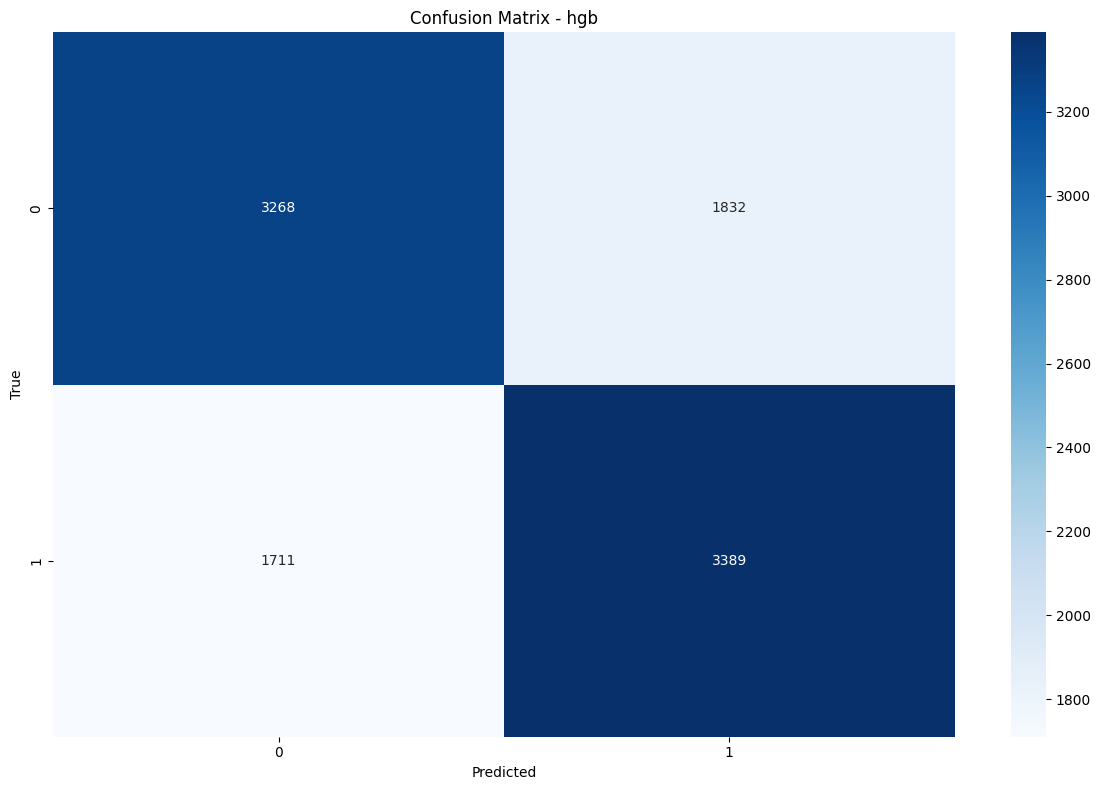

<Figure size 1200x800 with 0 Axes>

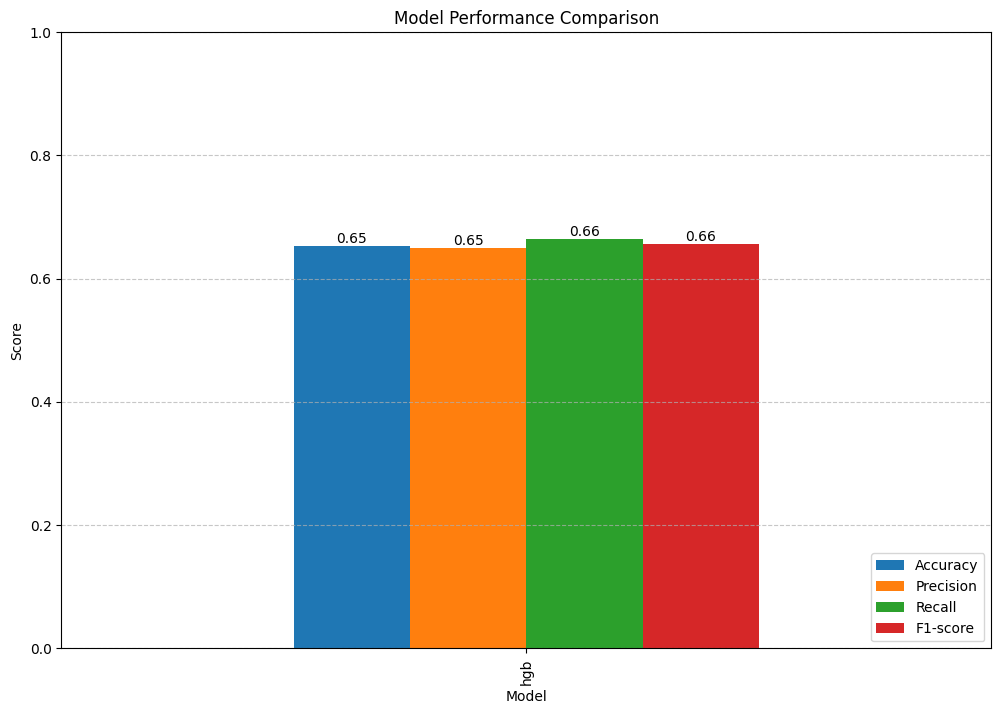

In [71]:
if GRID_SEARCH:
    param_grid = {
        'hgb__learning_rate': [0.1, 0.2],
        'hgb__max_iter': [100, 300],
        'hgb__max_depth': [None, 5],
        'hgb__min_samples_leaf': [10, 30,],
        'hgb__l2_regularization': [0.0, 1.0],
        'hgb__early_stopping': [True],
        }

    hgb = HistGradientBoostingClassifier(random_state=27)

    optimize_via_grid_search(
        hgb,
        "hgb",
        param_grid,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for svc (predicting age_young_old_encoded)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.001; total time=   2.8s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.001; total time=   3.0s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.001; total time=   3.3s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.0001; total time=   3.8s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=3000, svc__tol=0.0001; total time=   4.0s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=3000, svc__tol=0.0001; total time=   3.7s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.0001; total time=   4.1s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc__max_iter=1000, svc__tol=0.0001; total time=   4.3s
[CV] END svc__C=0.01, svc__loss=squared_hinge, svc_

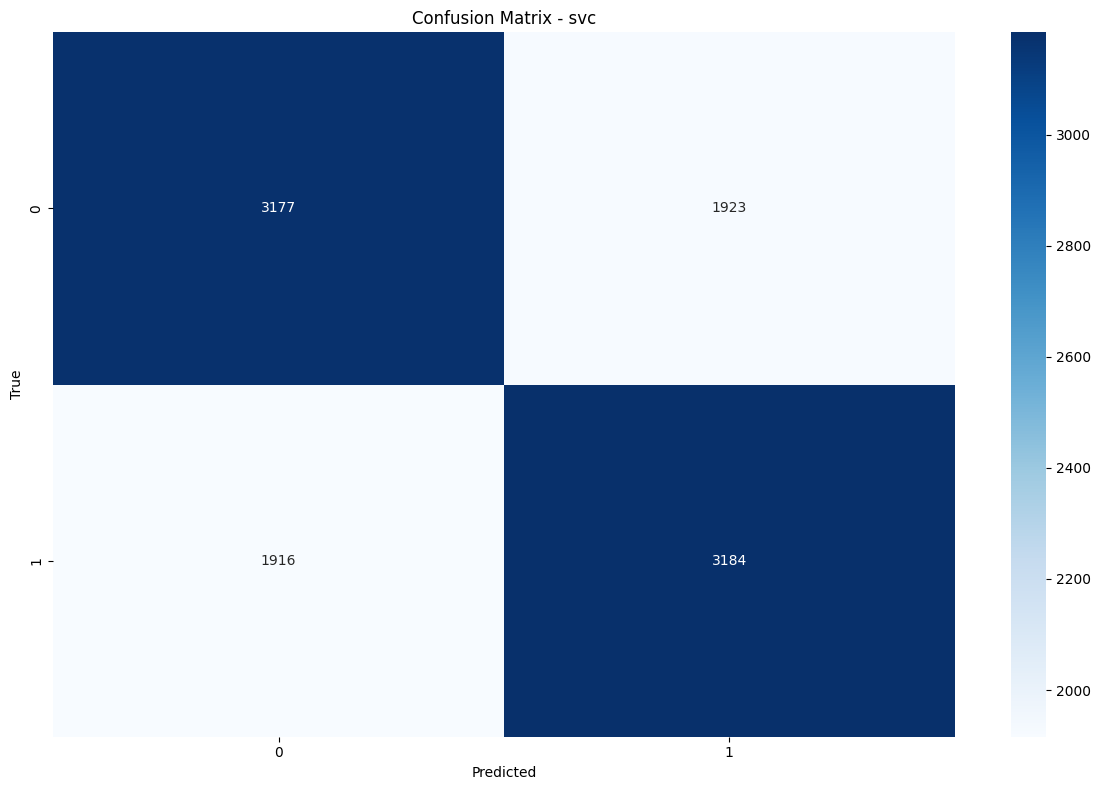

<Figure size 1200x800 with 0 Axes>

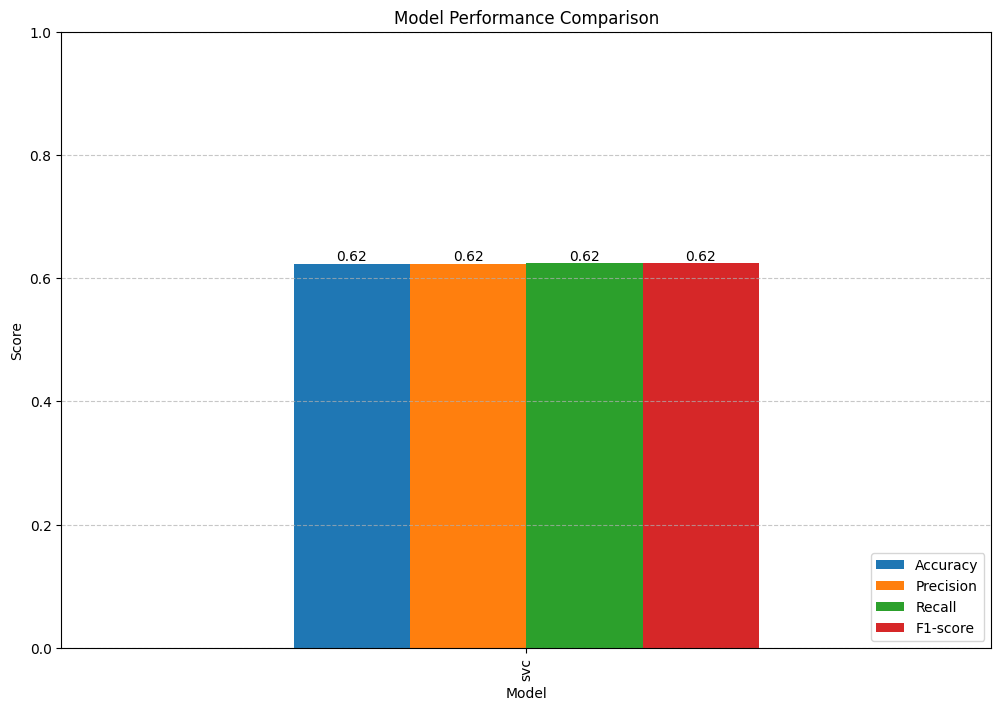

In [68]:
if GRID_SEARCH:
    param_grid = {
        'svc__C': [0.01, 0.1, 1, 10],
        'svc__loss': ['squared_hinge'],
        'svc__max_iter': [1000, 3000],
        'svc__tol': [1e-4, 1e-3]
    }

    svc = LinearSVC(random_state=27, dual=False)

    optimize_via_grid_search(
        svc,
        "svc",
        param_grid,
        y_parameter="age_young_old_encoded"
    )

#### Optimize Models Predicting Gender

Starting grid search for mlp (predicting gender_encoded)...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.001, mlp__max_iter=3000, mlp__validation_fraction=0.1; total time=  28.2s
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.001, mlp__max_iter=3000, mlp__validation_fraction=0.1; total time=  42.4s
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__hidden_layer_sizes=(256, 128), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.001, mlp__max_iter=3000, mlp__validation_fraction=0.1; total time=  24.7s
[CV] END mlp__activation=relu, mlp__alpha=5e-05, mlp__batch_size=64, mlp__early_stopping=True, mlp__

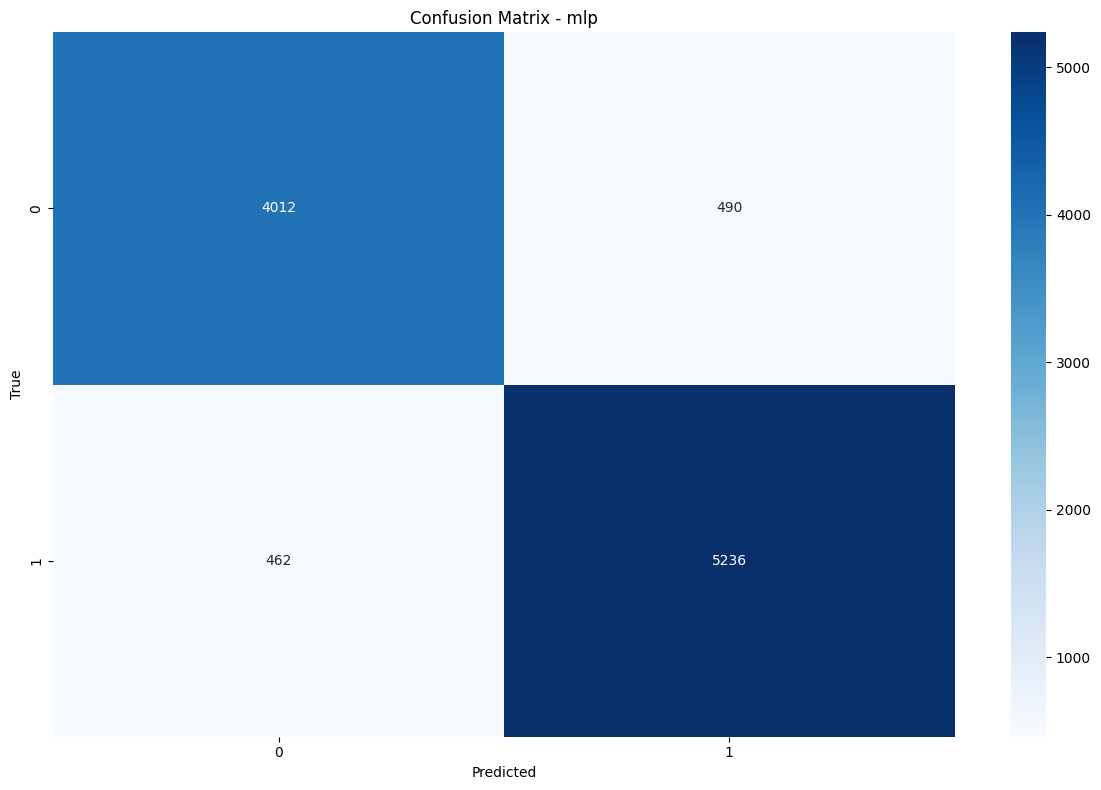

<Figure size 1200x800 with 0 Axes>

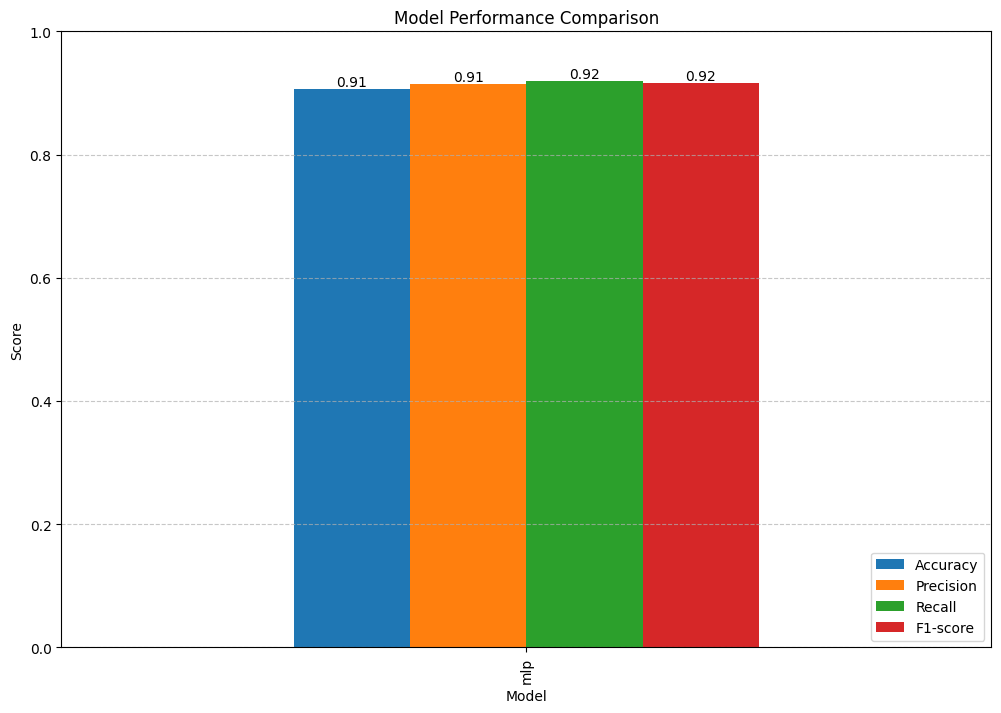

In [75]:
if GRID_SEARCH:
    param_grid = {
        'mlp__hidden_layer_sizes': [(512, 256, 128),(512, 256),(256, 128)],
        'mlp__activation': ['relu'],
        'mlp__alpha': [0.00005, 0.0001, 0.0005],
        'mlp__batch_size': [64],
        'mlp__learning_rate_init': [0.001],
        'mlp__learning_rate': ['adaptive'],
        'mlp__max_iter': [3000],
        'mlp__early_stopping': [True],
        'mlp__validation_fraction': [0.1]
        }

    mlp = MLPClassifier(random_state=27, max_iter=300)

    optimize_via_grid_search(mlp,"mlp",param_grid,y_parameter="gender_encoded")

Starting grid search for rf (predicting gender_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  39.3s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  39.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  39.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  39.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  39.9s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=  38.6s
[CV] END rf__max_depth=None,

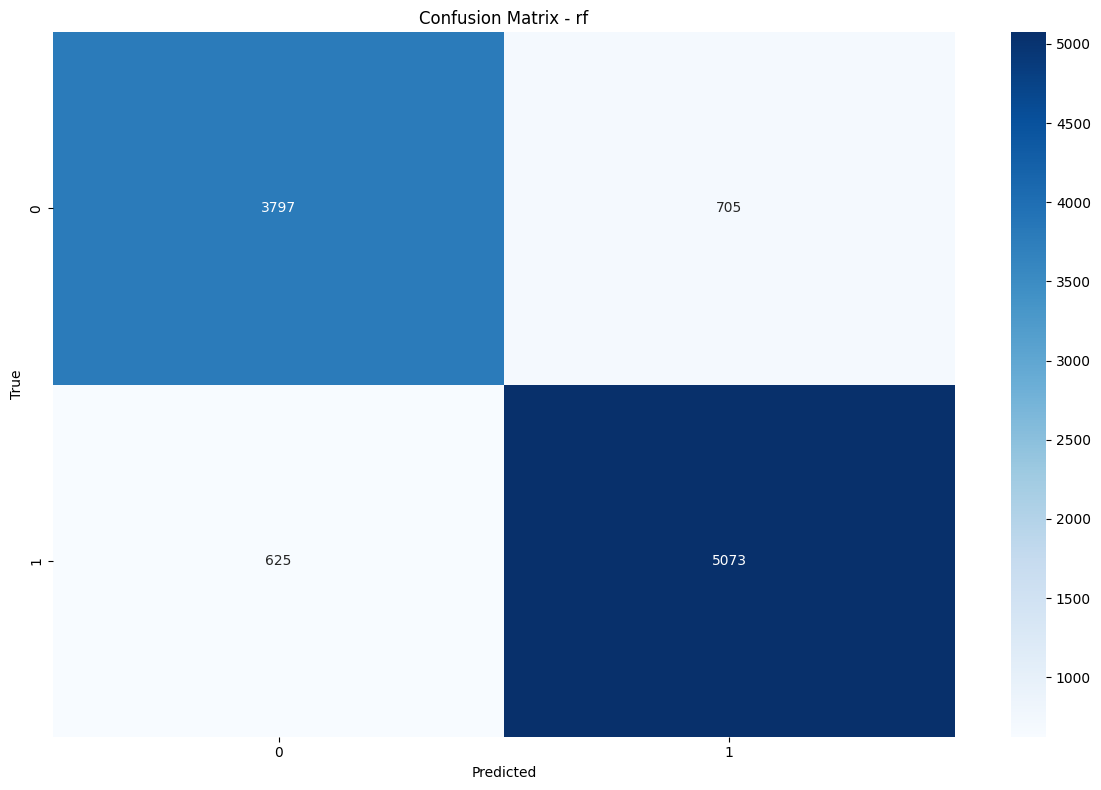

<Figure size 1200x800 with 0 Axes>

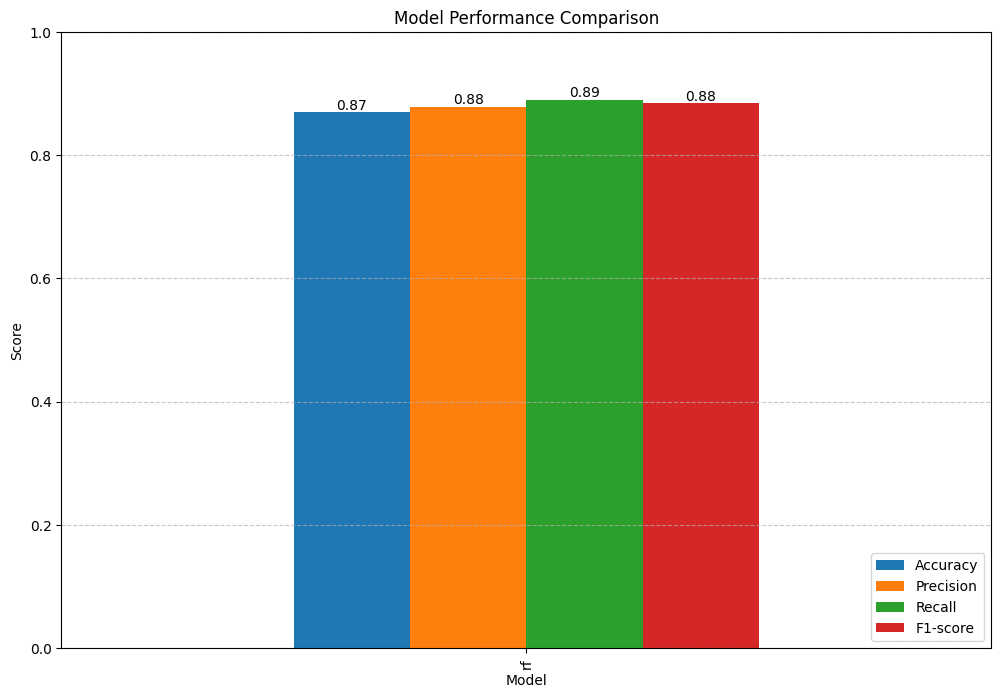

In [77]:
if GRID_SEARCH:
    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt'],
    }

    rf = RandomForestClassifier(random_state=27)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        y_parameter="gender_encoded"
    )

#### Optimize Models Predicting Age Given Gender

Starting grid search for rf (predicting age_young_old_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  15.5s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  15.7s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  15.8s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=  13.7s
[CV] END rf__max_dept

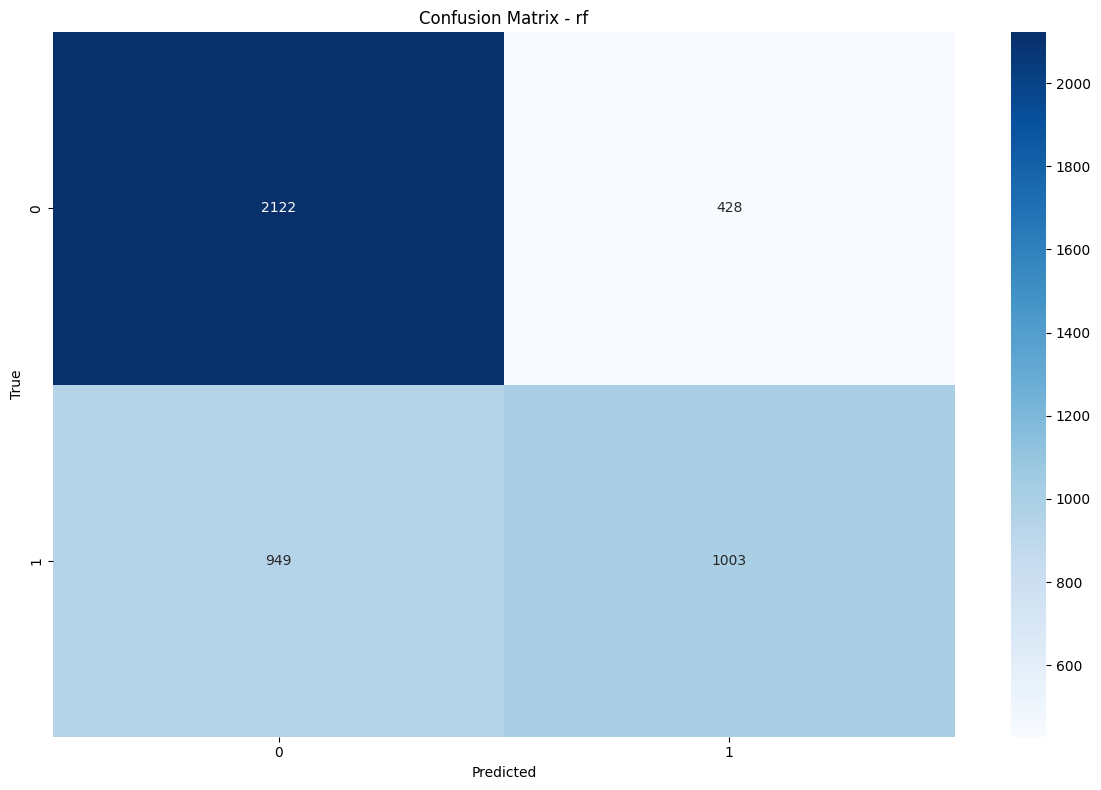

<Figure size 1200x800 with 0 Axes>

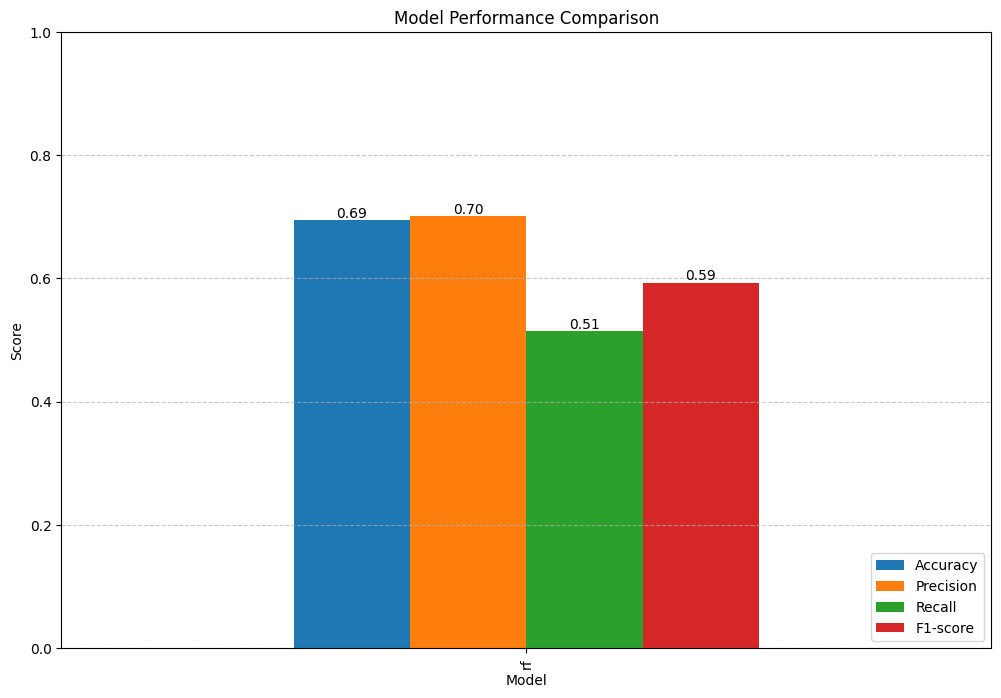

In [80]:
if GRID_SEARCH:
    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt'],
    }

    rf = RandomForestClassifier(random_state=27)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        X_train=X_train_female,
        y_train=y_train_female,
        X_val=X_val_female,
        y_val=y_val_female,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for rf (predicting age_young_old_encoded)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  20.3s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  20.3s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  20.4s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  20.5s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=  20.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=  22.8s
[CV] END rf__max_dept

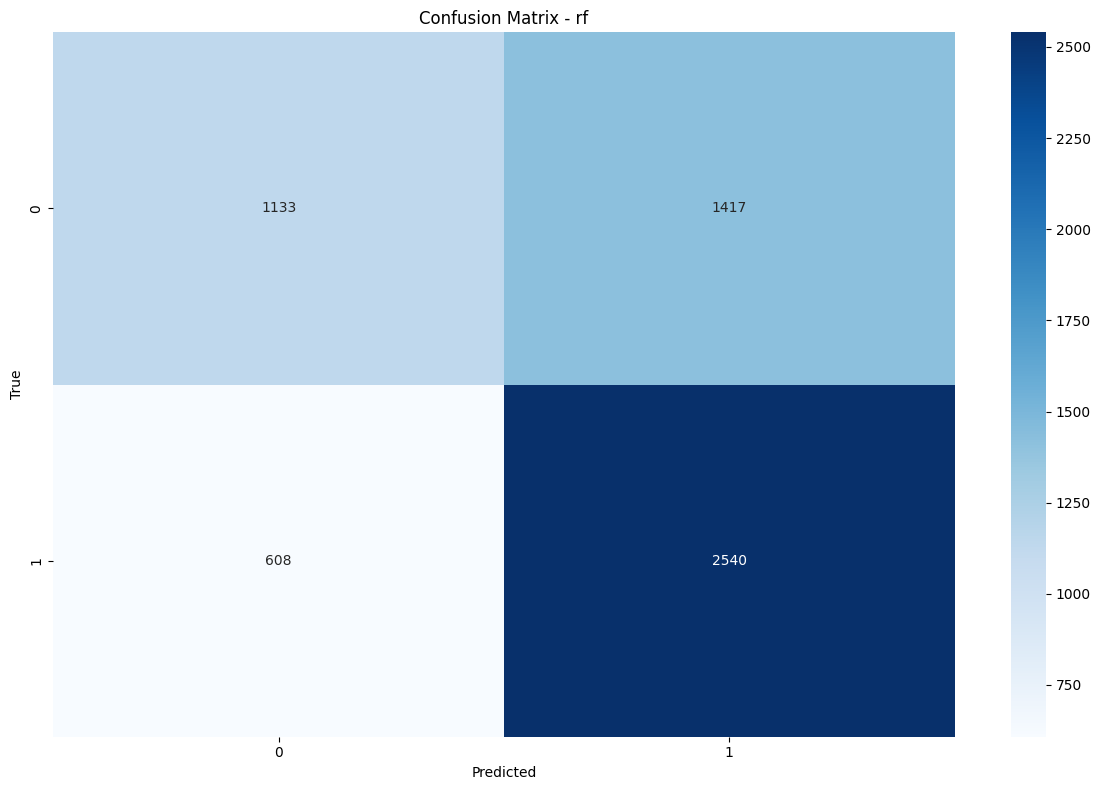

<Figure size 1200x800 with 0 Axes>

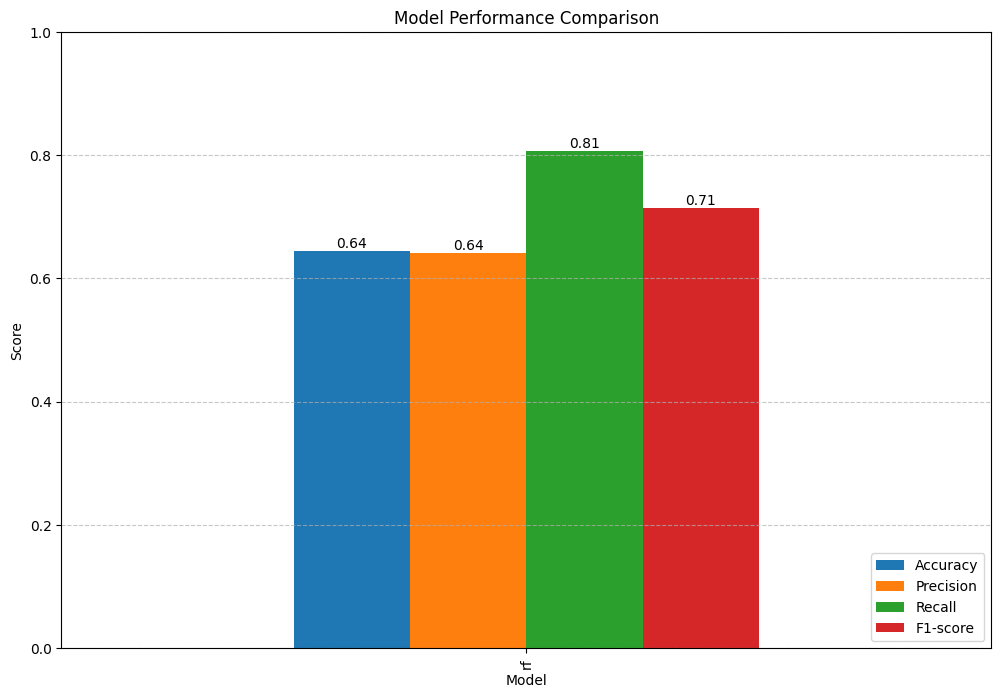

In [81]:
if GRID_SEARCH:
    param_grid = {
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2],
        'rf__max_features': ['sqrt']
    }

    rf = RandomForestClassifier(random_state=27)

    optimize_via_grid_search(
        rf,
        "rf",
        param_grid,
        X_train=X_train_male,
        y_train=y_train_male,
        X_val=X_val_male,
        y_val=y_val_male,
        y_parameter="age_young_old_encoded"
    )

Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  35.8s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  39.6s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  40.0s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  42.6s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer

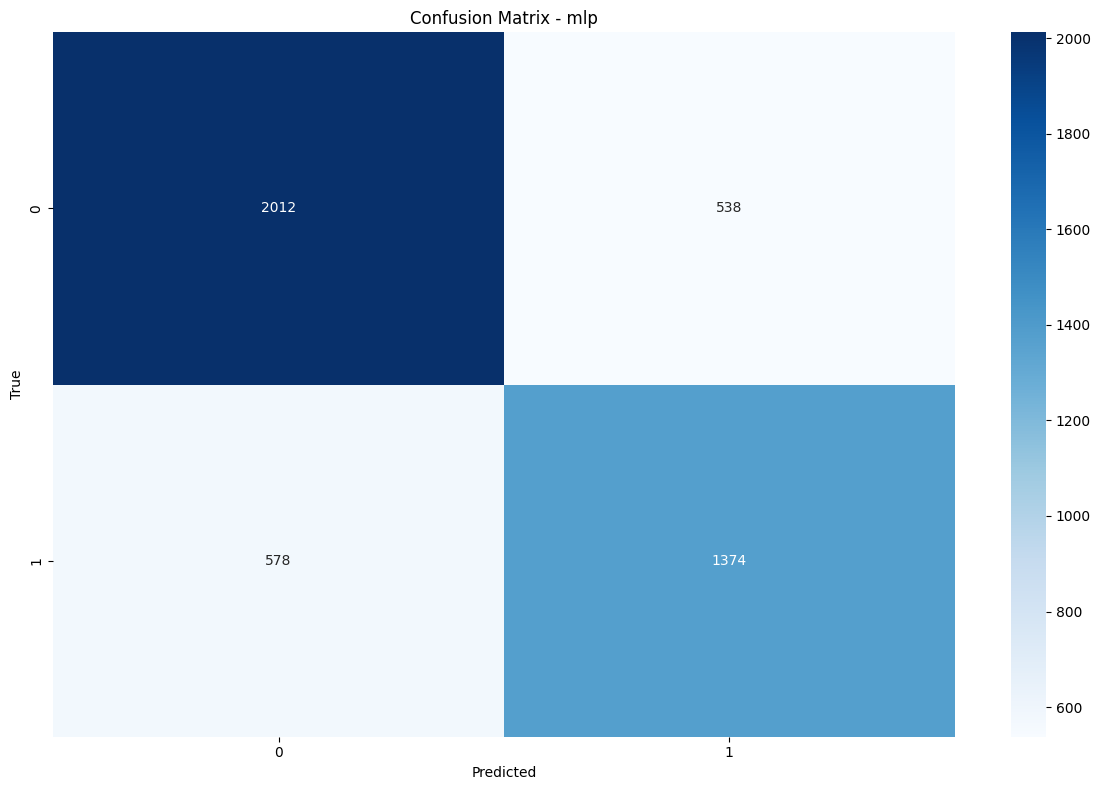

<Figure size 1200x800 with 0 Axes>

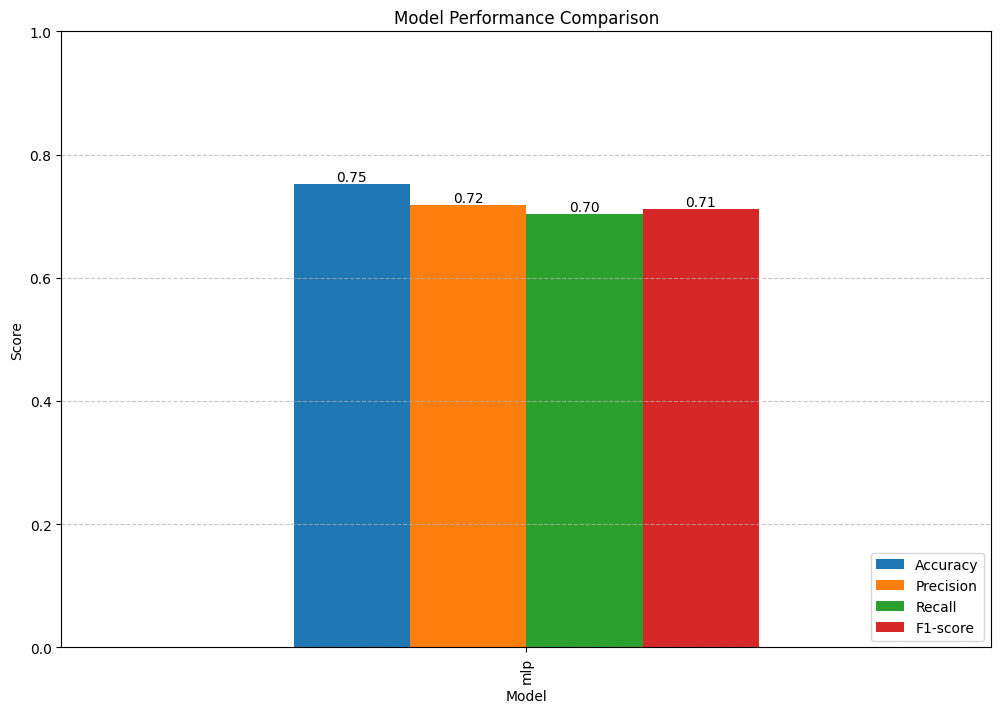

In [82]:
if GRID_SEARCH:    
    param_grid = {
    'mlp__hidden_layer_sizes': [(256, 128, 64),(512, 256),],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate_init': [0.001],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200],
    'mlp__solver': ['adam']}
    
    mlp = MLPClassifier(random_state=27, max_iter=300)
    
    optimize_via_grid_search(mlp,"mlp",param_grid,X_train=X_train_female,
        y_train=y_train_female,
        X_val=X_val_female,
        y_val=y_val_female,y_parameter="age_young_old_encoded")
    

Starting grid search for mlp (predicting age_young_old_encoded)...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  34.5s
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time=  42.6s
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time= 1.1min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer_sizes=(256, 128, 64), mlp__learning_rate_init=0.001, mlp__max_iter=200, mlp__solver=adam; total time= 1.1min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__batch_size=64, mlp__hidden_layer

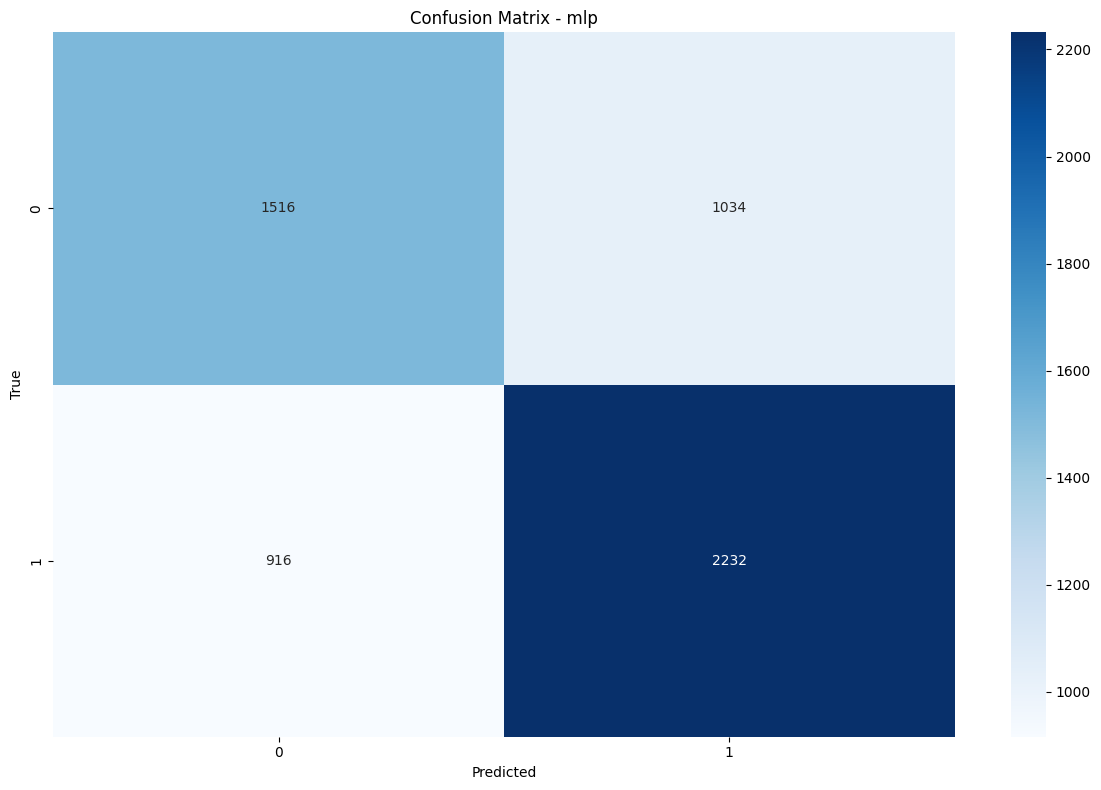

<Figure size 1200x800 with 0 Axes>

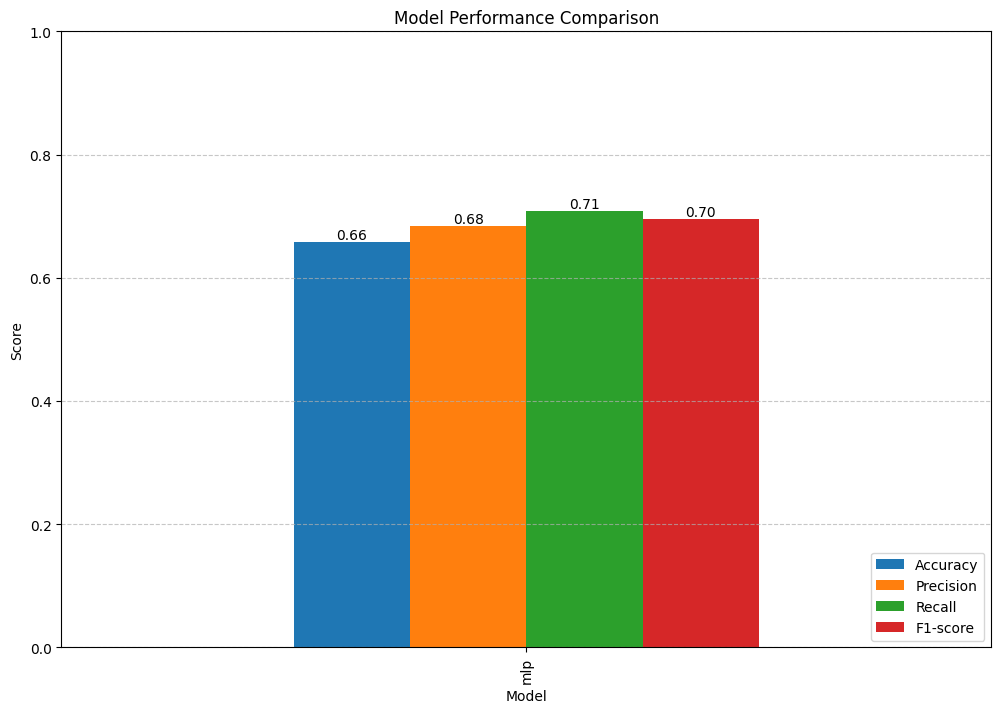

In [83]:
if GRID_SEARCH:
    param_grid = {
    'mlp__hidden_layer_sizes': [(256, 128, 64),(512, 256),],
    'mlp__activation': ['relu'],
    'mlp__alpha': [0.0001, 0.001],
    'mlp__learning_rate_init': [0.001],
    'mlp__batch_size': [64],
    'mlp__max_iter': [200],
    'mlp__solver': ['adam']}
    
    mlp = MLPClassifier(random_state=27, max_iter=300)
    
    optimize_via_grid_search(mlp,"mlp",param_grid,
        X_train=X_train_male,
        y_train=y_train_male,
        X_val=X_val_male,
        y_val=y_val_male,y_parameter="age_young_old_encoded")

## Age Prediction on Male vs. Female

## Advanced Two-Staged Models

In [ ]:
def evaluate_layered_model(predicted_age_comp, y_comp_age, y_comp_gender, age_model_name, label=None, binning=None, expanded=False):
    
    if expanded:
        metrics = {
            'Model': [],
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-score': []
        }
    
    for gender in ['female_feminine','male_masculine',  'total']:
        if gender == 'total':
            gender_mask = y_comp_gender.notnull()
        else:
            gender_mask = y_comp_gender == gender

        if binning:
            y_true_age = apply_binning(y_comp_age[gender_mask],binning)
            y_pred_age = apply_binning([predicted_age_comp[i] for i in range(len(predicted_age_comp)) if gender_mask.iloc[i]], binning)
        else:
            y_true_age = y_comp_age[gender_mask]
            y_pred_age = [predicted_age_comp[i] for i in range(len(predicted_age_comp)) if gender_mask.iloc[i]]

        print(f"\n{age_model_name} - Prediction Report on Gender {gender}: {label}")
        print(classification_report(y_true_age, y_pred_age))

        if expanded:
            # Store metrics
            metrics['Model'].append(f'{age_model_name} - {gender}')
            metrics['Accuracy'].append(accuracy_score(y_true_age, y_pred_age))
            metrics['Precision'].append(precision_score(y_true_age, y_pred_age, average='weighted'))
            metrics['Recall'].append(recall_score(y_true_age, y_pred_age, average='weighted'))
            metrics['F1-score'].append(f1_score(y_true_age, y_pred_age, average='weighted'))
        
        if expanded:
            # Plot confusion matrix
            cm_age_gender = confusion_matrix(y_true_age, y_pred_age)
            labels = sorted(set(y_true_age).union(set(y_pred_age)))
            sns.heatmap(cm_age_gender, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels, yticklabels=labels)
            plt.title(f'Confusion Matrix {age_model_name} - Prediction on Gender {gender}: {label}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.show()
        
    if expanded:
        # Plot metrics comparison
        plt.figure(figsize=(12, 8))
        metrics_df = pd.DataFrame(metrics)
        metrics_df_plot = metrics_df.set_index('Model')
        ax = metrics_df_plot.plot(kind='bar', figsize=(12, 8))
        plt.title('Model Performance Comparison')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        plt.legend(loc='lower right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)
        plt.show()
        return pd.DataFrame(metrics)
        

In [ ]:
def fit_predict_two_stage_gender_age_pipeline(
    gender_model_class,
    age_model_class_female,
    age_model_class_male,
    gender_model_name="GenderModel",
    age_model_name="AgeModel",
    X_train=X_train_clean, y_train_age=y_train_clean["age_young_old"], y_train_gender=y_train_clean["gender"],
    X_comp=X_val, y_comp_age=y_val["age_young_old"], y_comp_gender=y_val["gender"], 
    binning=None, multiclass=False):
  
    # ====== Fit gender model ======
    pipe_gender = make_pipeline(clone(preprocessing),clone(gender_model_class))
    print(f"\nFitting {gender_model_name} on training set")
    pipe_gender.fit(X_train, y_train_gender)

    print(f"\nPredicting {gender_model_name} on training set")
    predicted_gender_train=pipe_gender.predict(X_train)
    print(f"\nPredicting {gender_model_name} on comparison set")
    predicted_gender_comp = pipe_gender.predict(X_comp)
    
    for split_name, preds, y in [('Training', predicted_gender_train, y_train_gender), ('Comparison', predicted_gender_comp, y_comp_gender)]:
            print(f"\n{gender_model_name} Gender Model - {split_name} Set:")
            print(classification_report(y, preds))

            if split_name == 'Comparison':
                cm = confusion_matrix(y, preds)
                labels = sorted(set(y).union(set(preds)))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
                plt.title(f'Confusion Matrix - Gender ({gender_model_name}, {split_name} Set)')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.show()

    # ====== Train age models ======
    # Split train set by gender
    X_train_male = X_train[y_train_gender == 'male_masculine']
    y_train_male = y_train_age[y_train_gender == 'male_masculine']
    X_train_female = X_train[y_train_gender== 'female_feminine']
    y_train_female = y_train_age[y_train_gender == 'female_feminine']

    # Fit individual age models
    pipe_age_male = make_pipeline(clone(preprocessing), clone(age_model_class_male))
    pipe_age_female = make_pipeline(clone(preprocessing), clone(age_model_class_female))

    print(f"\nFitting {age_model_name} on Gender Female")
    pipe_age_female.fit(X_train_female, y_train_female)

    print(f"\nFitting {age_model_name} on Gender Male")
    pipe_age_male.fit(X_train_male, y_train_male)

    
    # ====== Age predictions ======
    predicted_age_true_gender = []
    predicted_age_pred_gender = []
    for i in tqdm(range(len(X_comp)), desc=f"Predicting {age_model_name} on comparison set"):
        x_instance = X_comp.iloc[[i]]

        # TRUE gender routing
        true_gender = y_comp_gender.iloc[i]
        model_true = pipe_age_male if true_gender == 'male_masculine' else pipe_age_female
        predicted_age_true_gender.append(model_true.predict(x_instance)[0])

        # PREDICTED gender routing
        pred_gender = predicted_gender_comp[i]
        model_pred = pipe_age_male if pred_gender == 'male_masculine' else pipe_age_female
        predicted_age_pred_gender.append(model_pred.predict(x_instance)[0])


    if multiclass:
        y_comp_age = y_comp_age[:, 1]
        predicted_age_true_gender = np.array(predicted_age_true_gender)[:, 1]
        predicted_age_pred_gender = np.array(predicted_age_pred_gender)[:, 1]


    # ====== Evaluation ======

    evaluate_layered_model(predicted_age_true_gender, y_comp_age,y_comp_gender, age_model_name, "Routed by True Gender", binning=binning, expanded=False)
    metrics=evaluate_layered_model(predicted_age_pred_gender, y_comp_age,y_comp_gender, age_model_name, "Routed by Predicted Gender", binning=binning)

    # ====== Routing error cost ======
    if binning:
        acc_true = accuracy_score(apply_binning(y_comp_age,binning), apply_binning(predicted_age_true_gender,binning))
        acc_pred = accuracy_score(apply_binning(y_comp_age,binning), apply_binning(predicted_age_pred_gender,binning))
        routing_cost = acc_true - acc_pred
        print(f"\n Routing Error Cost (Accuracy Loss from using predicted gender): {routing_cost:.4f}")
    else:
        acc_true = accuracy_score(y_comp_age, predicted_age_true_gender)
        acc_pred = accuracy_score(y_comp_age, predicted_age_pred_gender)
        routing_cost = acc_true - acc_pred
        print(f"\n Accuracy True Gender Routing: {acc_true:.4f}")
        print(f"\n Accuracy Predicted Gender Routing: {acc_pred:.4f}")
        print(f"\n Routing Error Cost (Accuracy Loss from using predicted gender): {routing_cost:.4f}")

    return metrics



Fitting MLPClassifier for Gender on training set


c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Predicting MLPClassifier for Gender on training set

Predicting MLPClassifier for Gender on comparison set

MLPClassifier for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       0.93      0.92      0.92     18007
 male_masculine       0.94      0.94      0.94     22793

       accuracy                           0.93     40800
      macro avg       0.93      0.93      0.93     40800
   weighted avg       0.93      0.93      0.93     40800


MLPClassifier for Gender Gender Model - Comparison Set:
                 precision    recall  f1-score   support

female_feminine       0.89      0.89      0.89      4502
 male_masculine       0.91      0.92      0.91      5698

       accuracy                           0.90     10200
      macro avg       0.90      0.90      0.90     10200
   weighted avg       0.90      0.90      0.90     10200



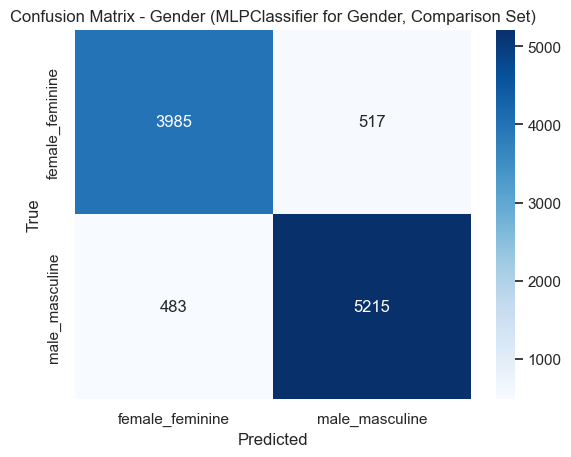


Fitting MLP for Age on Gender Female


c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(



Fitting MLP for Age on Gender Male


c:\Users\danie\anaconda3\envs\tensorflow\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
Predicting MLP for Age on comparison set: 100%|██████████| 10200/10200 [01:20<00:00, 126.90it/s]



MLP for Age - Prediction Report on Gender female_feminine: Routed by True Gender
              precision    recall  f1-score   support

         old       0.65      0.57      0.61      1952
       young       0.70      0.76      0.73      2550

    accuracy                           0.68      4502
   macro avg       0.67      0.67      0.67      4502
weighted avg       0.68      0.68      0.68      4502



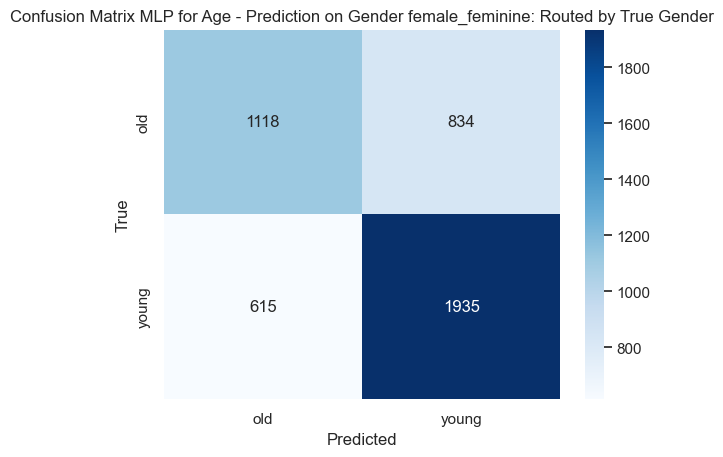


MLP for Age - Prediction Report on Gender male_masculine: Routed by True Gender
              precision    recall  f1-score   support

         old       0.64      0.72      0.68      3148
       young       0.60      0.51      0.55      2550

    accuracy                           0.63      5698
   macro avg       0.62      0.62      0.62      5698
weighted avg       0.62      0.63      0.62      5698



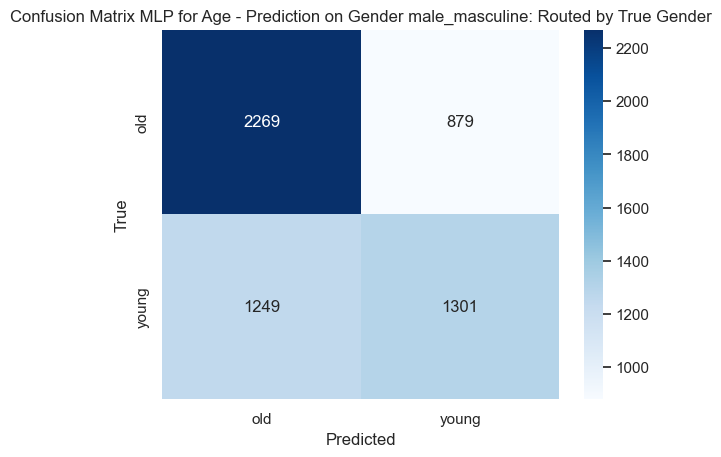


MLP for Age - Prediction Report on Gender total: Routed by True Gender
              precision    recall  f1-score   support

         old       0.65      0.66      0.65      5100
       young       0.65      0.63      0.64      5100

    accuracy                           0.65     10200
   macro avg       0.65      0.65      0.65     10200
weighted avg       0.65      0.65      0.65     10200



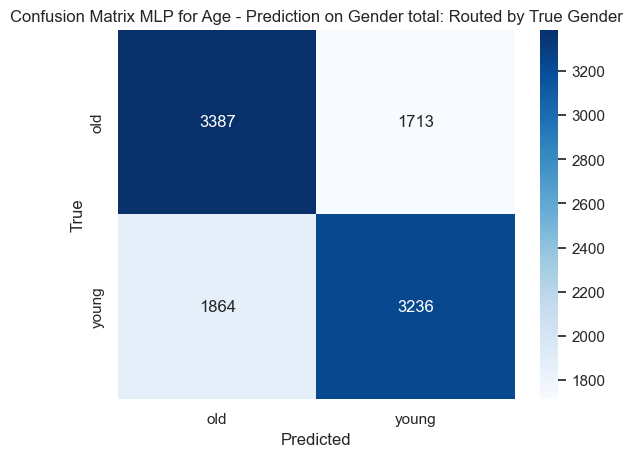


MLP for Age - Prediction Report on Gender female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

         old       0.63      0.57      0.60      1952
       young       0.69      0.74      0.72      2550

    accuracy                           0.67      4502
   macro avg       0.66      0.66      0.66      4502
weighted avg       0.67      0.67      0.67      4502



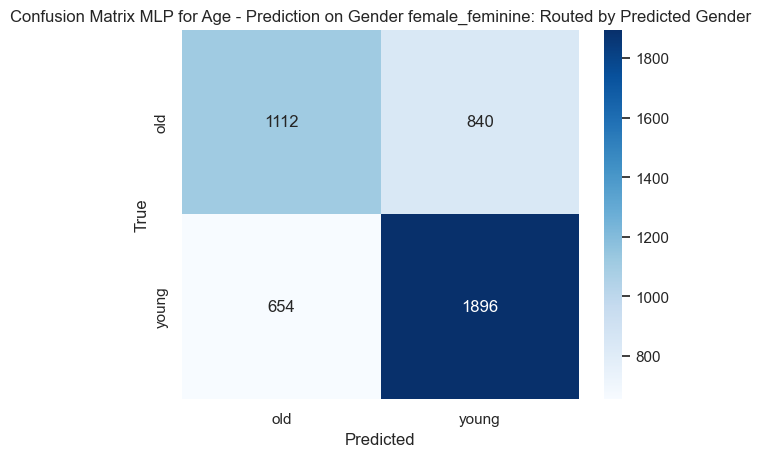


MLP for Age - Prediction Report on Gender male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

         old       0.64      0.72      0.68      3148
       young       0.59      0.50      0.54      2550

    accuracy                           0.62      5698
   macro avg       0.62      0.61      0.61      5698
weighted avg       0.62      0.62      0.62      5698



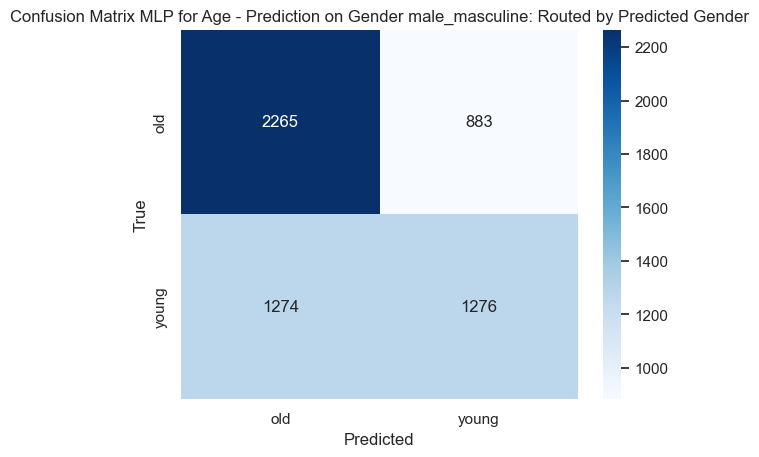


MLP for Age - Prediction Report on Gender total: Routed by Predicted Gender
              precision    recall  f1-score   support

         old       0.64      0.66      0.65      5100
       young       0.65      0.62      0.63      5100

    accuracy                           0.64     10200
   macro avg       0.64      0.64      0.64     10200
weighted avg       0.64      0.64      0.64     10200



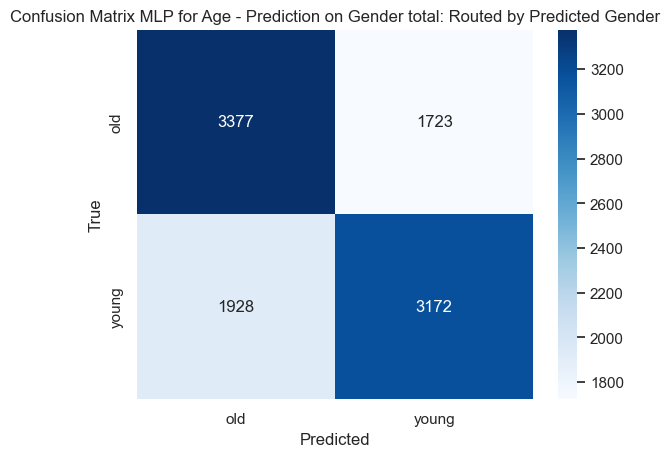

<Figure size 1200x800 with 0 Axes>

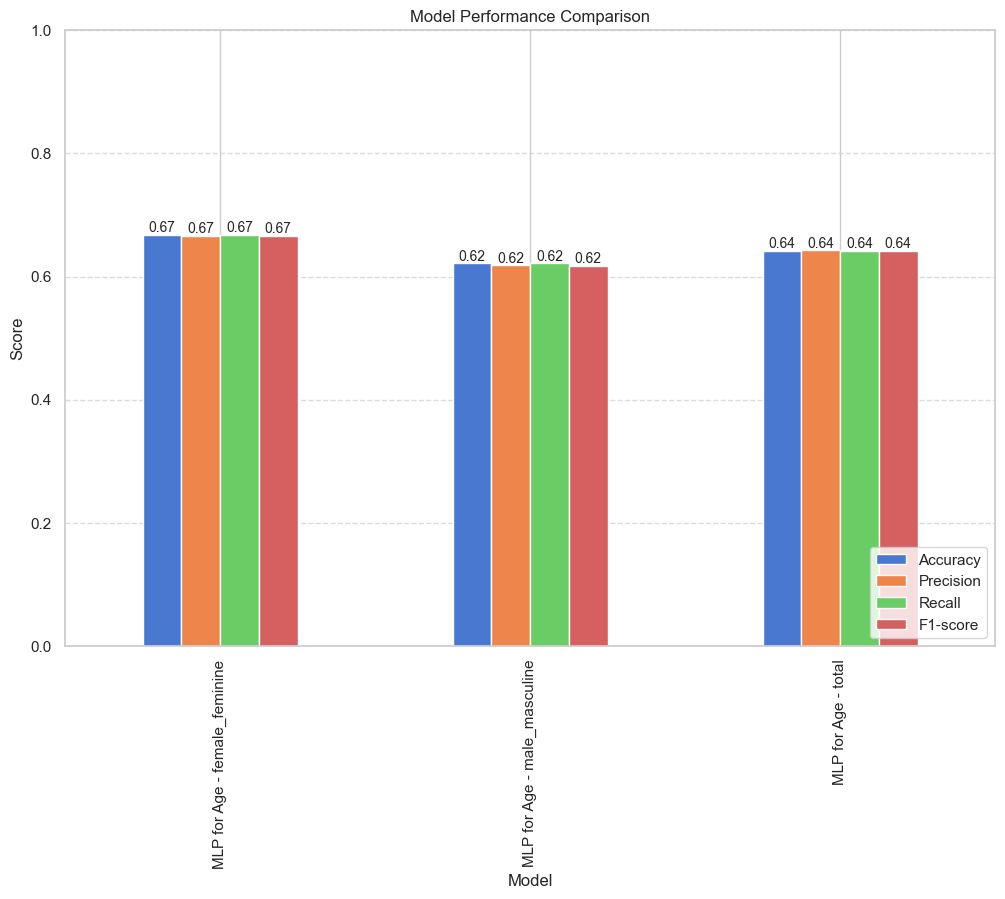


 Accuracy True Gender Routing: 0.6493

 Accuracy Predicted Gender Routing: 0.6421

 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0073


,Model,Accuracy,Precision,Recall,F1-score
0,MLP for Age - female_feminine,0.668147,0.665532,0.668147,0.665685
1,MLP for Age - male_masculine,0.621446,0.618084,0.621446,0.616797
2,MLP for Age - total,0.642059,0.642289,0.642059,0.641914


In [188]:
#TEST
#Prebinned Classifier
fit_predict_two_stage_gender_age_pipeline(
    MLPClassifier(hidden_layer_sizes=(16, 8),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=100,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.0001),

    MLPClassifier(hidden_layer_sizes=(16, 8),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=100,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.0001),
    MLPClassifier(hidden_layer_sizes=(16, 8),
                batch_size=64,
                learning_rate_init=0.001,
                max_iter=100,
              activation="relu",
              random_state=27,
              learning_rate='adaptive',
              alpha=0.0001),
    "MLPClassifier for Gender",
    "MLP for Age")


## Feature Enriched Models

In [ ]:
def fit_predict_gender_age_pipeline_with_soft_feature(
    gender_model_class,
    age_model_class,
    gender_model_name="GenderModel",
    age_model_name="AgeModel",
    X_train=X_train_clean, y_train_gender=y_train_clean['gender'],y_train_age=y_train_clean['age_young_old'], X_comp=X_val,
    y_comp_gender=y_val['gender'], y_comp_gender_encoded=y_val['gender_encoded'],y_comp_age=y_val['age_young_old'],
    binning=None, multiclass=False):
    
    
    # Fit gender model
    pipe_gender = make_pipeline(clone(preprocessing), clone(gender_model_class))
    print(f"\nFitting {gender_model_name} on training set")
    pipe_gender.fit(X_train, y_train_gender)

    # Predict gender probability
    print(f"\nPredict probability of {gender_model_name} on training set")
    prob_gender_train = pipe_gender.predict_proba(X_train)[:, 1]
    print(f"\nPredict probability of {gender_model_name} on comparison set")
    prob_gender_comp = pipe_gender.predict_proba(X_comp)[:, 1]
    

    # Evaluate gender model
    predicted_gender_comp = pipe_gender.predict(X_comp)
    print(f"\n{gender_model_name} Gender Model - Comparison Set Classification Report:")
    print(classification_report(y_comp_gender, predicted_gender_comp))

    auc_score = roc_auc_score(y_comp_gender_encoded, prob_gender_comp)
    logloss = log_loss(y_comp_gender_encoded, prob_gender_comp)
    print(f"AUC-ROC for Gender Probabilities: {auc_score:.4f}")
    print(f"Log Loss for Gender Probabilities: {logloss:.4f}")

    RocCurveDisplay.from_predictions(y_comp_gender_encoded, prob_gender_comp)
    plt.title("ROC Curve - Gender Probabilities")
    plt.show()

    prob_true, prob_pred = calibration_curve(y_comp_gender_encoded, prob_gender_comp, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve - Gender Probabilities")
    plt.show()

    # ====== Append gender prob to features ======
    X_train_aug = X_train.copy()
    X_comp_aug = X_comp.copy()
    X_train_aug['prob_gender_male'] = prob_gender_train
    X_comp_aug['prob_gender_male'] = prob_gender_comp

    # ====== Fit age model ======
    age_model = make_pipeline(clone(preprocessing), clone(age_model_class))
    print(f"\nFitting {age_model_name} with gender probability feature")
    age_model.fit(X_train_aug, y_train_age)
    print(f"\nPredicting {age_model_name} on training set")
    pred_train=age_model.predict(X_train_aug)
    print(f"\nPredicting {age_model_name} on comparison set")
    pred_comp = age_model.predict(X_comp_aug)
    
    if multiclass:
        y_train_age = y_train_age[:, 1]
        y_comp_age = y_comp_age[:, 1]
        pred_train = pred_train[:, 1]
        pred_comp = pred_comp[:, 1]
        
    
    evaluate_models(y_train_age, {age_model_name : pred_train}, (12, 8), False, "Training Set", binning=binning)

    # ====== Predict age ======
    return evaluate_models(y_comp_age, {age_model_name : pred_comp}, (12, 8), True, "Comparison Set", binning=binning)


Fitting MLP for Gender on training set

Predict probability of MLP for Gender on training set

Predict probability of MLP for Gender on comparison set

MLP for Gender Gender Model - Comparison Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.90      0.88      0.89      4502
 male_masculine       0.91      0.92      0.92      5698

       accuracy                           0.91     10200
      macro avg       0.90      0.90      0.90     10200
   weighted avg       0.91      0.91      0.91     10200

AUC-ROC for Gender Probabilities: 0.9616
Log Loss for Gender Probabilities: 0.2511


/Users/jakobhren/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


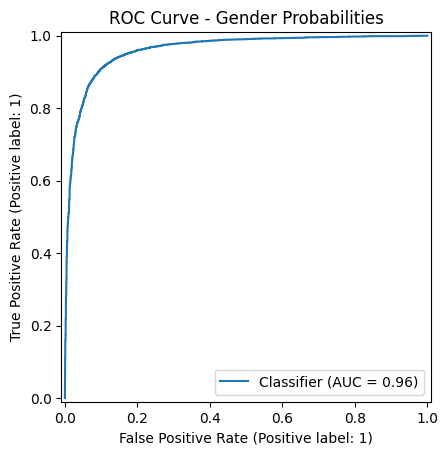

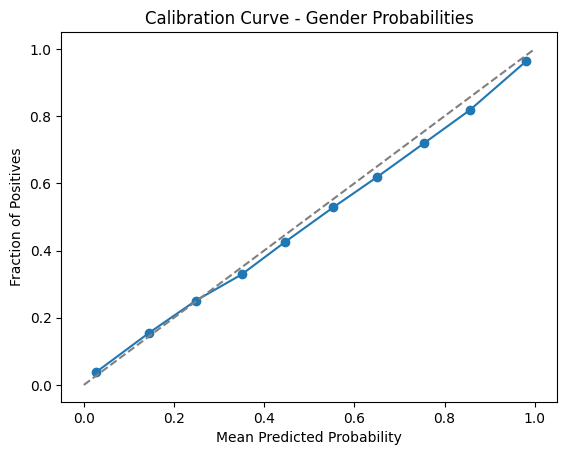


Fitting Pre-Binned RF for Age with gender probability feature

Predicting Pre-Binned RF for Age on training set

Predicting Pre-Binned RF for Age on comparison set

===== Pre-Binned RF for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       1.00      1.00      1.00     20400
       young       1.00      1.00      1.00     20400

    accuracy                           1.00     40800
   macro avg       1.00      1.00      1.00     40800
weighted avg       1.00      1.00      1.00     40800


===== Pre-Binned RF for Age: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.67      0.65      5100
       young       0.64      0.60      0.62      5100

    accuracy                           0.63     10200
   macro avg       0.64      0.63      0.63     10200
weighted avg       0.64      0.63      0.63     10200



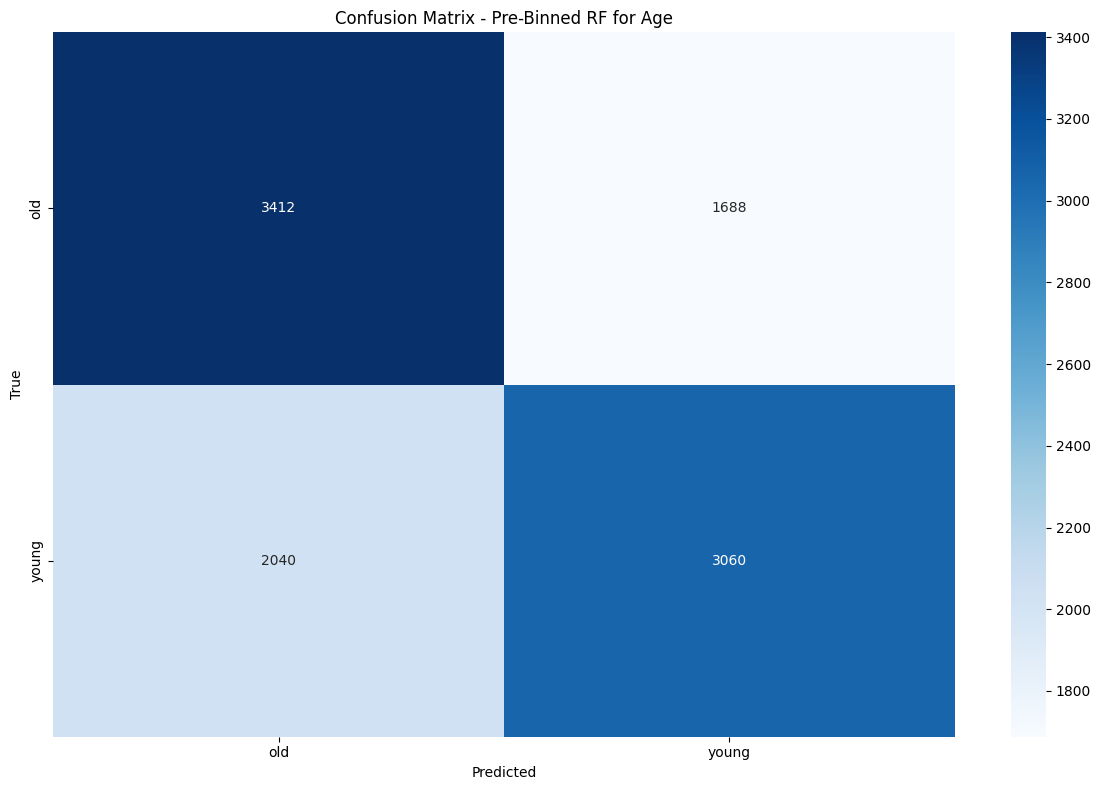

<Figure size 1000x600 with 0 Axes>

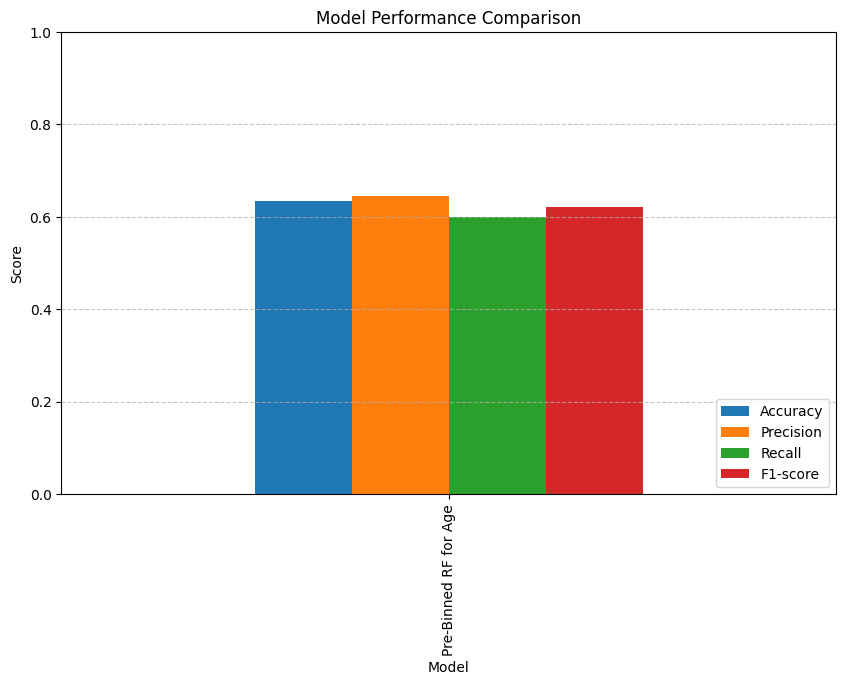

,Model,Accuracy,Precision,Recall,F1-score
0,Pre-Binned RF for Age,0.63451,0.644482,0.6,0.621446


In [43]:
fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(hidden_layer_sizes=(16,8), alpha=0.00005, activation="relu", batch_size=64, learning_rate_init=0.001, max_iter=30,  learning_rate="adaptive", random_state=27),
    RandomForestClassifier(max_depth= 30, max_features="sqrt", min_samples_leaf=1, min_samples_split=3, n_estimators=30, random_state=27),
    "MLP for Gender", "Pre-Binned RF for Age"
)

## Final Model Comparisons

Fitting Optimized SVC...
Predicting on training set...
Predicting on comparison set...
Evaluating Optimized SVC on training set...

===== Optimized SVC: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.63      0.66      0.64     17860
       young       0.64      0.61      0.62     17889

    accuracy                           0.63     35749
   macro avg       0.64      0.63      0.63     35749
weighted avg       0.64      0.63      0.63     35749

Evaluating Optimized SVC on comparison set...

===== Optimized SVC: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.62      0.62      0.62      4500
       young       0.62      0.62      0.62      4500

    accuracy                           0.62      9000
   macro avg       0.62      0.62      0.62      9000
weighted avg       0.62      0.62      0.62      9000



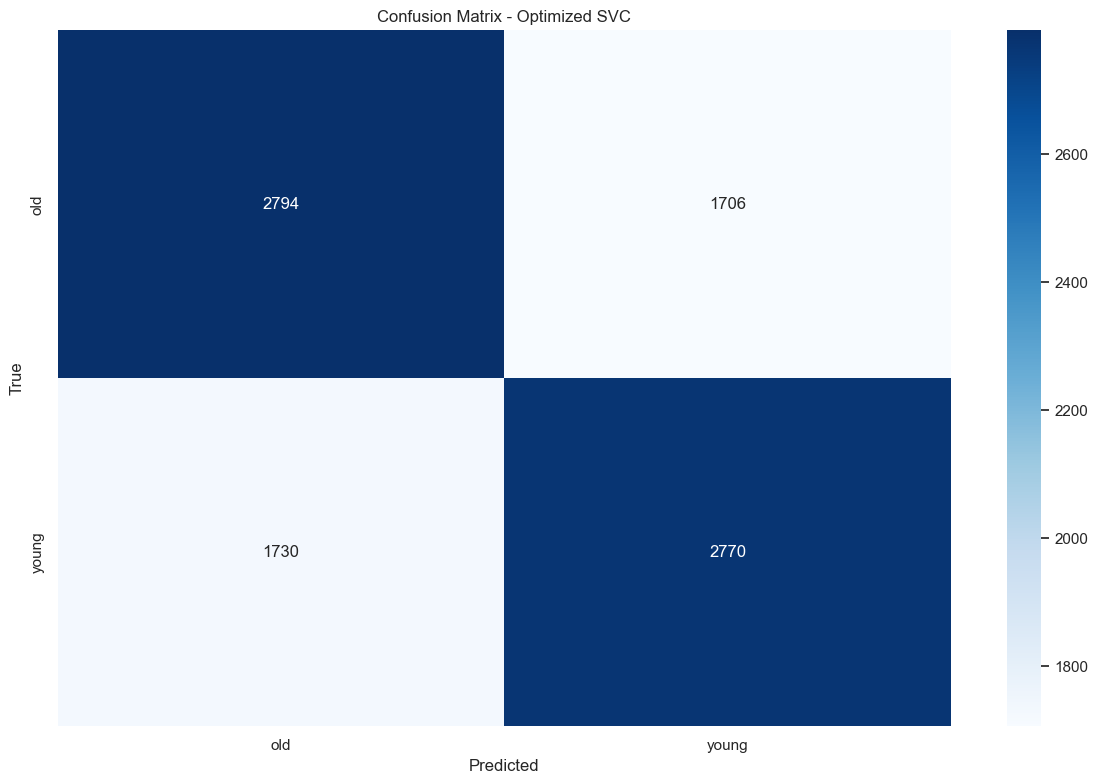

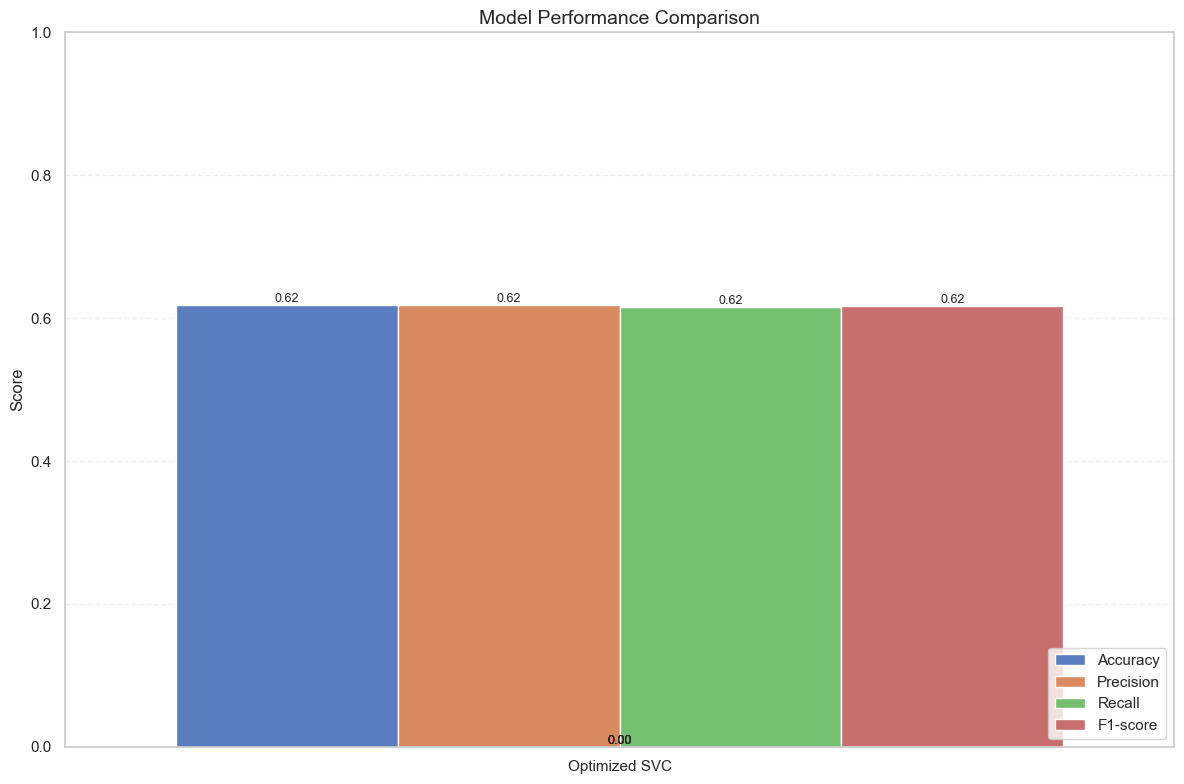

In [ ]:
# Best SVC based on grid search
#{'linear_svc_C': 1, 'linear_svcdual': True, 'linear_svcloss': 'squared_hinge', 'linear_svc_max_iter': 1000}
optimized_svc= fit_pipeline_predict_evaluate(
    LinearSVC(C=1, svcdual=True, loss="squared_hinge", max_iter=1000), "Optimized SVC",
    X_comp= X_test,
    y_comp= y_test["age_young_old"]
)

Fitting MLP optimized...
Predicting on training set...
Predicting on comparison set...
Evaluating MLP optimized on training set...

===== MLP optimized: Training Set =====
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17889
           1       1.00      1.00      1.00     17860

    accuracy                           1.00     35749
   macro avg       1.00      1.00      1.00     35749
weighted avg       1.00      1.00      1.00     35749

Evaluating MLP optimized on comparison set...

===== MLP optimized: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      4500
           1       0.69      0.70      0.69      4500

    accuracy                           0.69      9000
   macro avg       0.69      0.69      0.69      9000
weighted avg       0.69      0.69      0.69      9000



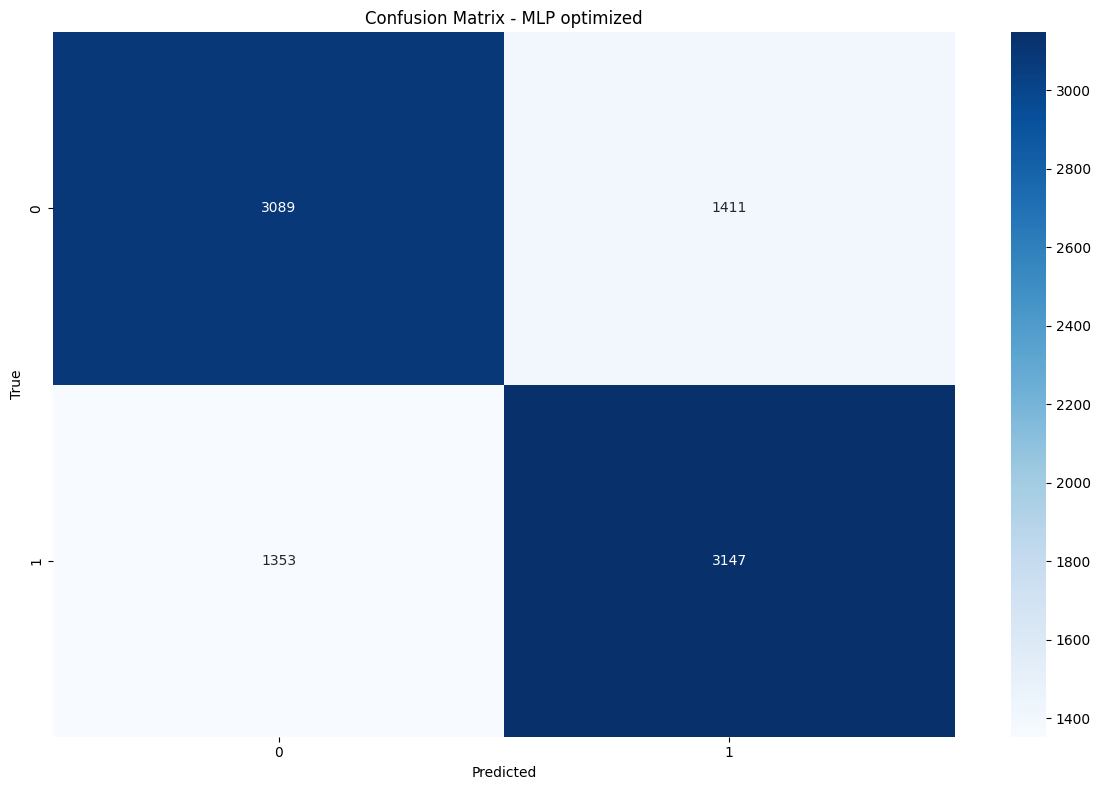

<Figure size 1000x600 with 0 Axes>

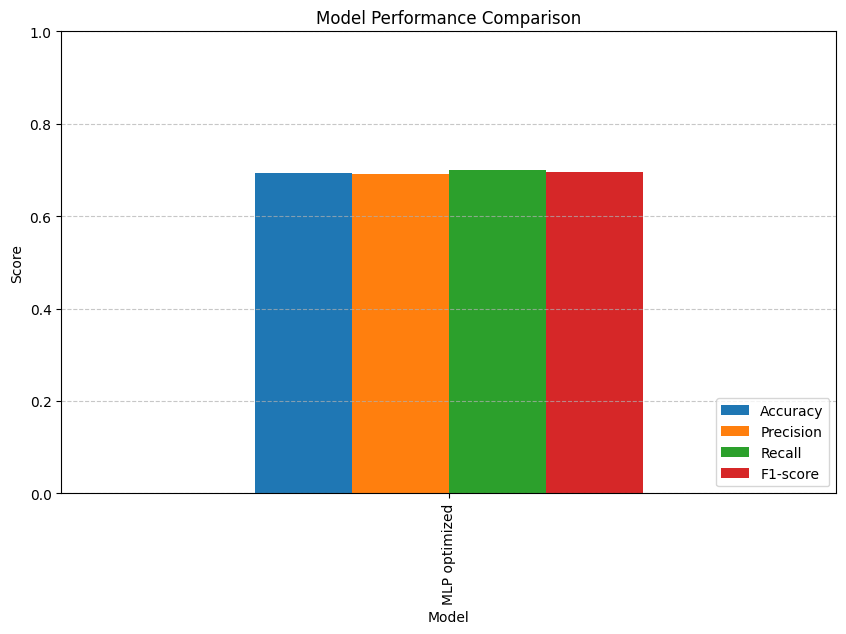

,Model,Accuracy,Precision,Recall,F1-score
0,MLP optimized,0.692889,0.690434,0.699333,0.694855


In [ ]:
# Best Parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 64, 'mlp__early_stopping': True, 'mlp__hidden_layer_sizes': (512, 256), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 200, 'mlp__solver': 'adam'

optimized_MLP_test_data= fit_pipeline_predict_evaluate(
    MLPClassifier(activation ='relu', alpha = 0.0001, batch_size = 64, hidden_layer_sizes = (512, 256), learning_rate_init = 0.0005, max_iter = 200, solver = 'adam', random_state= 27, learning_rate= "adaptive"),
    "Optimized Standard MLP",
    X_comp= X_test,
    y_train= y_train_clean["age_young_old_encoded"],
    y_comp= y_test["age_young_old_encoded"]
)
optimized_MLP_test_data


Fitting MLP for Gender on training set

Predicting MLP for Gender on training set

Predicting MLP for Gender on comparison set

MLP for Gender Gender Model - Training Set:
                 precision    recall  f1-score   support

female_feminine       1.00      1.00      1.00     18007
 male_masculine       1.00      1.00      1.00     22793

       accuracy                           1.00     40800
      macro avg       1.00      1.00      1.00     40800
   weighted avg       1.00      1.00      1.00     40800


MLP for Gender Gender Model - Comparison Set:
                 precision    recall  f1-score   support

female_feminine       0.91      0.90      0.91      3973
 male_masculine       0.92      0.93      0.93      5027

       accuracy                           0.92      9000
      macro avg       0.92      0.92      0.92      9000
   weighted avg       0.92      0.92      0.92      9000



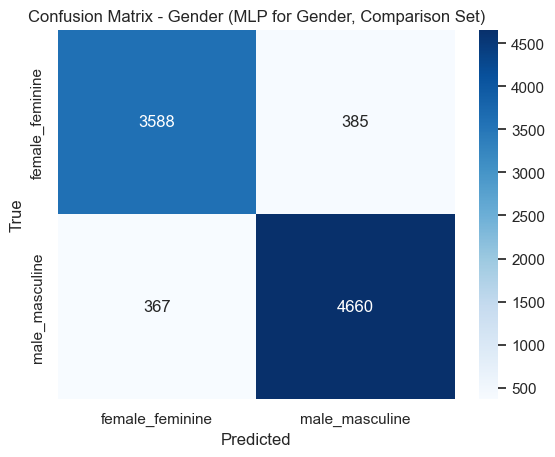


Fitting Gender Segmented MLP for Age on Gender Female

Fitting Gender Segmented MLP for Age on Gender Male


Predicting Gender Segmented MLP for Age on comparison set: 100%|██████████| 9000/9000 [01:57<00:00, 76.62it/s] 



Gender Segmented MLP for Age - Prediction Report on Gender female_feminine: Routed by True Gender
              precision    recall  f1-score   support

         old       0.71      0.76      0.73      1723
       young       0.80      0.76      0.78      2250

    accuracy                           0.76      3973
   macro avg       0.75      0.76      0.76      3973
weighted avg       0.76      0.76      0.76      3973



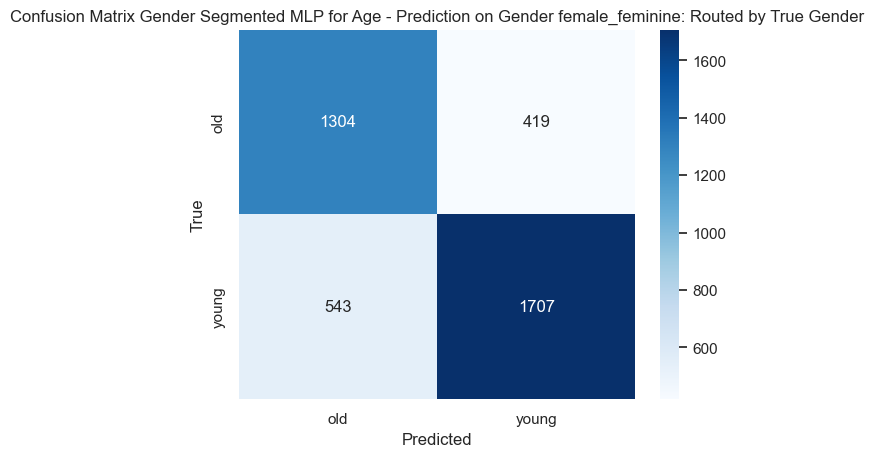


Gender Segmented MLP for Age - Prediction Report on Gender male_masculine: Routed by True Gender
              precision    recall  f1-score   support

         old       0.69      0.73      0.71      2777
       young       0.64      0.60      0.62      2250

    accuracy                           0.67      5027
   macro avg       0.67      0.67      0.67      5027
weighted avg       0.67      0.67      0.67      5027



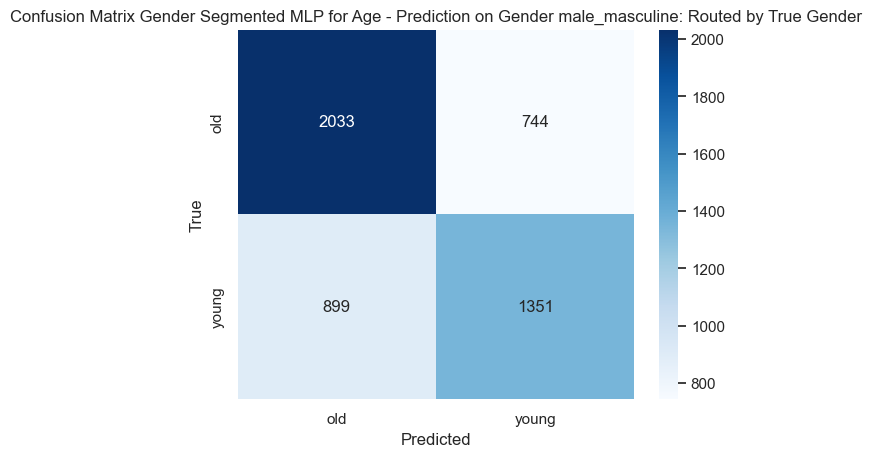


Gender Segmented MLP for Age - Prediction Report on Gender total: Routed by True Gender
              precision    recall  f1-score   support

         old       0.70      0.74      0.72      4500
       young       0.72      0.68      0.70      4500

    accuracy                           0.71      9000
   macro avg       0.71      0.71      0.71      9000
weighted avg       0.71      0.71      0.71      9000



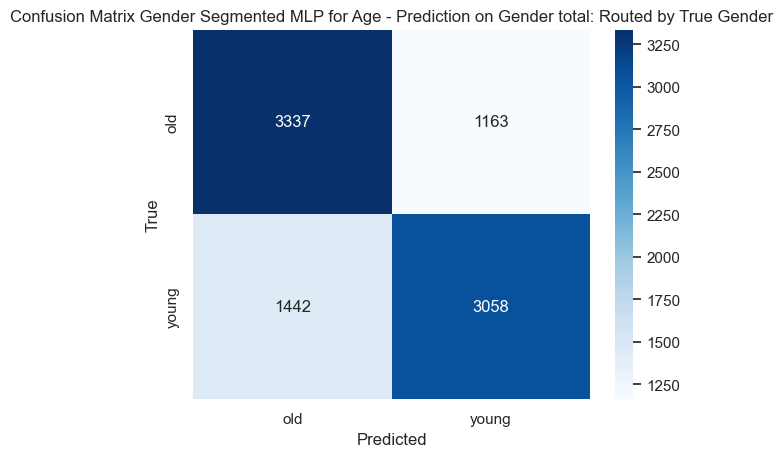


Gender Segmented MLP for Age - Prediction Report on Gender female_feminine: Routed by Predicted Gender
              precision    recall  f1-score   support

         old       0.69      0.72      0.71      1723
       young       0.78      0.75      0.77      2250

    accuracy                           0.74      3973
   macro avg       0.74      0.74      0.74      3973
weighted avg       0.74      0.74      0.74      3973



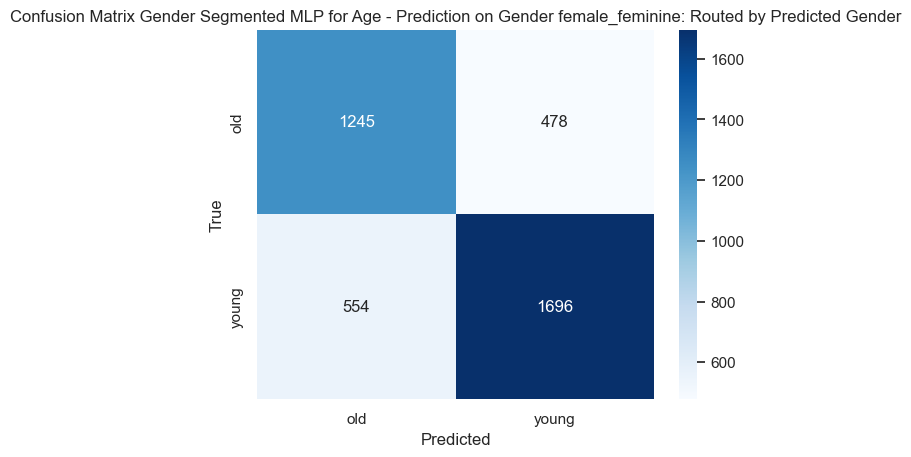


Gender Segmented MLP for Age - Prediction Report on Gender male_masculine: Routed by Predicted Gender
              precision    recall  f1-score   support

         old       0.69      0.73      0.71      2777
       young       0.64      0.59      0.62      2250

    accuracy                           0.67      5027
   macro avg       0.67      0.66      0.66      5027
weighted avg       0.67      0.67      0.67      5027



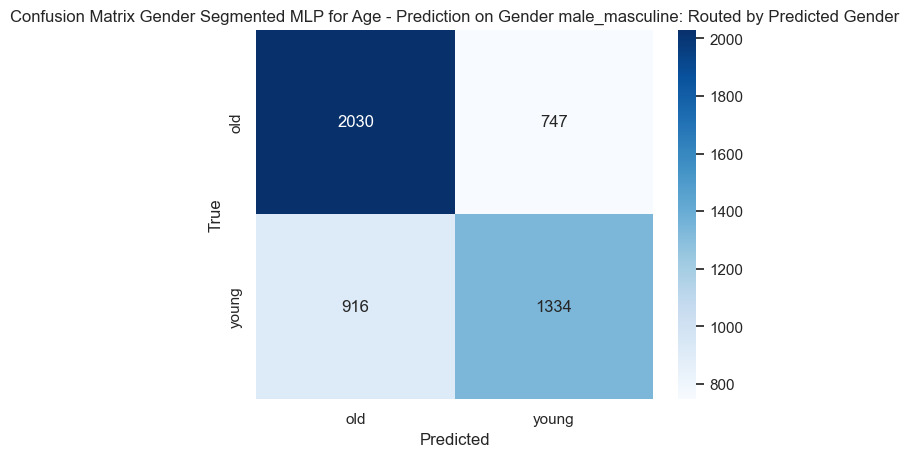


Gender Segmented MLP for Age - Prediction Report on Gender total: Routed by Predicted Gender
              precision    recall  f1-score   support

         old       0.69      0.73      0.71      4500
       young       0.71      0.67      0.69      4500

    accuracy                           0.70      9000
   macro avg       0.70      0.70      0.70      9000
weighted avg       0.70      0.70      0.70      9000



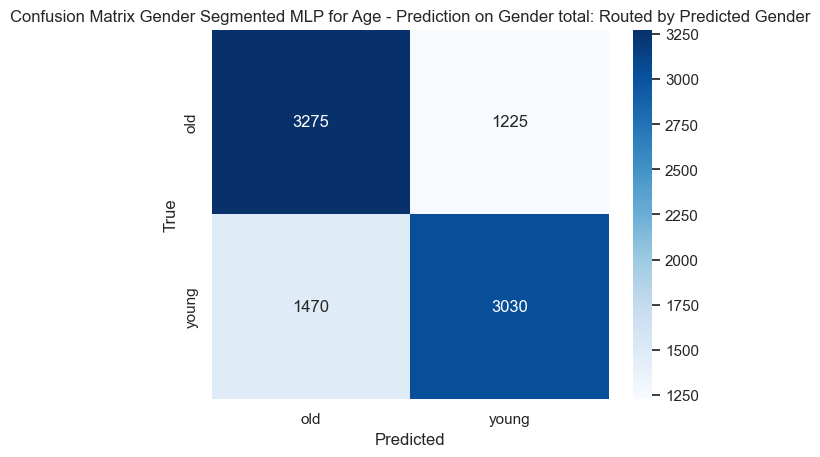

<Figure size 1200x800 with 0 Axes>

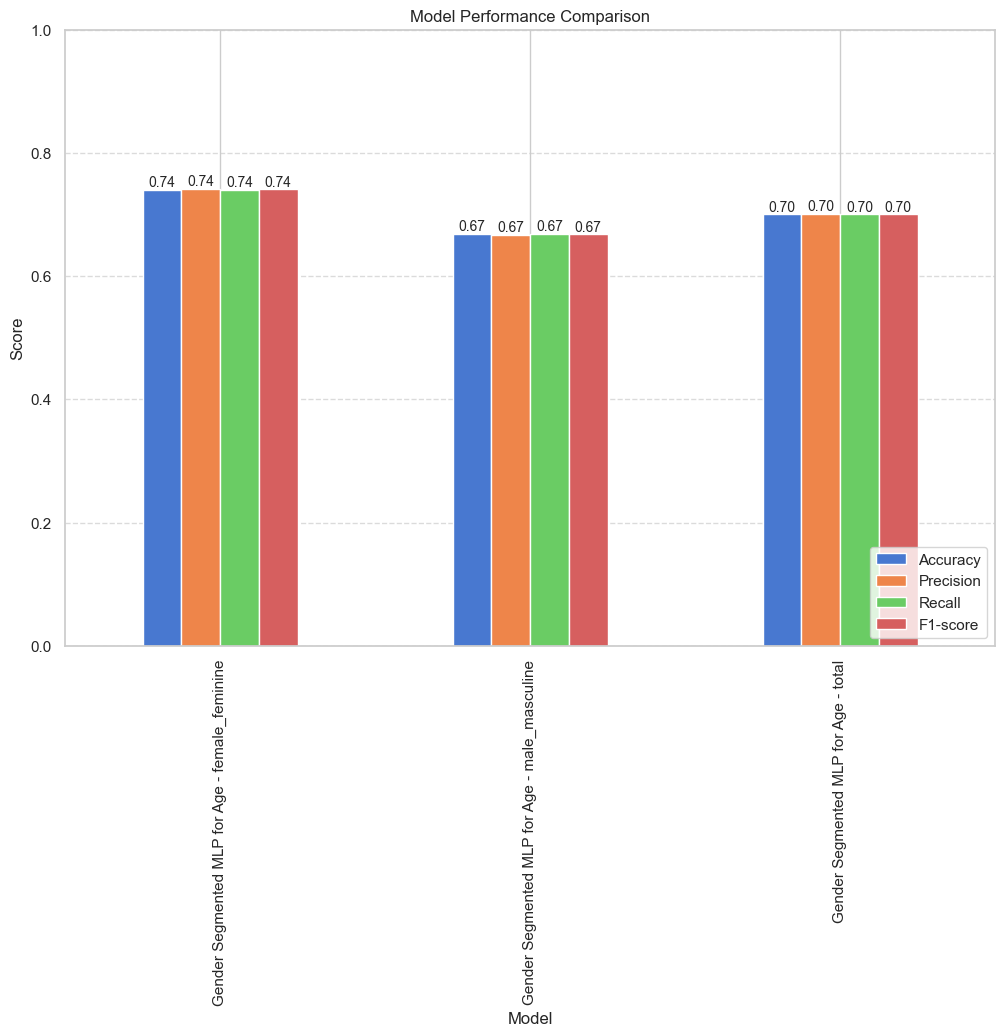


 Accuracy True Gender Routing: 0.7106

 Accuracy Predicted Gender Routing: 0.7006

 Routing Error Cost (Accuracy Loss from using predicted gender): 0.0100


,Model,Accuracy,Precision,Recall,F1-score
0,Gender Segmented MLP for Age - female_feminine,0.740247,0.741932,0.740247,0.740818
1,Gender Segmented MLP for Age - male_masculine,0.669186,0.667572,0.669186,0.667617
2,Gender Segmented MLP for Age - total,0.700556,0.701152,0.700556,0.700333


In [189]:
optimized_two_layer_test_data=fit_predict_two_stage_gender_age_pipeline(
    MLPClassifier(activation = 'relu', alpha = 0.00005, batch_size = 64, hidden_layer_sizes = (512, 256, 128), learning_rate_init = 0.001, max_iter= 3000, random_state= 27, learning_rate= "adaptive"),
    MLPClassifier(activation = 'relu', alpha = 0.0001, batch_size = 64, hidden_layer_sizes = (512, 256), learning_rate_init = 0.001, max_iter = 200, solver = 'adam', random_state= 27, learning_rate= "adaptive"),
    MLPClassifier(activation = 'relu', alpha = 0.001, batch_size = 64, hidden_layer_sizes = (512, 256), learning_rate_init = 0.001, max_iter = 200, solver = 'adam', random_state= 27, learning_rate= "adaptive"),
    "MLP for Gender",
    "Gender Segmented MLP for Age",
    X_comp = X_test,
    y_comp_age = y_test["age_young_old"],
    y_comp_gender = y_test["gender"],
)
optimized_two_layer_test_data


Fitting MLP for Gender Probability on training set

Predict probability of MLP for Gender Probability on training set

Predict probability of MLP for Gender Probability on comparison set

MLP for Gender Probability Gender Model - Comparison Set Classification Report:
                 precision    recall  f1-score   support

female_feminine       0.91      0.90      0.91      3973
 male_masculine       0.92      0.93      0.93      5027

       accuracy                           0.92      9000
      macro avg       0.92      0.92      0.92      9000
   weighted avg       0.92      0.92      0.92      9000

AUC-ROC for Gender Probabilities: 0.9687
Log Loss for Gender Probabilities: 0.6295


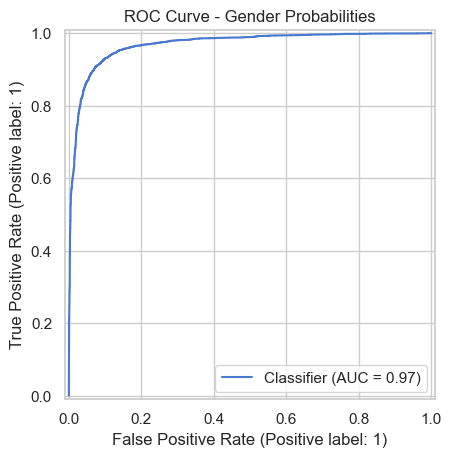

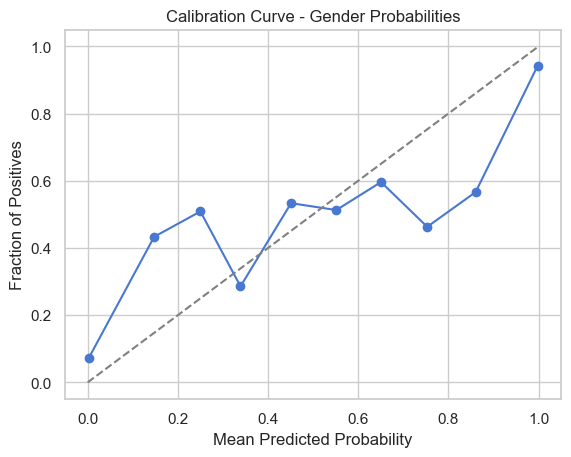


Fitting Feature Augmented MLP for Age with gender probability feature

Predicting Feature Augmented MLP for Age on training set

Predicting Feature Augmented MLP for Age on comparison set

===== Feature Augmented MLP for Age: Training Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.99      0.99      0.99     20400
       young       0.99      0.99      0.99     20400

    accuracy                           0.99     40800
   macro avg       0.99      0.99      0.99     40800
weighted avg       0.99      0.99      0.99     40800


===== Feature Augmented MLP for Age: Comparison Set =====
Classification Report:
              precision    recall  f1-score   support

         old       0.70      0.69      0.69      4500
       young       0.69      0.70      0.70      4500

    accuracy                           0.69      9000
   macro avg       0.69      0.69      0.69      9000
weighted avg       0.69      0.69      0.69      9

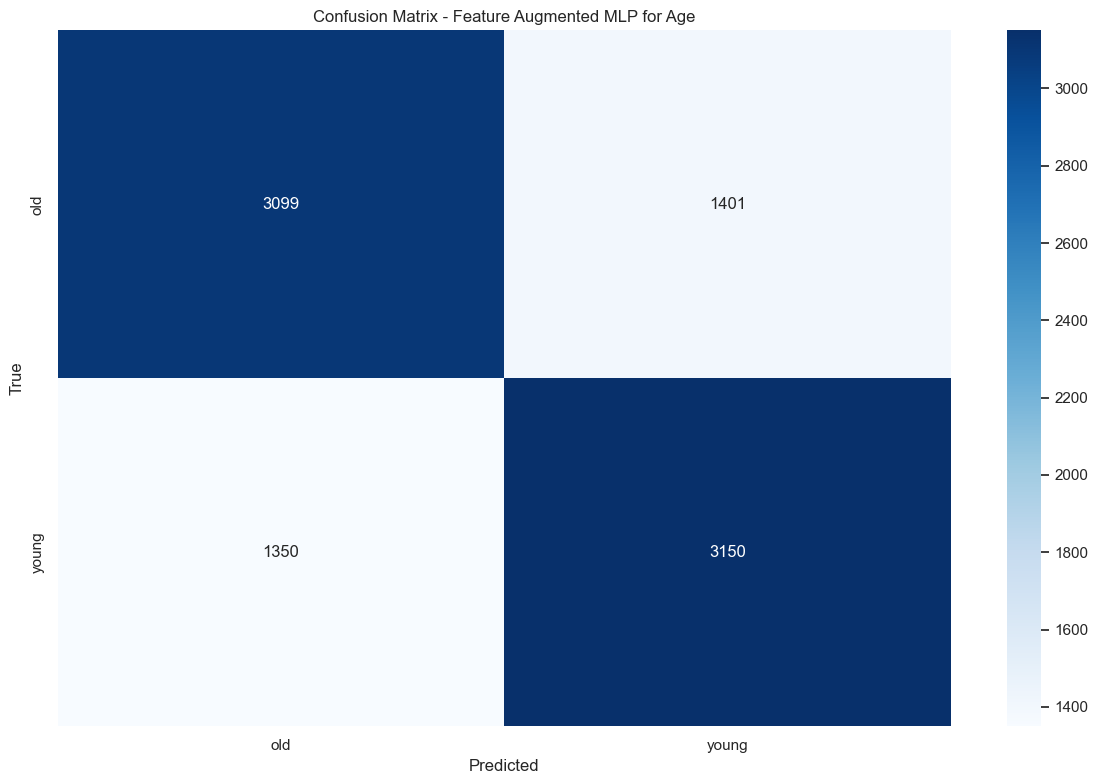

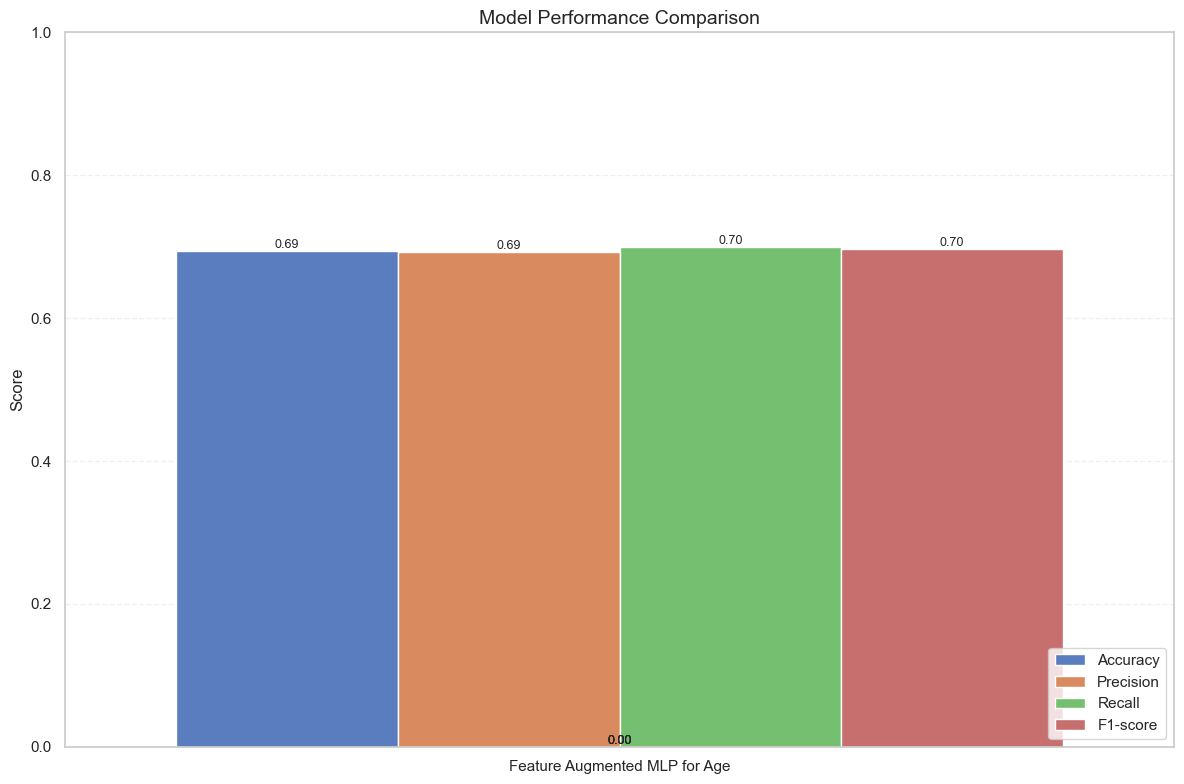

,Model,Accuracy,Precision,Recall,F1-score
0,Feature Augmented MLP for Age,0.694333,0.692156,0.7,0.696056


In [190]:
optimized_soft_feature_test_data=fit_predict_gender_age_pipeline_with_soft_feature(
    MLPClassifier(activation = 'relu', alpha = 0.00005, batch_size = 64, hidden_layer_sizes = (512, 256, 128), learning_rate_init = 0.001, max_iter= 3000, random_state= 27, learning_rate= "adaptive"),
    MLPClassifier(activation ='relu', alpha = 0.0001, batch_size = 64, hidden_layer_sizes = (512, 256), learning_rate_init = 0.001, max_iter = 200, solver = 'adam', random_state= 27, learning_rate= "adaptive"),
    "MLP for Gender Probability",
    "Feature Augmented MLP for Age",
    X_comp = X_test,
    y_comp_age = y_test["age_young_old"],
    y_comp_gender = y_test["gender"],
    y_comp_gender_encoded= y_test["gender_encoded"]
)
optimized_soft_feature_test_data

<Figure size 3000x1600 with 0 Axes>

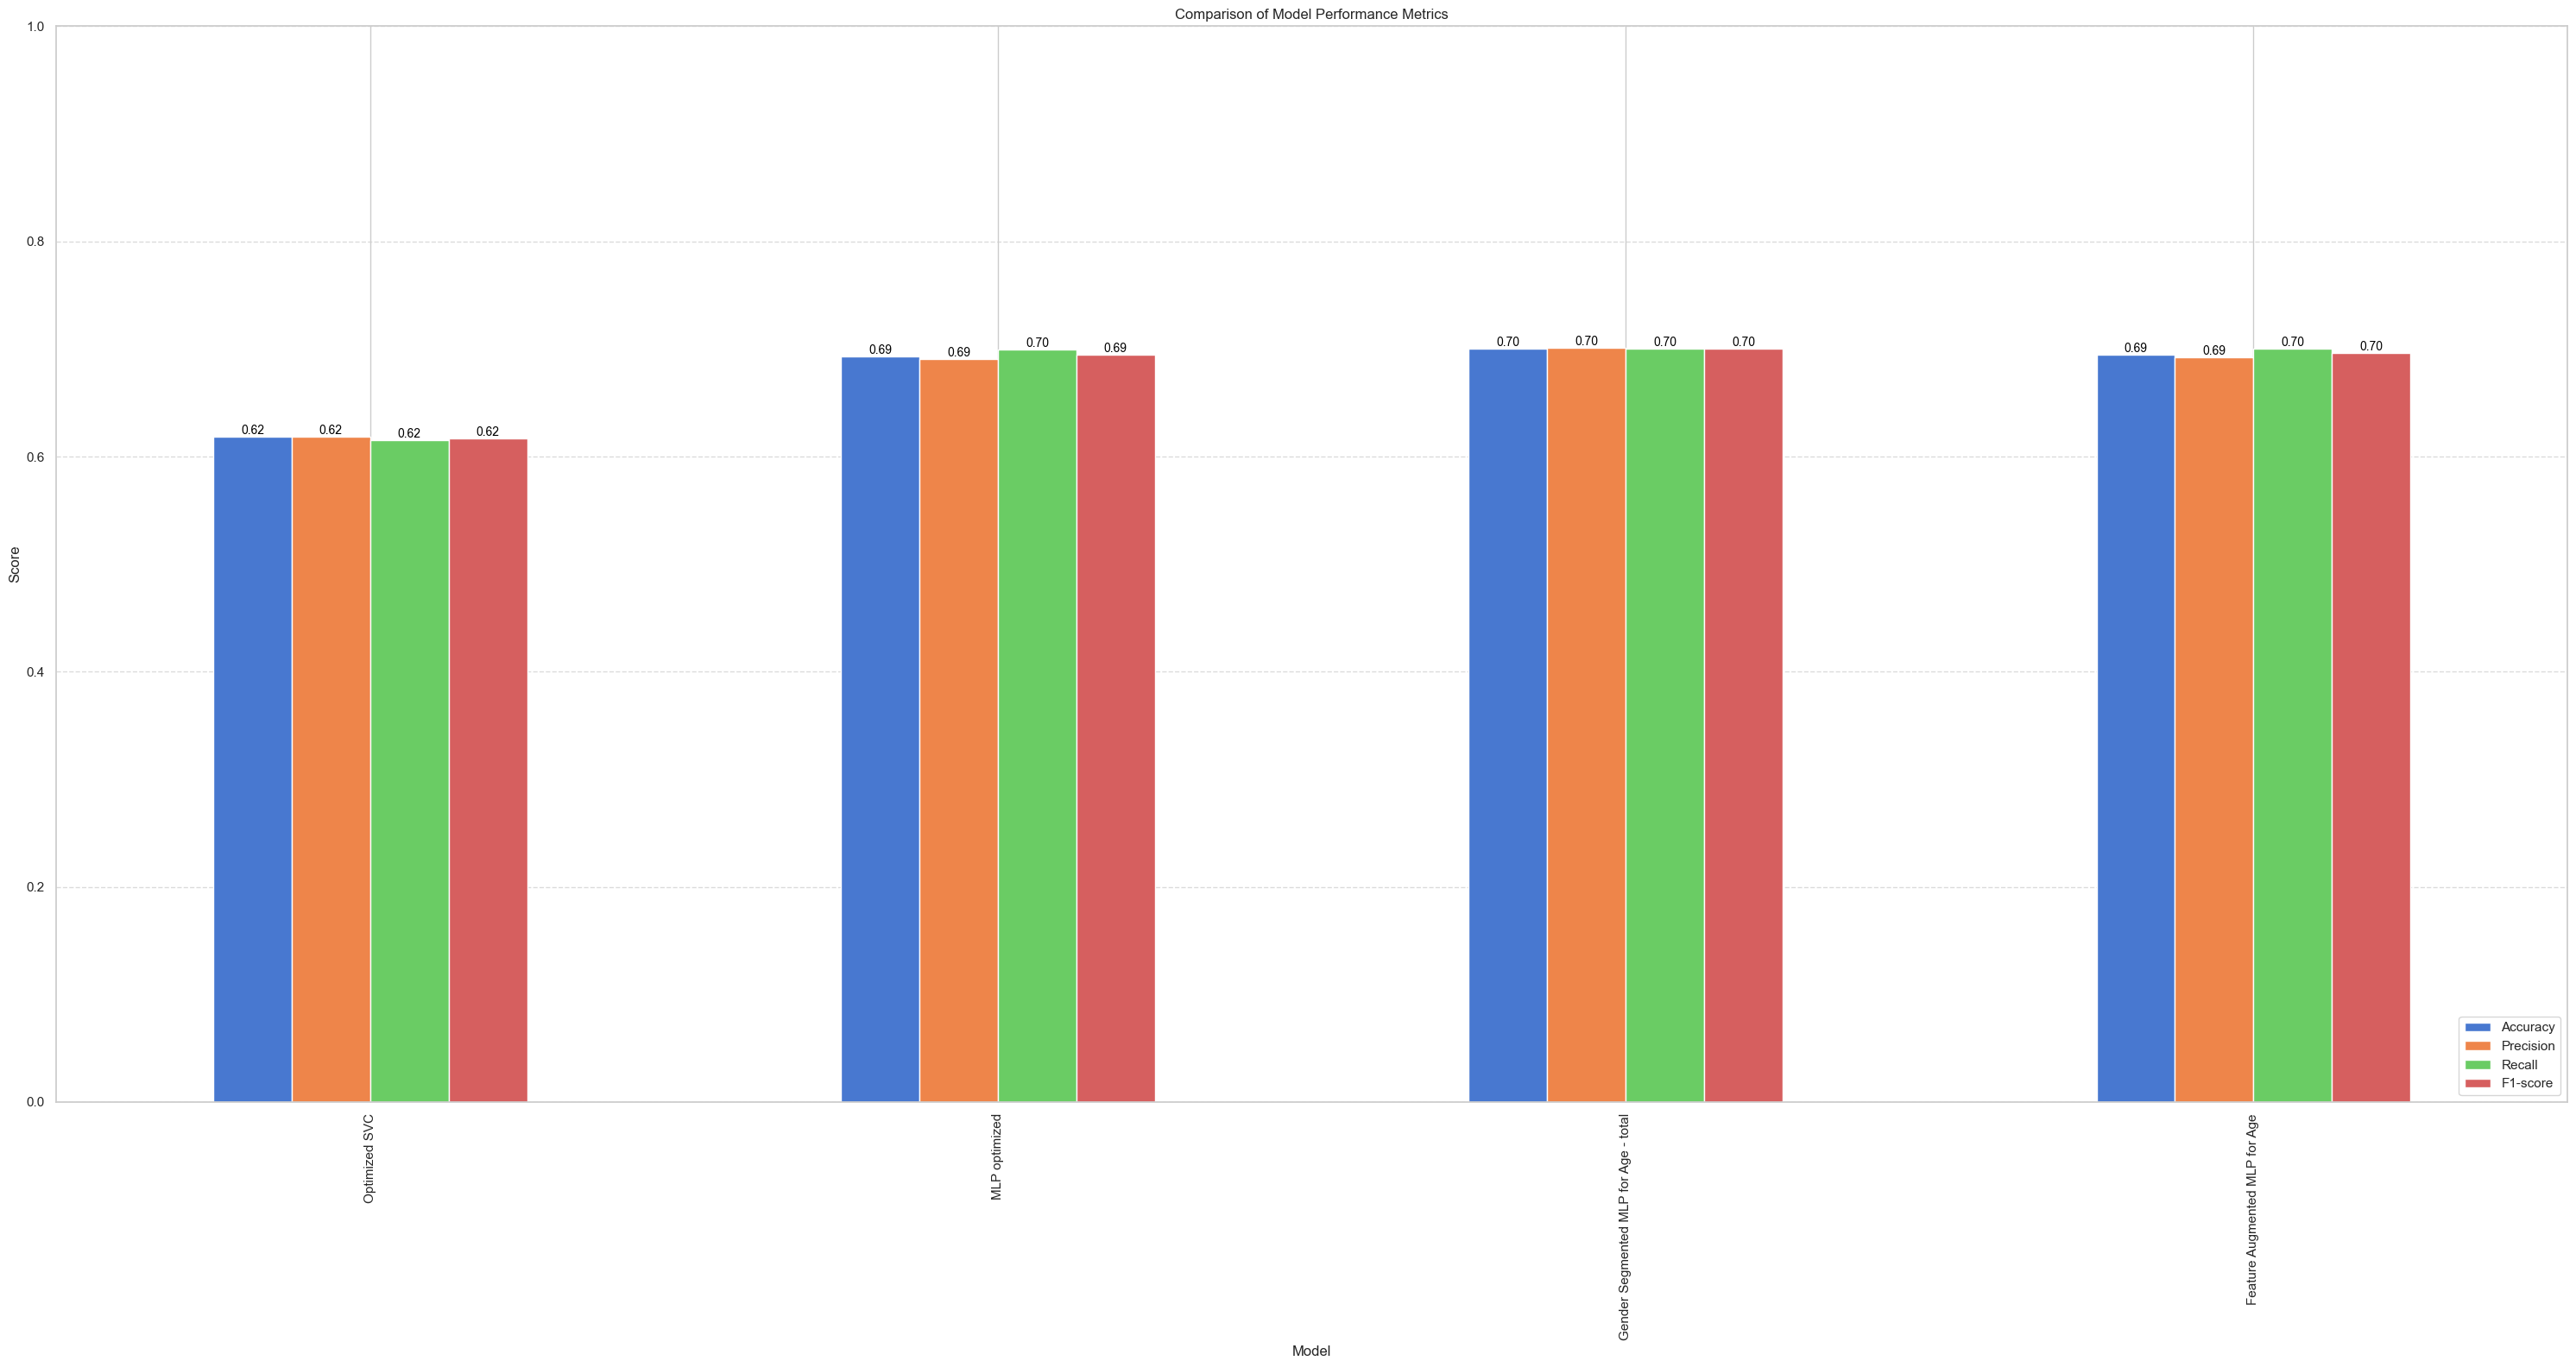

In [192]:
compare_selected_metrics(
    optimized_svc,
    optimized_MLP_test_data,
    optimized_two_layer_test_data,
    optimized_soft_feature_test_data, fig_size=(30, 16), exclude_suffixes=('ine')
    )